In [1]:
import numpy as np
from HH4b import utils
from HH4b import postprocessing
import xgboost as xgb
import importlib
import hist
import os

import mplhep as hep
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from HH4b.postprocessing.PostProcess import add_bdt_scores

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

In [2]:
diff_axis = hist.axis.Regular(15, 0, 150, name="diff")
rel_diff_axis = hist.axis.Regular(30, -150, 150, name="diff")
bdt_axis = hist.axis.Regular(20, 0, 1, name="bdt")
sample_axis = hist.axis.StrCategory([], name="samp", growth=True)
cut_axis = hist.axis.StrCategory([], name="cut", growth=True)

In [3]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

## Sculpting checks

Load data events

In [4]:
data_dir = "24Apr23LegacyLowerThresholds_v12_private_signal"
input_dir = f"/eos/uscms/store/user/cmantill/bbbb/skimmer/{data_dir}"

legacy_label = "Legacy"

qcd_list = [
    "QCD_HT-1000to1200",
    "QCD_HT-1200to1500",
    "QCD_HT-1500to2000",
    "QCD_HT-2000",
    "QCD_HT-400to600",
    "QCD_HT-600to800",
    "QCD_HT-800to1000",
]

samples_run3 = {
    "2022EE": {
        #"data": ["JetMET_Run2022E"],
        #"hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV"],
        #"ttbar": ["TTto"],
        "qcd": qcd_list,
    },
    "2022": {
        #"ttbar": ["TTto"],
        "qcd": qcd_list,
    },
    "2023": {
        #"hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"],
        #"ttbar": ["TTto"],
        "qcd": qcd_list,
    },
    "2023BPix": {
        #"hh4b": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV"],
        #"ttbar": ["TTto"],
        "qcd": qcd_list,
    },
}

events_dict = {}
for year in samples_run3:
    events_dict[year] = postprocessing.load_run3_samples(
        input_dir=input_dir,
        year=year,
        legacy=True,
        samples_run3=samples_run3,
        reorder_txbb=True,
        txbb=f"bbFatJetPNetTXbb{legacy_label}",
    )

Loaded QCD_HT-1000to1200                                 : 383315 entries
Loaded QCD_HT-1200to1500                                 : 602463 entries
Loaded QCD_HT-1500to2000                                 : 738825 entries
Loaded QCD_HT-2000                                       : 1031121 entries
Loaded QCD_HT-400to600                                   : 491 entries
Loaded QCD_HT-600to800                                   : 48716 entries
Loaded QCD_HT-800to1000                                  : 209128 entries
Loaded QCD_HT-1000to1200                                 : 119967 entries
Loaded QCD_HT-1200to1500                                 : 184678 entries
Loaded QCD_HT-1500to2000                                 : 260413 entries
Loaded QCD_HT-2000                                       : 311664 entries
Loaded QCD_HT-400to600                                   : 104 entries
Loaded QCD_HT-600to800                                   : 14728 entries
Loaded QCD_HT-800to1000                      

Get dataframe

In [5]:
def get_dataframe(events_dict, year, bdt_model_name, bdt_config):
    bdt_model = xgb.XGBClassifier()
    bdt_model.load_model(fname=f"../boosted/bdt_trainings_run3/{bdt_model_name}/trained_bdt.model")
    make_bdt_dataframe = importlib.import_module(
        f".{bdt_config}", package="HH4b.boosted.bdt_trainings_run3"
    )

    bdt_events_dict = {}
    for key in events_dict:
        events = events_dict[key]
        bdt_events = make_bdt_dataframe.bdt_dataframe(events)
        preds = bdt_model.predict_proba(bdt_events)
        # inference
        add_bdt_scores(bdt_events, preds)

        # extra variables
        bdt_events["H1PNetMass"] = events["bbFatJetPNetMassLegacy"][0]
        bdt_events["H2PNetMass"] = events["bbFatJetPNetMassLegacy"][1]
        bdt_events["H1Msd"] = events["bbFatJetMsd"][0]
        bdt_events["H1TXbb"] = events[f"bbFatJetPNetTXbb{legacy_label}"][0]
        bdt_events["H2TXbb"] = events[f"bbFatJetPNetTXbb{legacy_label}"][1]
        bdt_events["weight"] = events["finalWeight"].to_numpy()

        bdt_events["hlt"] = np.any(
            np.array(
                [events[trigger][0] for trigger in postprocessing.HLTs[year] if trigger in events]
            ),
            axis=0,
        )
        mask_hlt = bdt_events["hlt"] == 1

        # masks
        mask_presel = (
            (bdt_events["H1Msd"] > 40)
            & (bdt_events["H1Pt"] > 300)
            & (bdt_events["H2Pt"] > 300)
            & (bdt_events["H1TXbb"] > 0.8)
        )
        mask_mass = (bdt_events["H2PNetMass"] > 50) & (bdt_events["H2PNetMass"] < 250)
        bdt_events = bdt_events[(mask_mass) & (mask_hlt) & (mask_presel)]

        columns = ["bdt_score", "H2TXbb", "H1PNetMass", "H2PNetMass", "weight"]
        bdt_events_dict[key] = bdt_events[columns]
    return bdt_events_dict

In [6]:
mass_var = "H2PNetMass"
bdt_model_name = "24Apr21_legacy_vbf_vars"
bdt_config = "24Apr21_legacy_vbf_vars"
bdt_events_dict_year = {}
for year in events_dict:
    bdt_events_dict_year[year] = get_dataframe(events_dict[year], year, bdt_model_name, bdt_config)

In [7]:
bdt_events_dict_year.keys()

dict_keys(['2022EE', '2022', '2023', '2023BPix'])

In [8]:
events_combined, scaled_by = postprocessing.combine_run3_samples(
    bdt_events_dict_year,
    # ["ttbar", "hh4b"],
    ["qcd"],
    # ["data"],
    bg_keys=["ttbar"],
    scale_processes={
        "hh4b": ["2022EE", "2023", "2023BPix"],
    },
    years_run3=events_dict.keys(),
)

In [ ]:
events_combined

## Selection regions

- Cat 1: 
  T2Xbb: [0.99, 1], BDT: [0.94, 1]
- Cat 2:  

  T2Xbb: [0.99, 1], BDT: [0.68, 0.94] 
  OR 
  T2Xbb: [0.94, 0.99], BDT: [0.94, 1]
- Cat 3:

  T2Xbb: [0.94, 1], BDT: [0.03, 0.68]
  OR
  T2Xbb: [0.94, 0.99], BDT: [0.68, 0.94]

In [9]:
bdt_cuts = [[0.03, 0.68], [0.68, 0.94], [0.94, 1]]
xbb_cuts = [[0, 0.94], [0.94, 0.99], [0.99, 1]]

# odir = "../../../plots/Sculpting_All/"
odir = "../../../plots/Sculpting_QCD/"
# odir = "../../../plots/Sculpting_Data/"
os.system(f"mkdir -p {odir}")

presel = r"$p^{1,2}_T > 300, m_{SD}^{H1} > 40$" + "\n" + r"$Xbb^{H1} > 0.8, m^{1,2}: [50-250]$"

labels = {
    "ttbar": "TT + jets (All eras)",
    "hh4b": "HH(4b) (2022EE+2023)",
    "data": "JetMet Run2022E",
    "qcd": "QCD (All eras)",
}

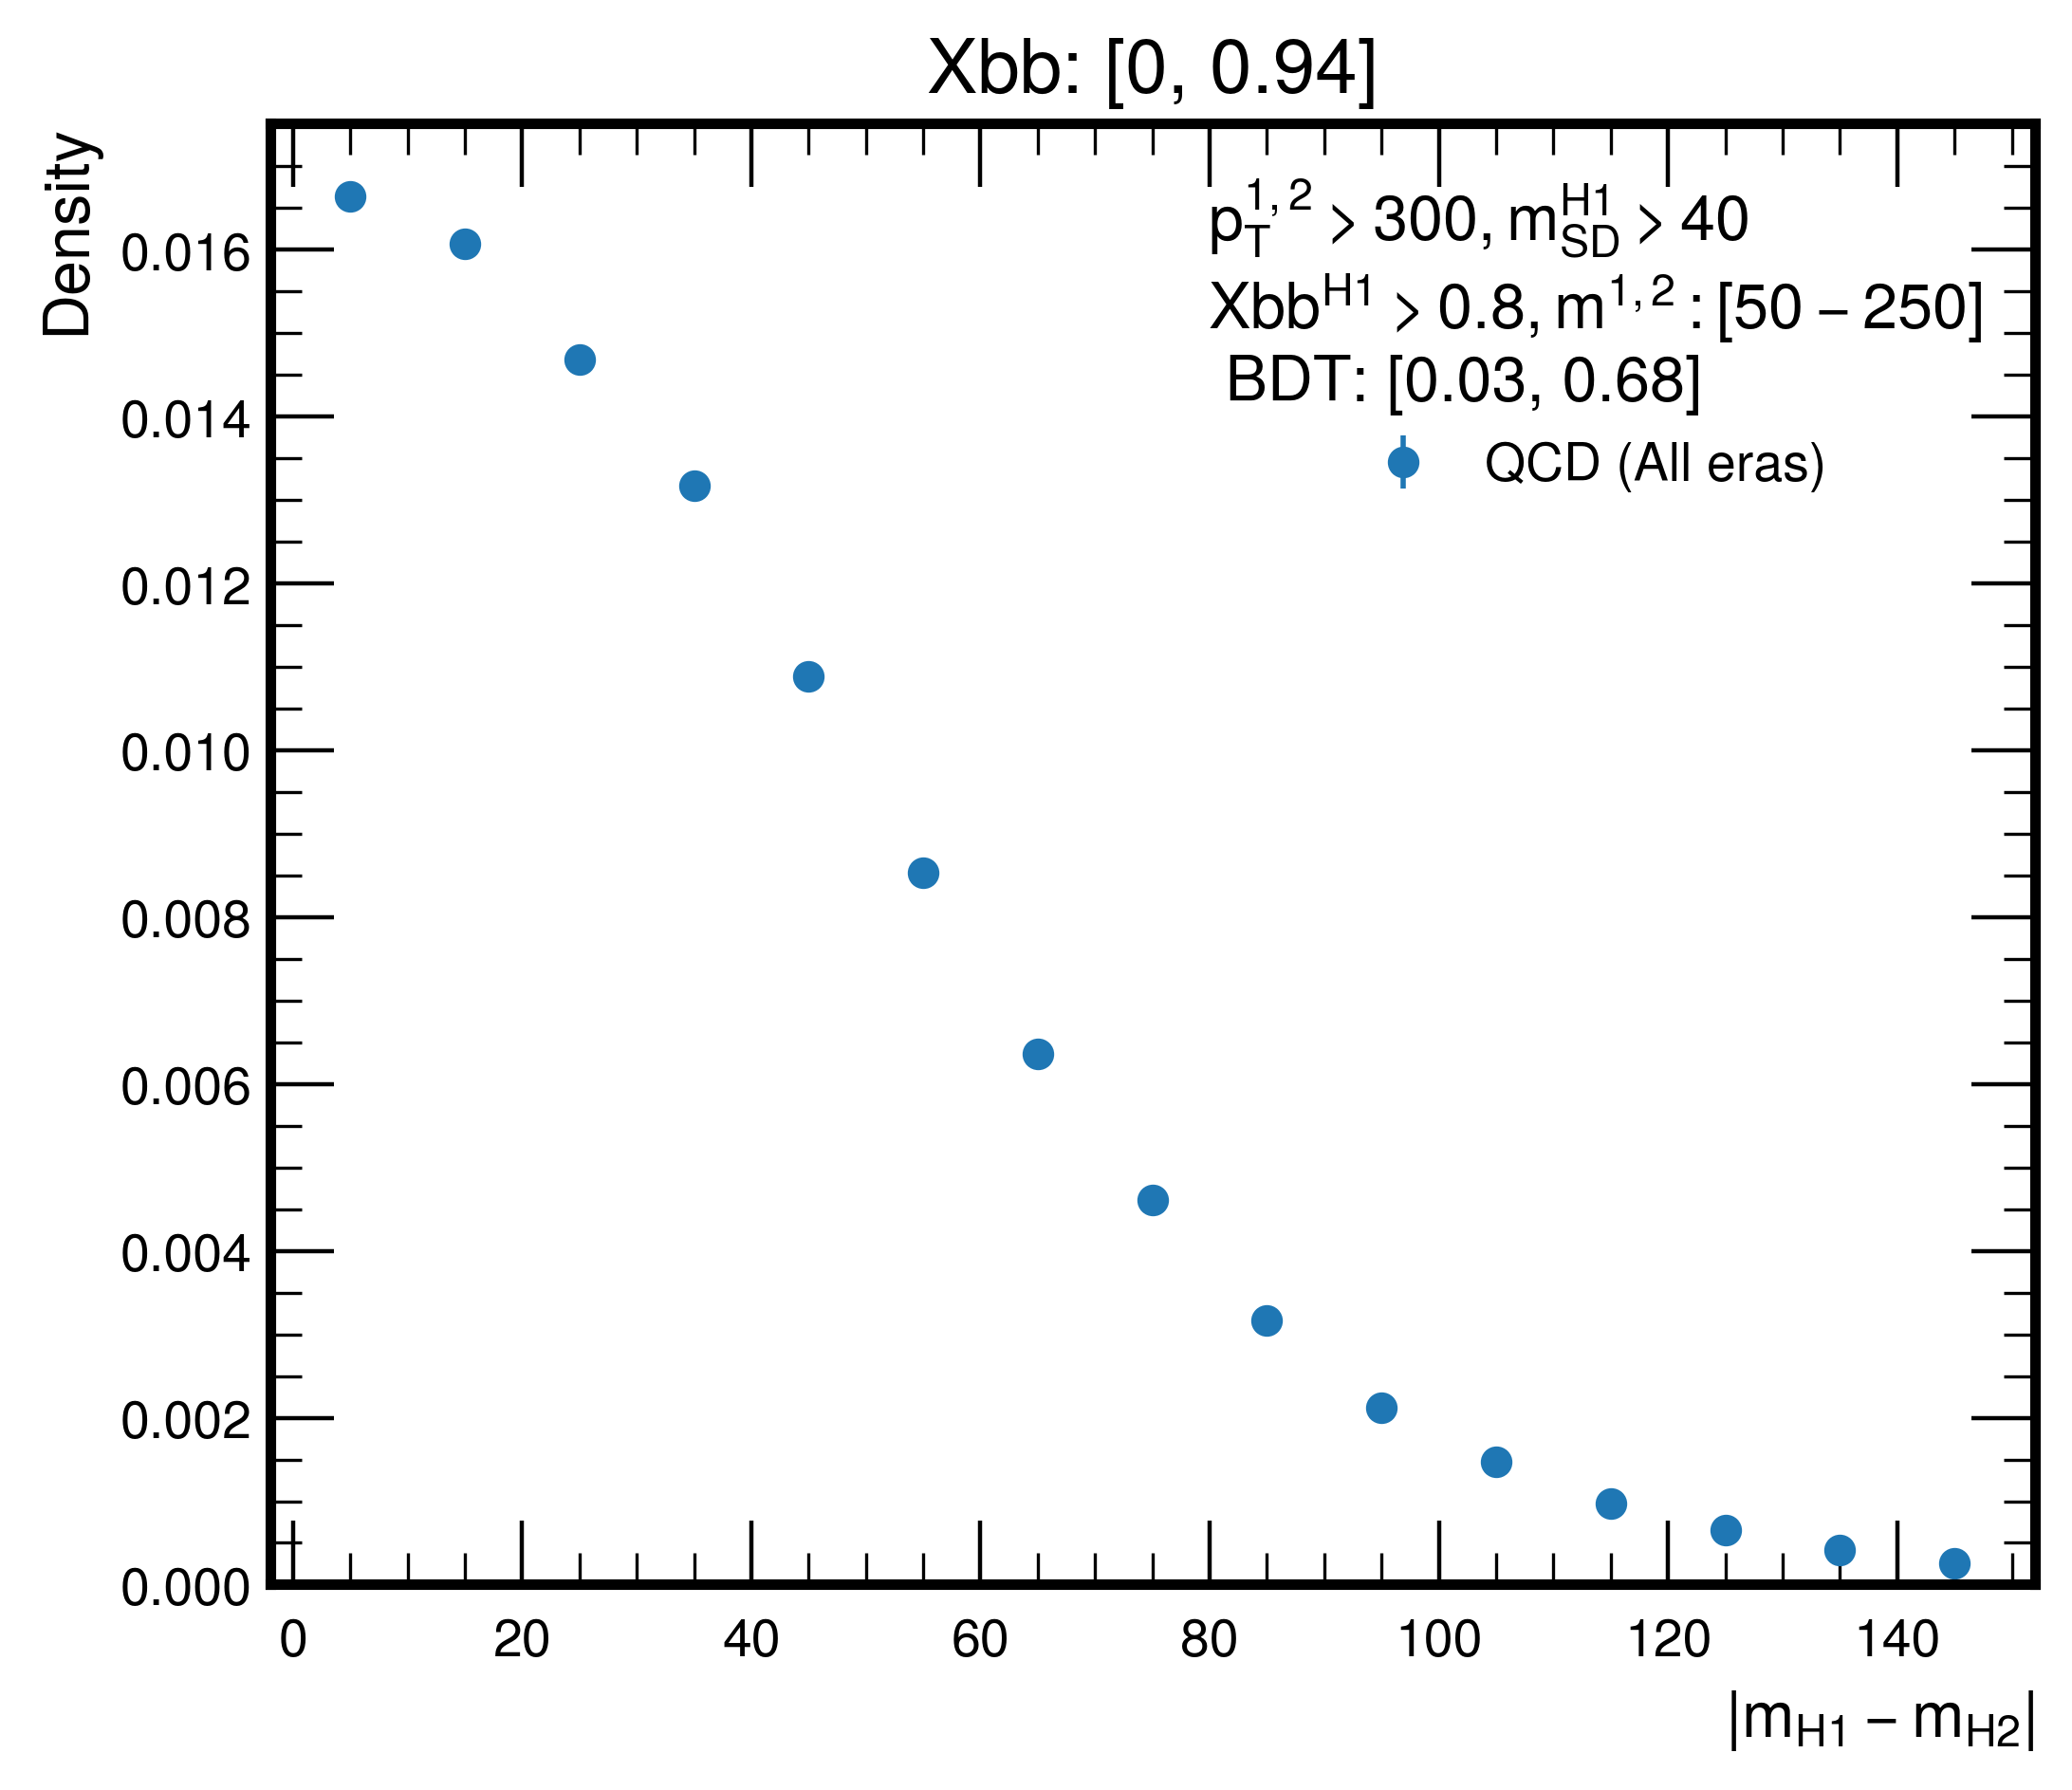

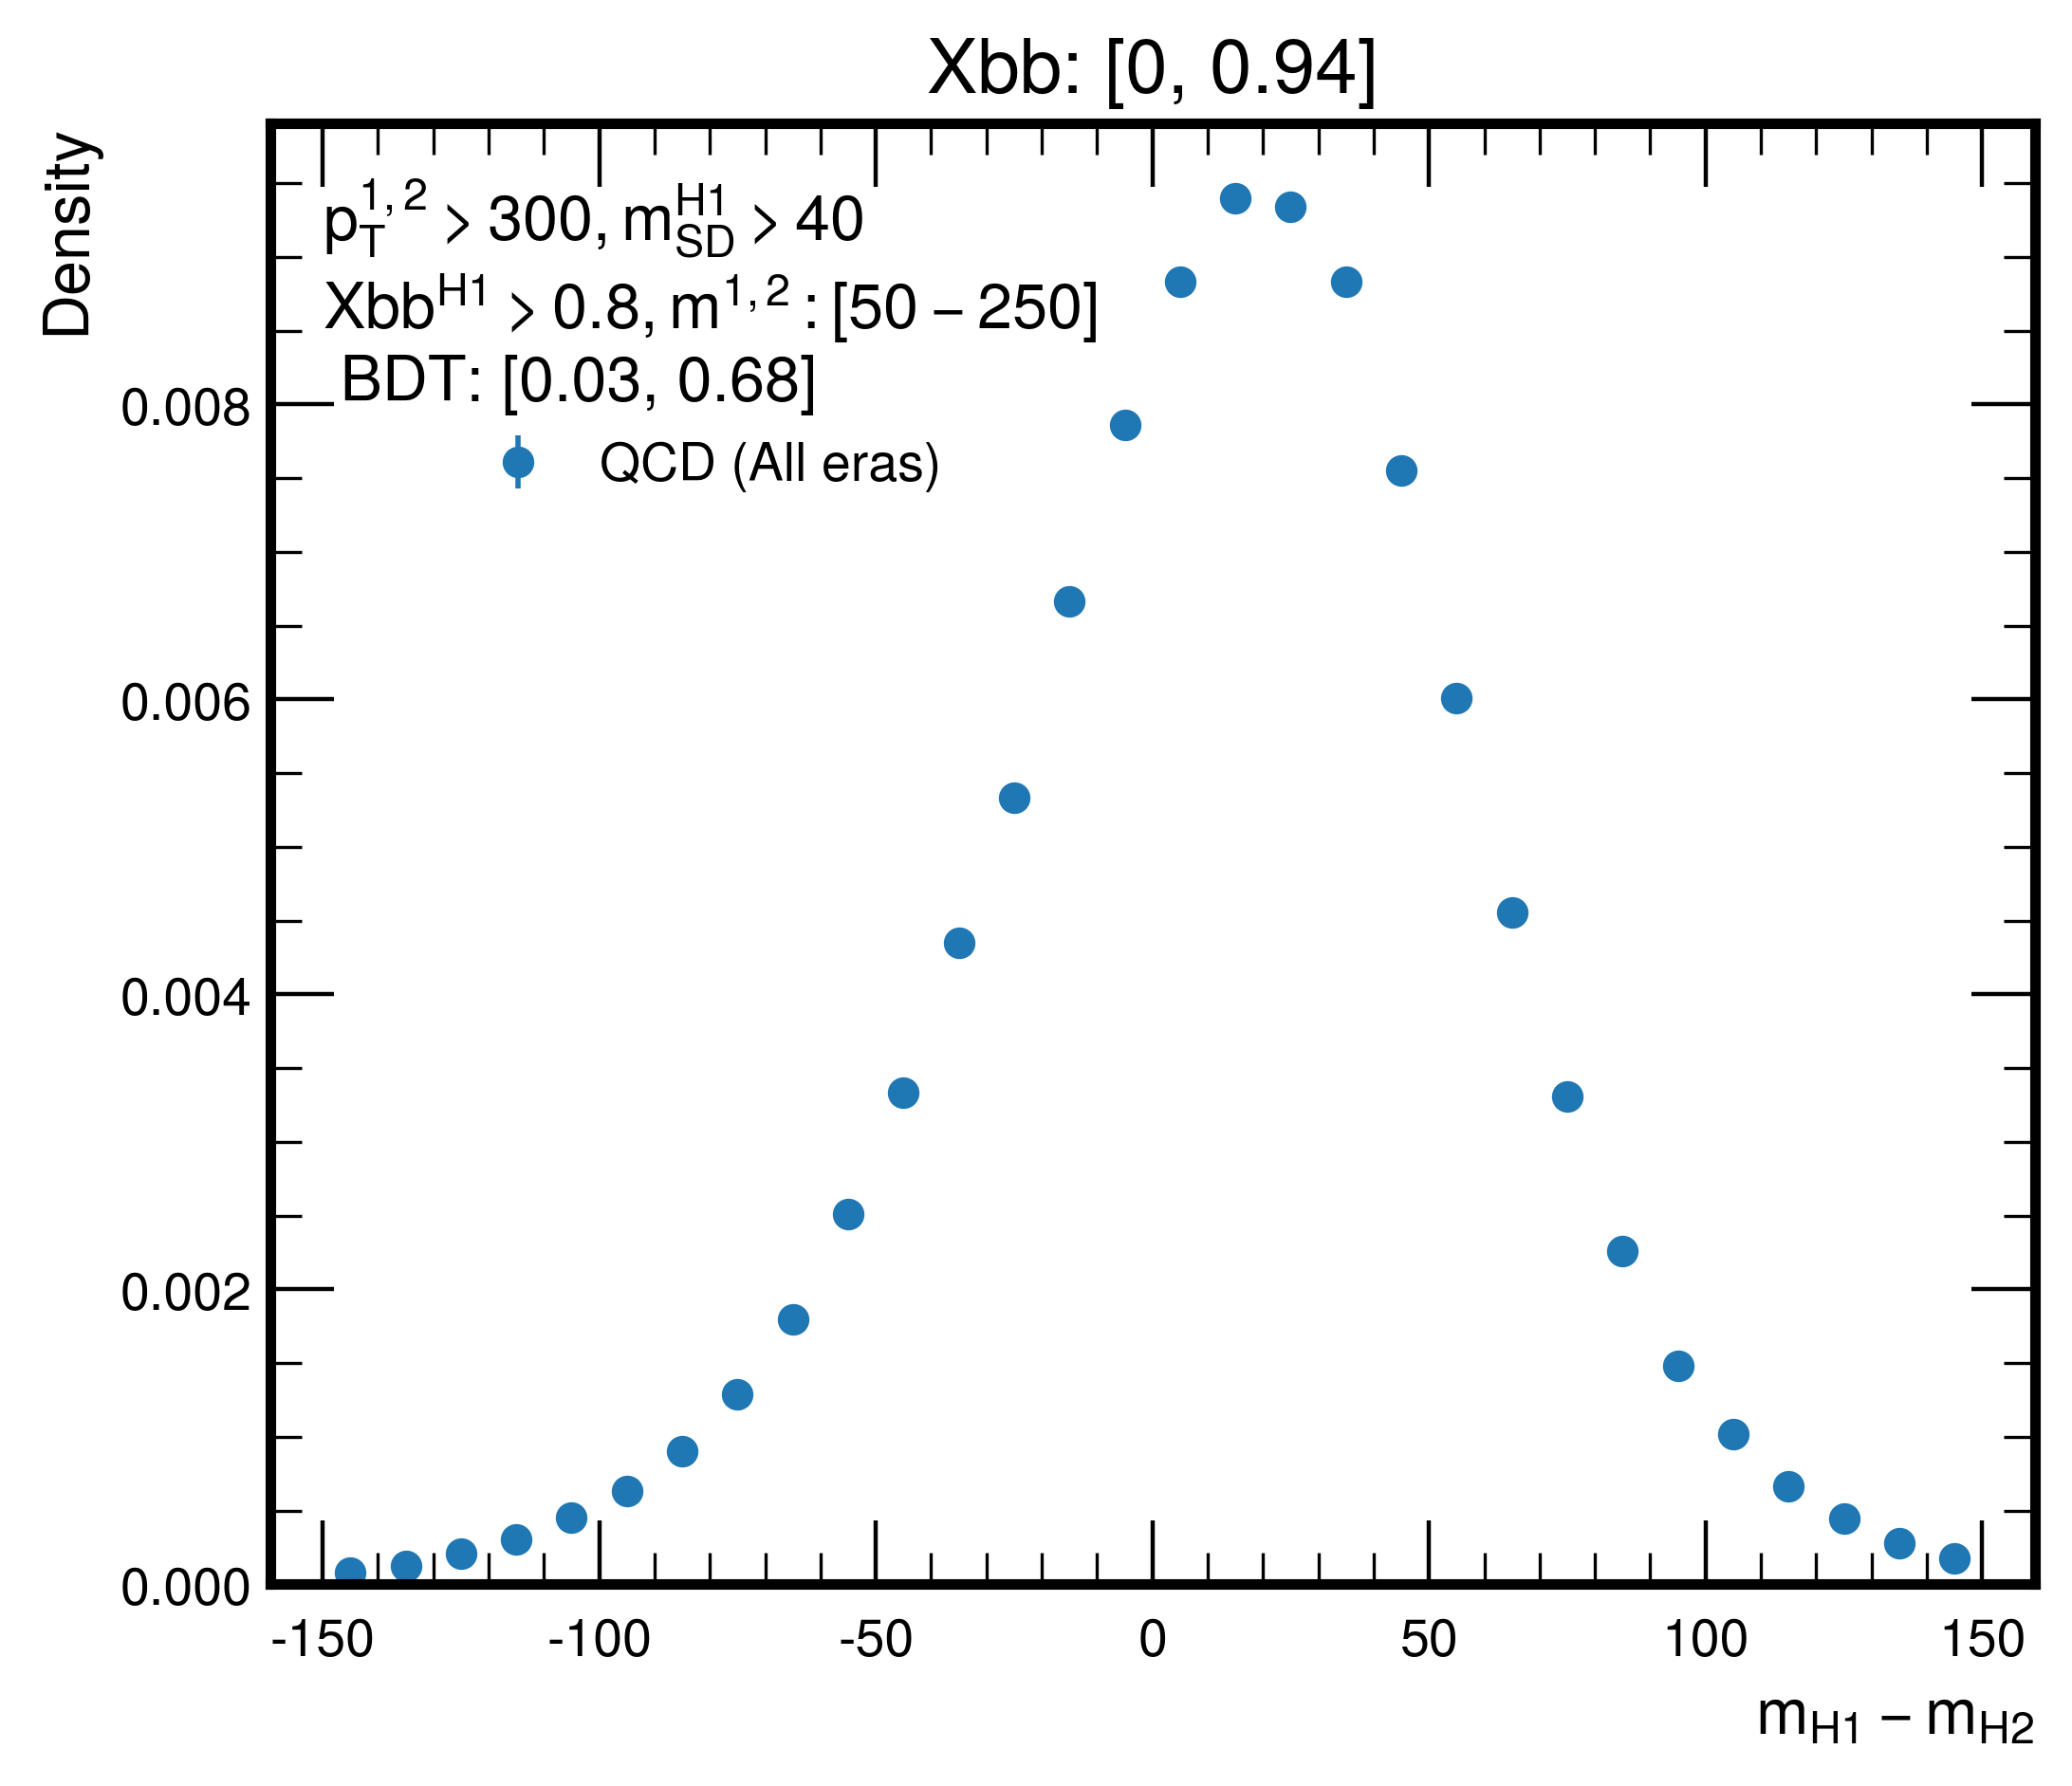

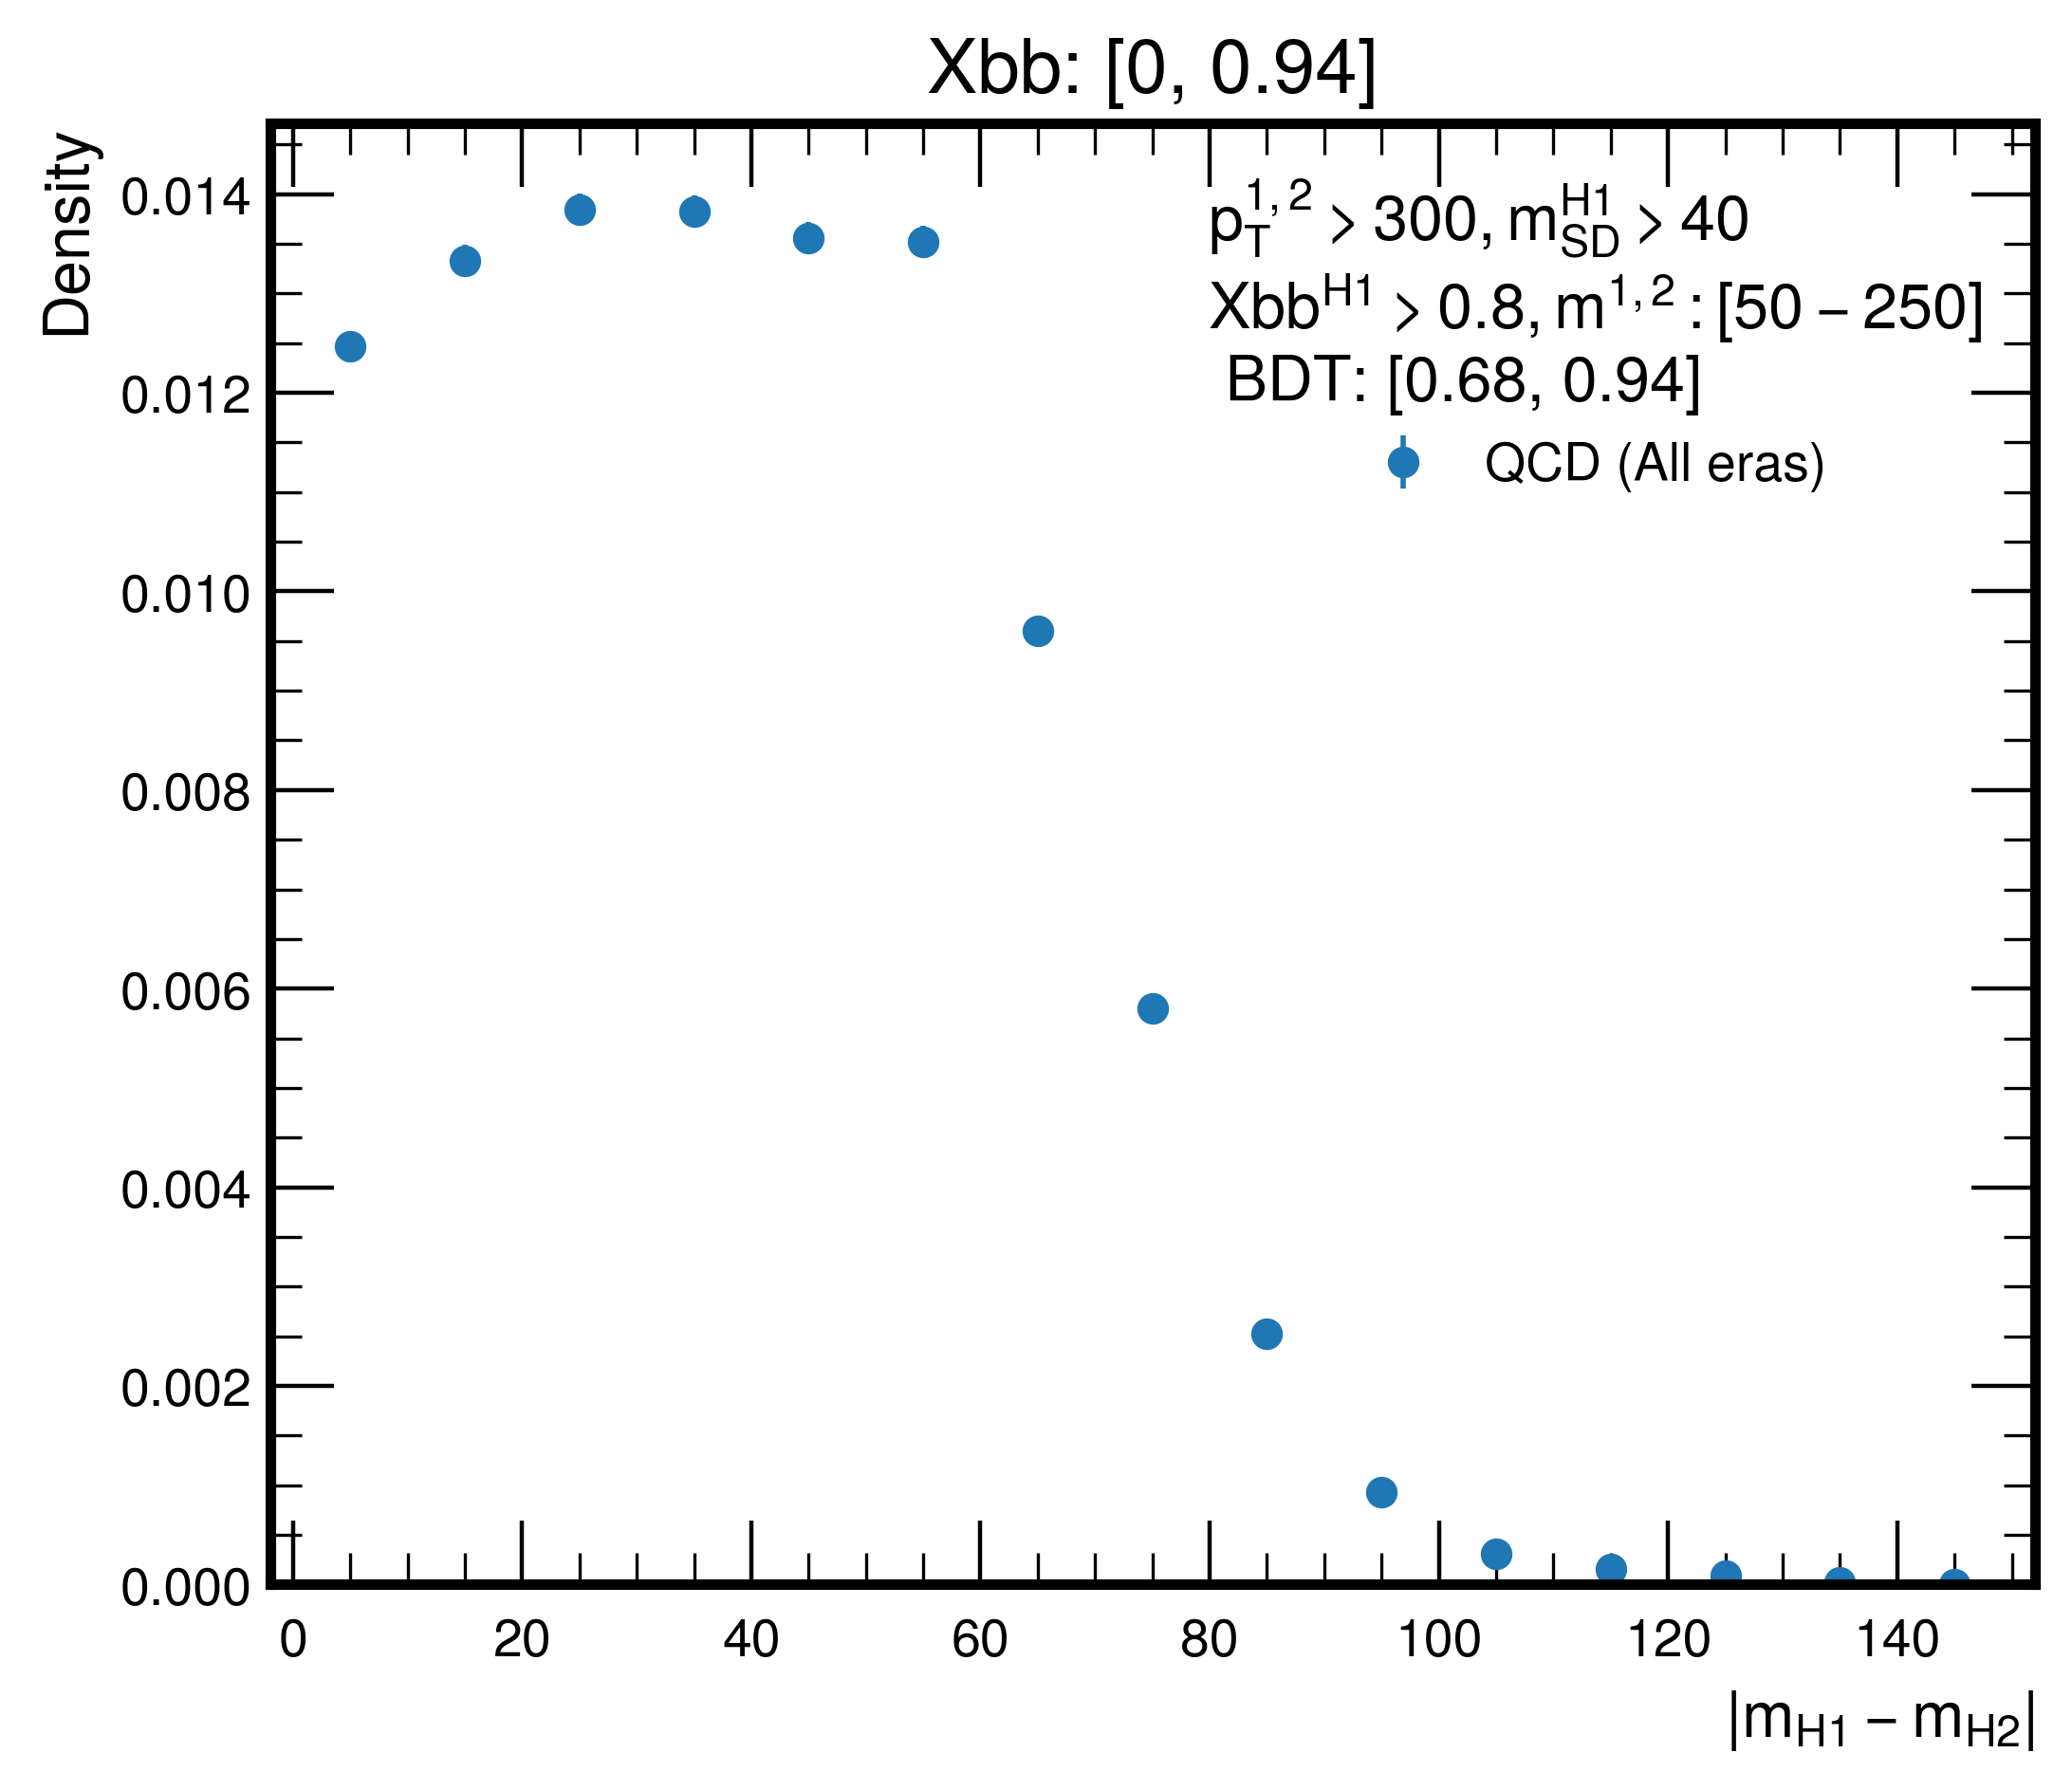

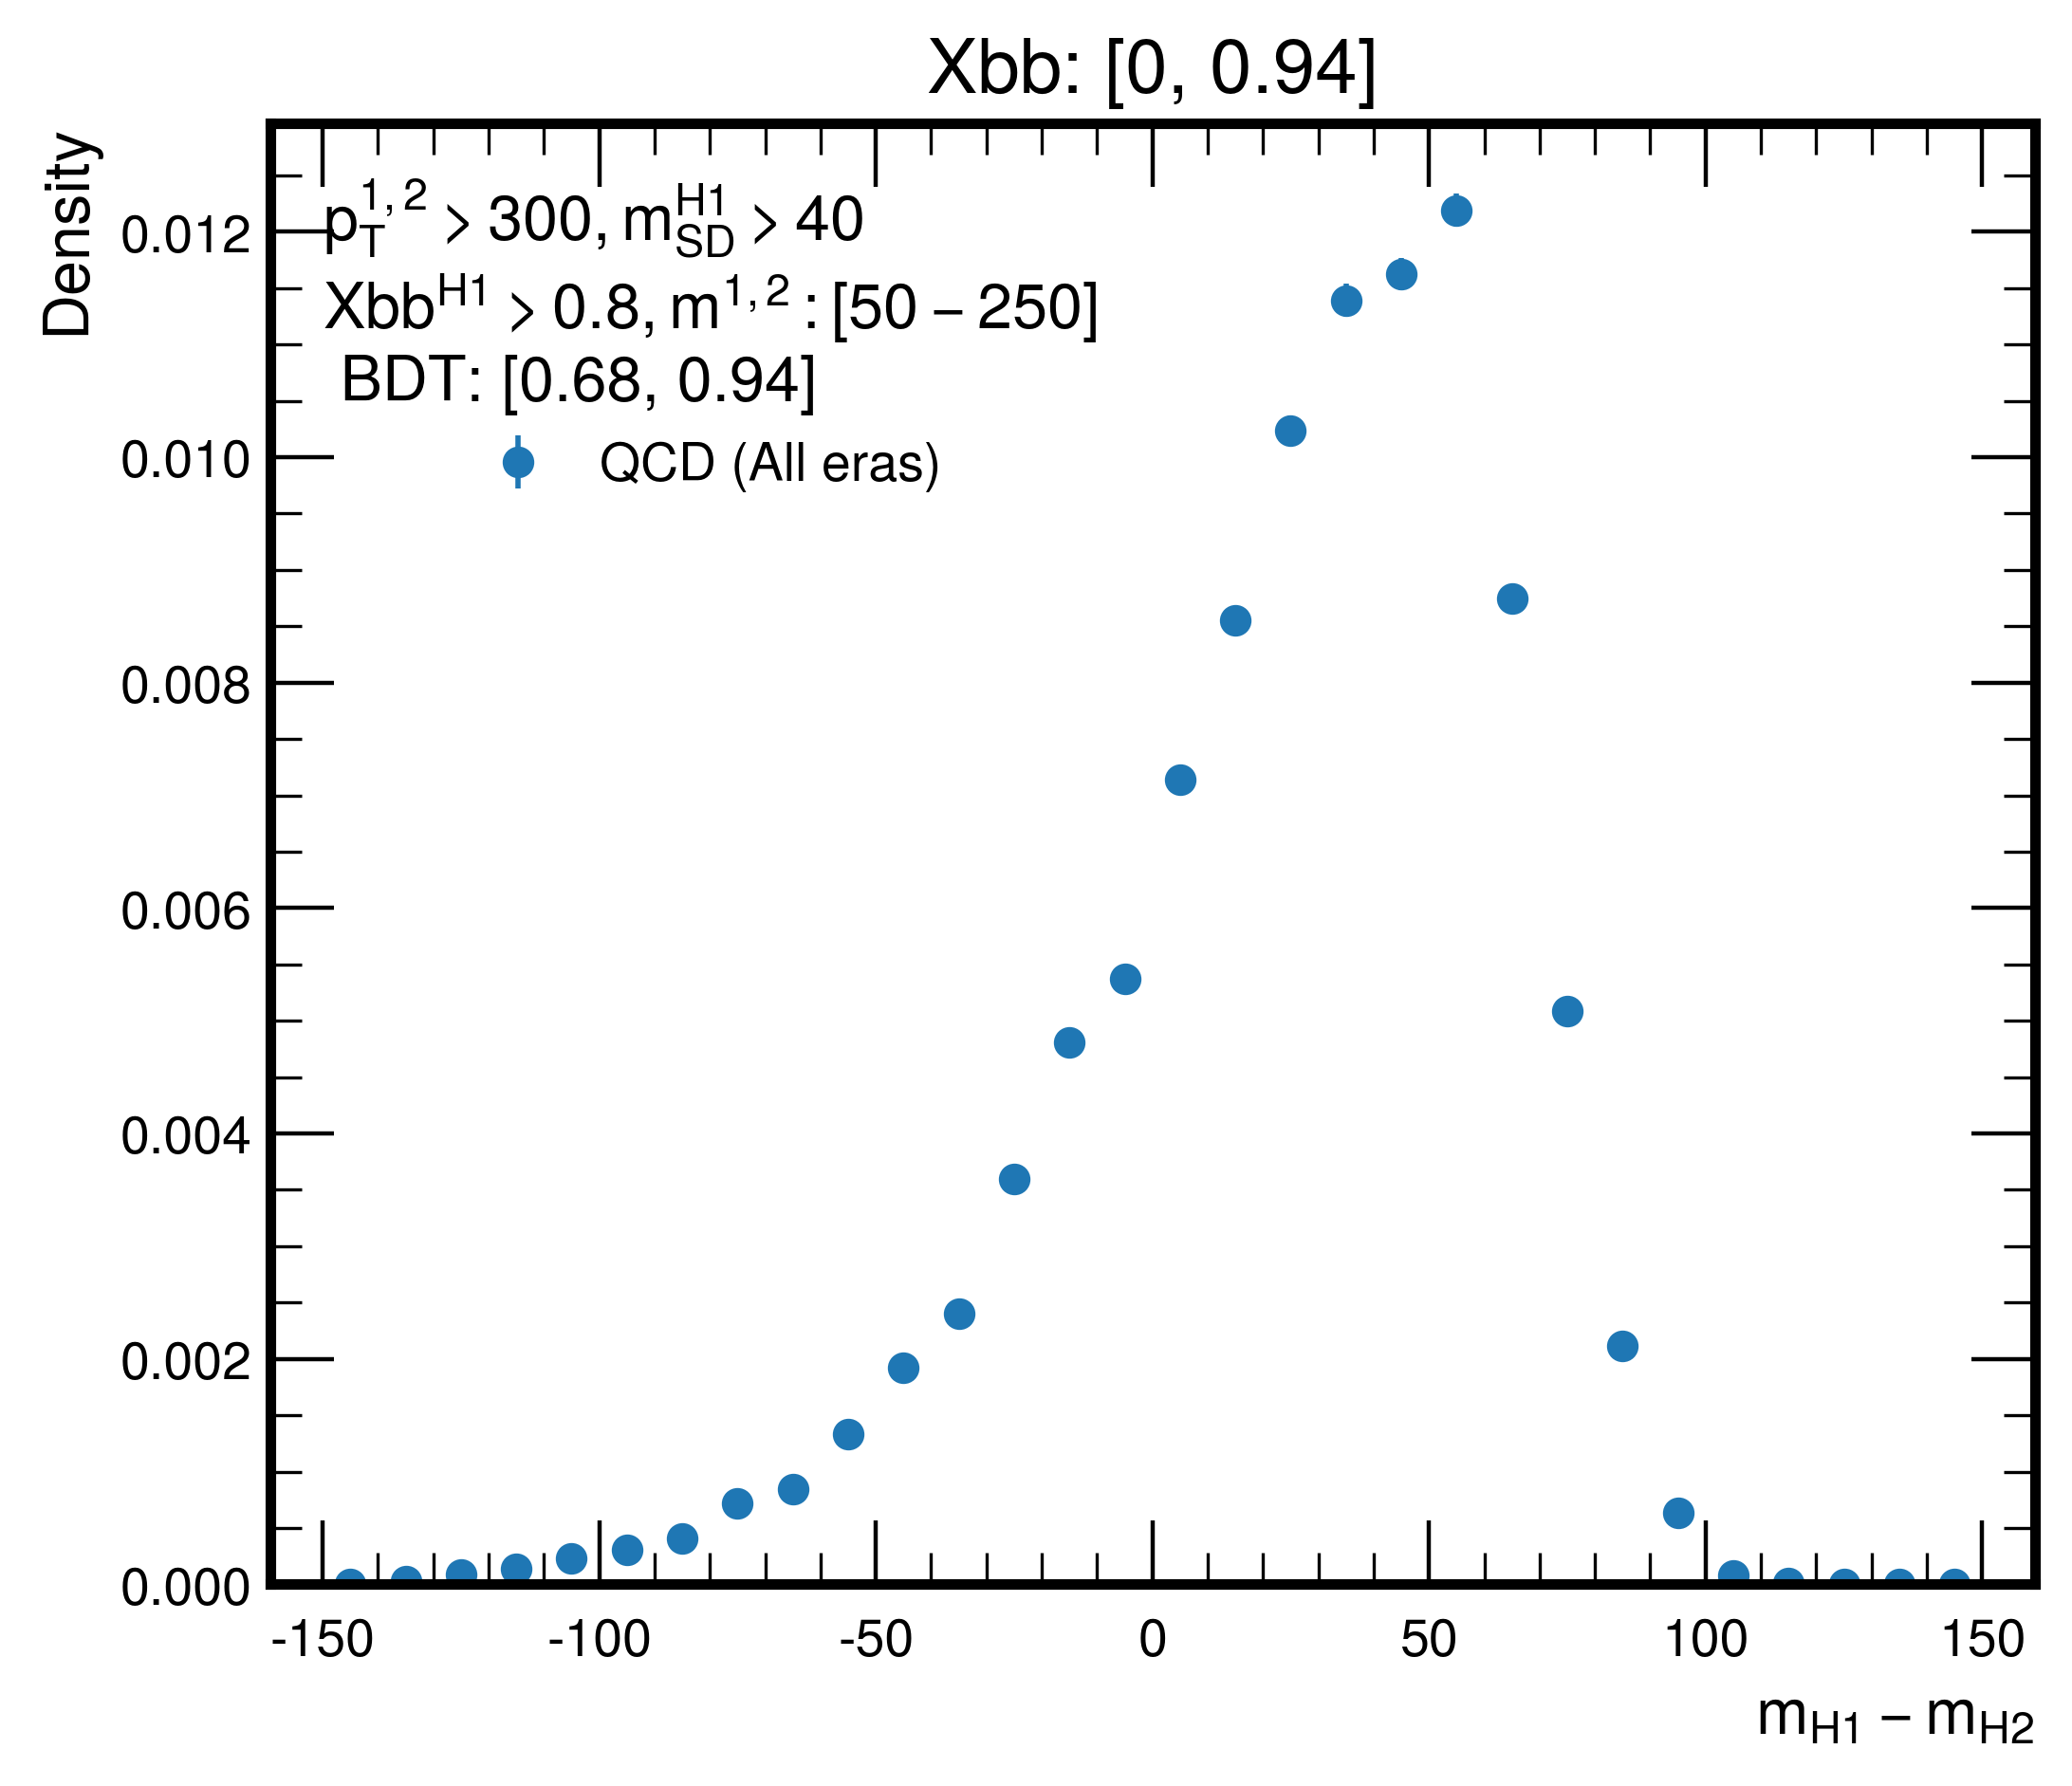

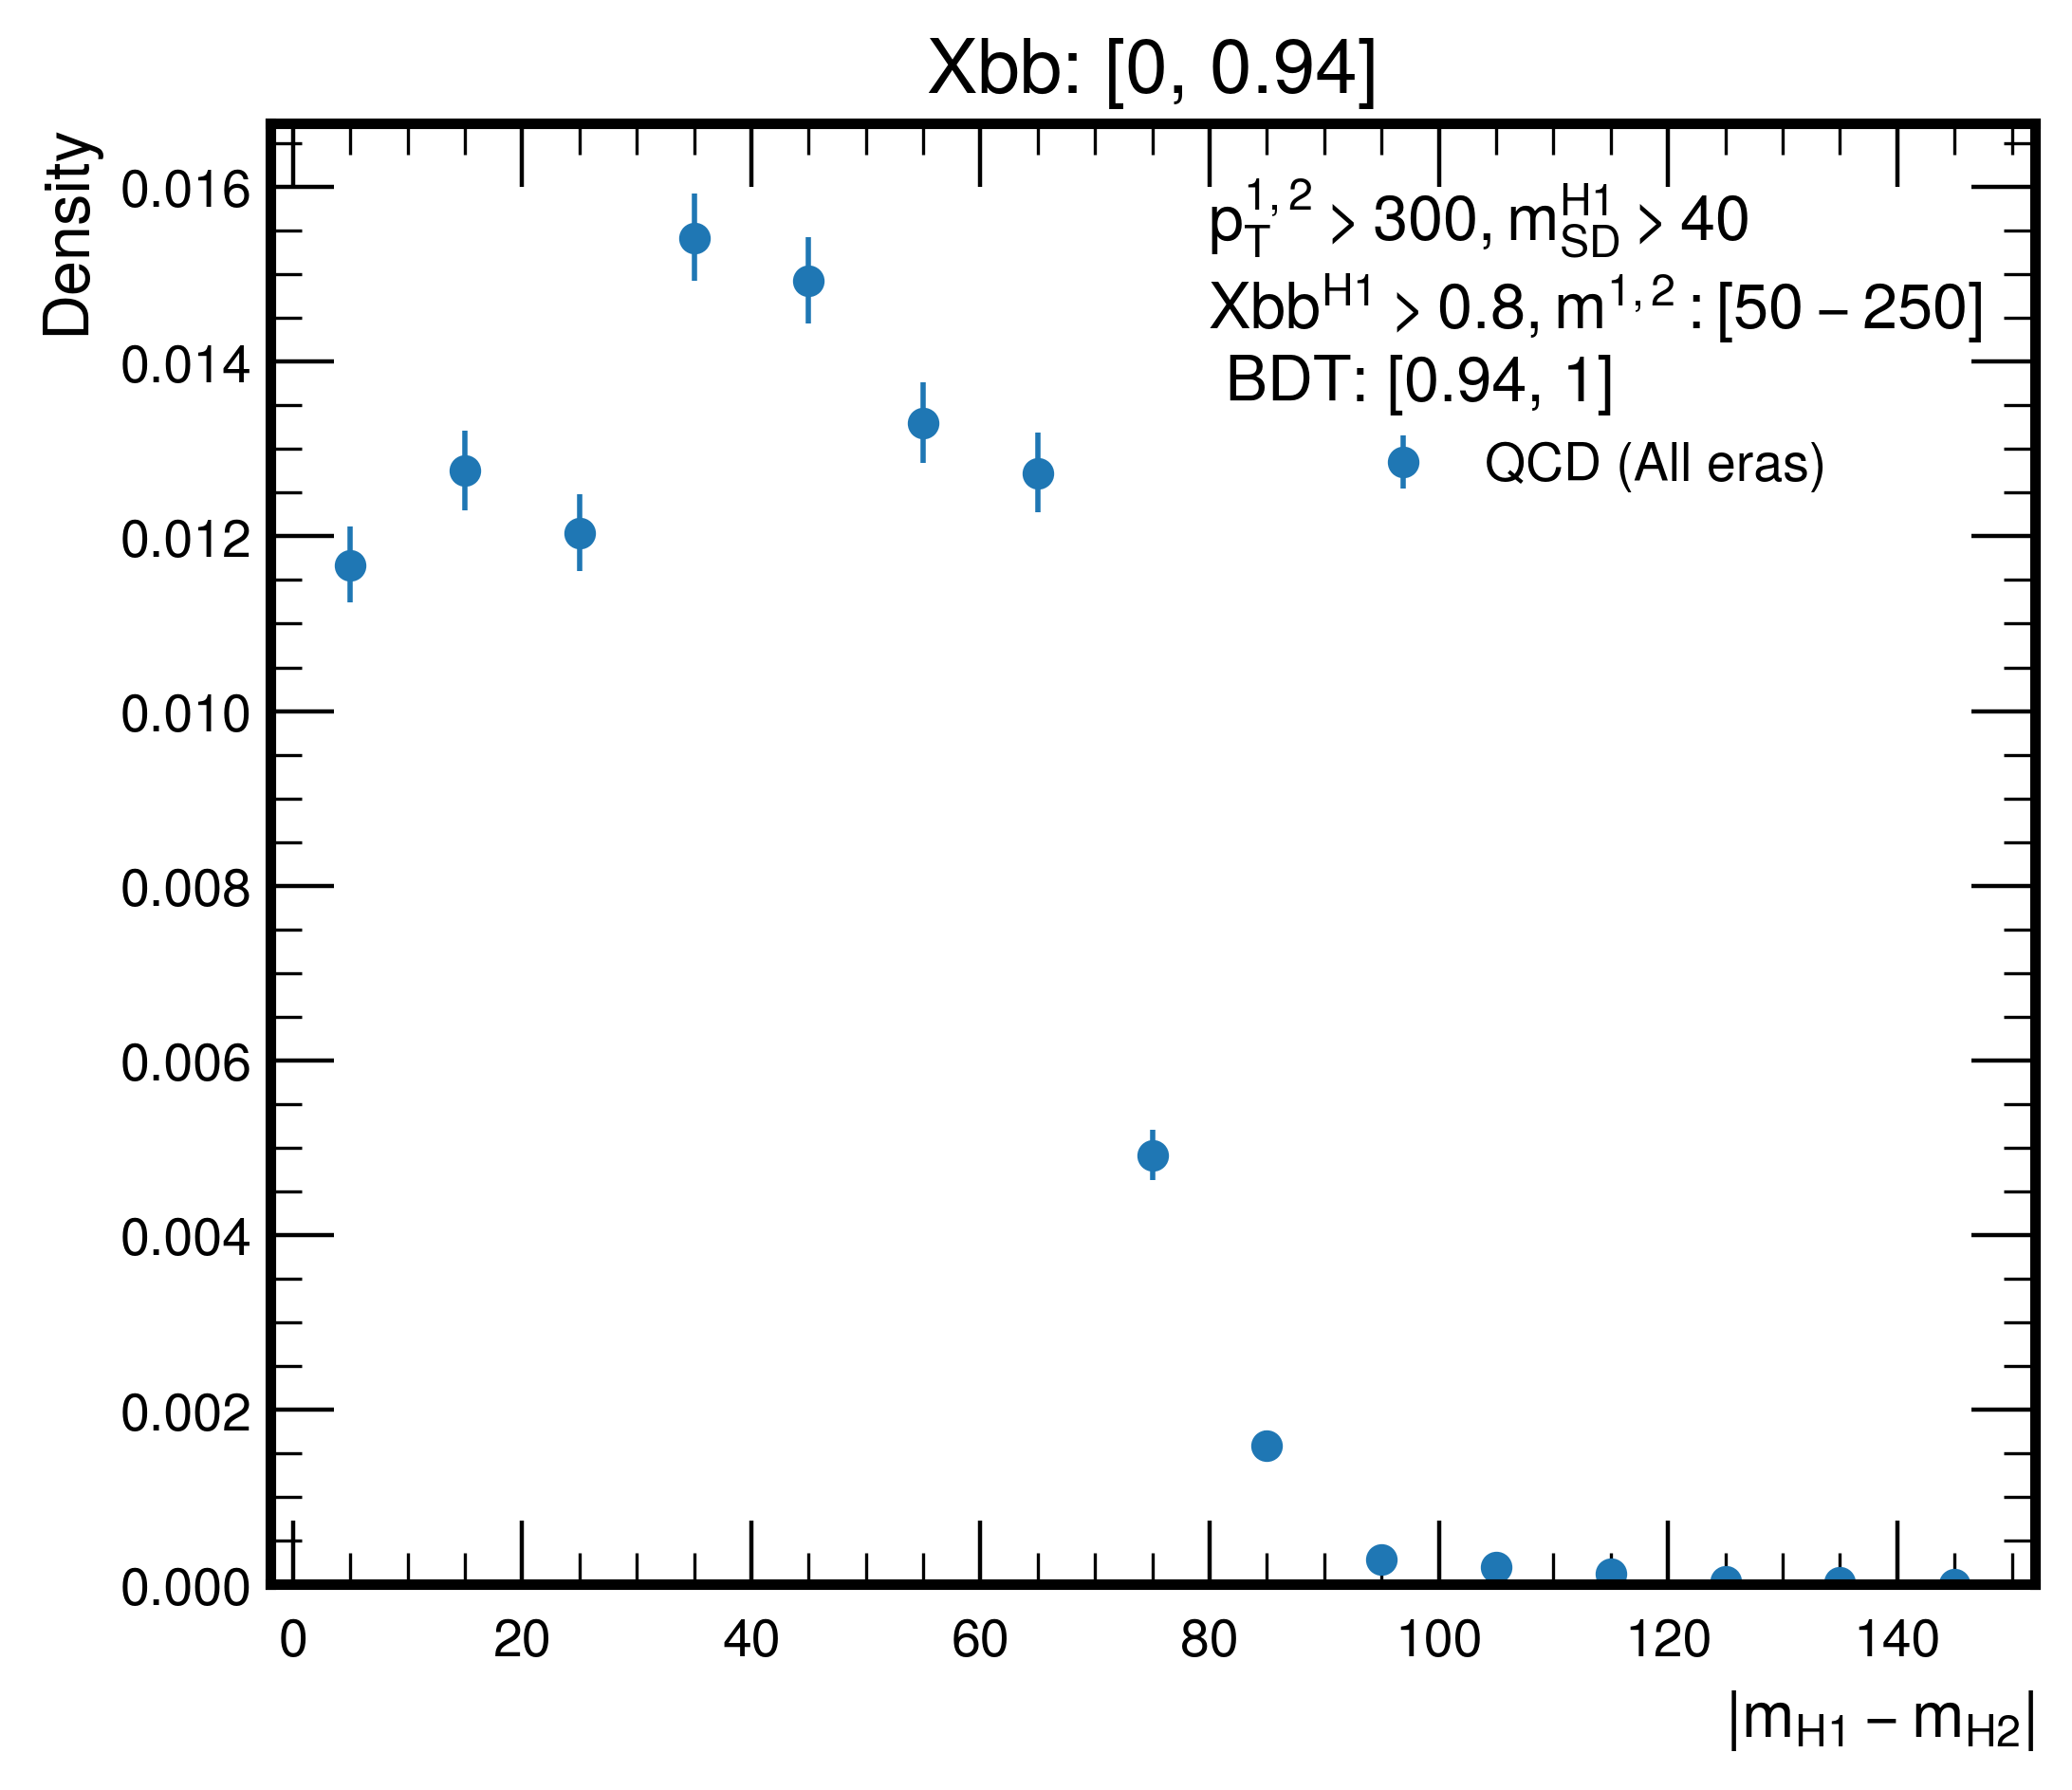

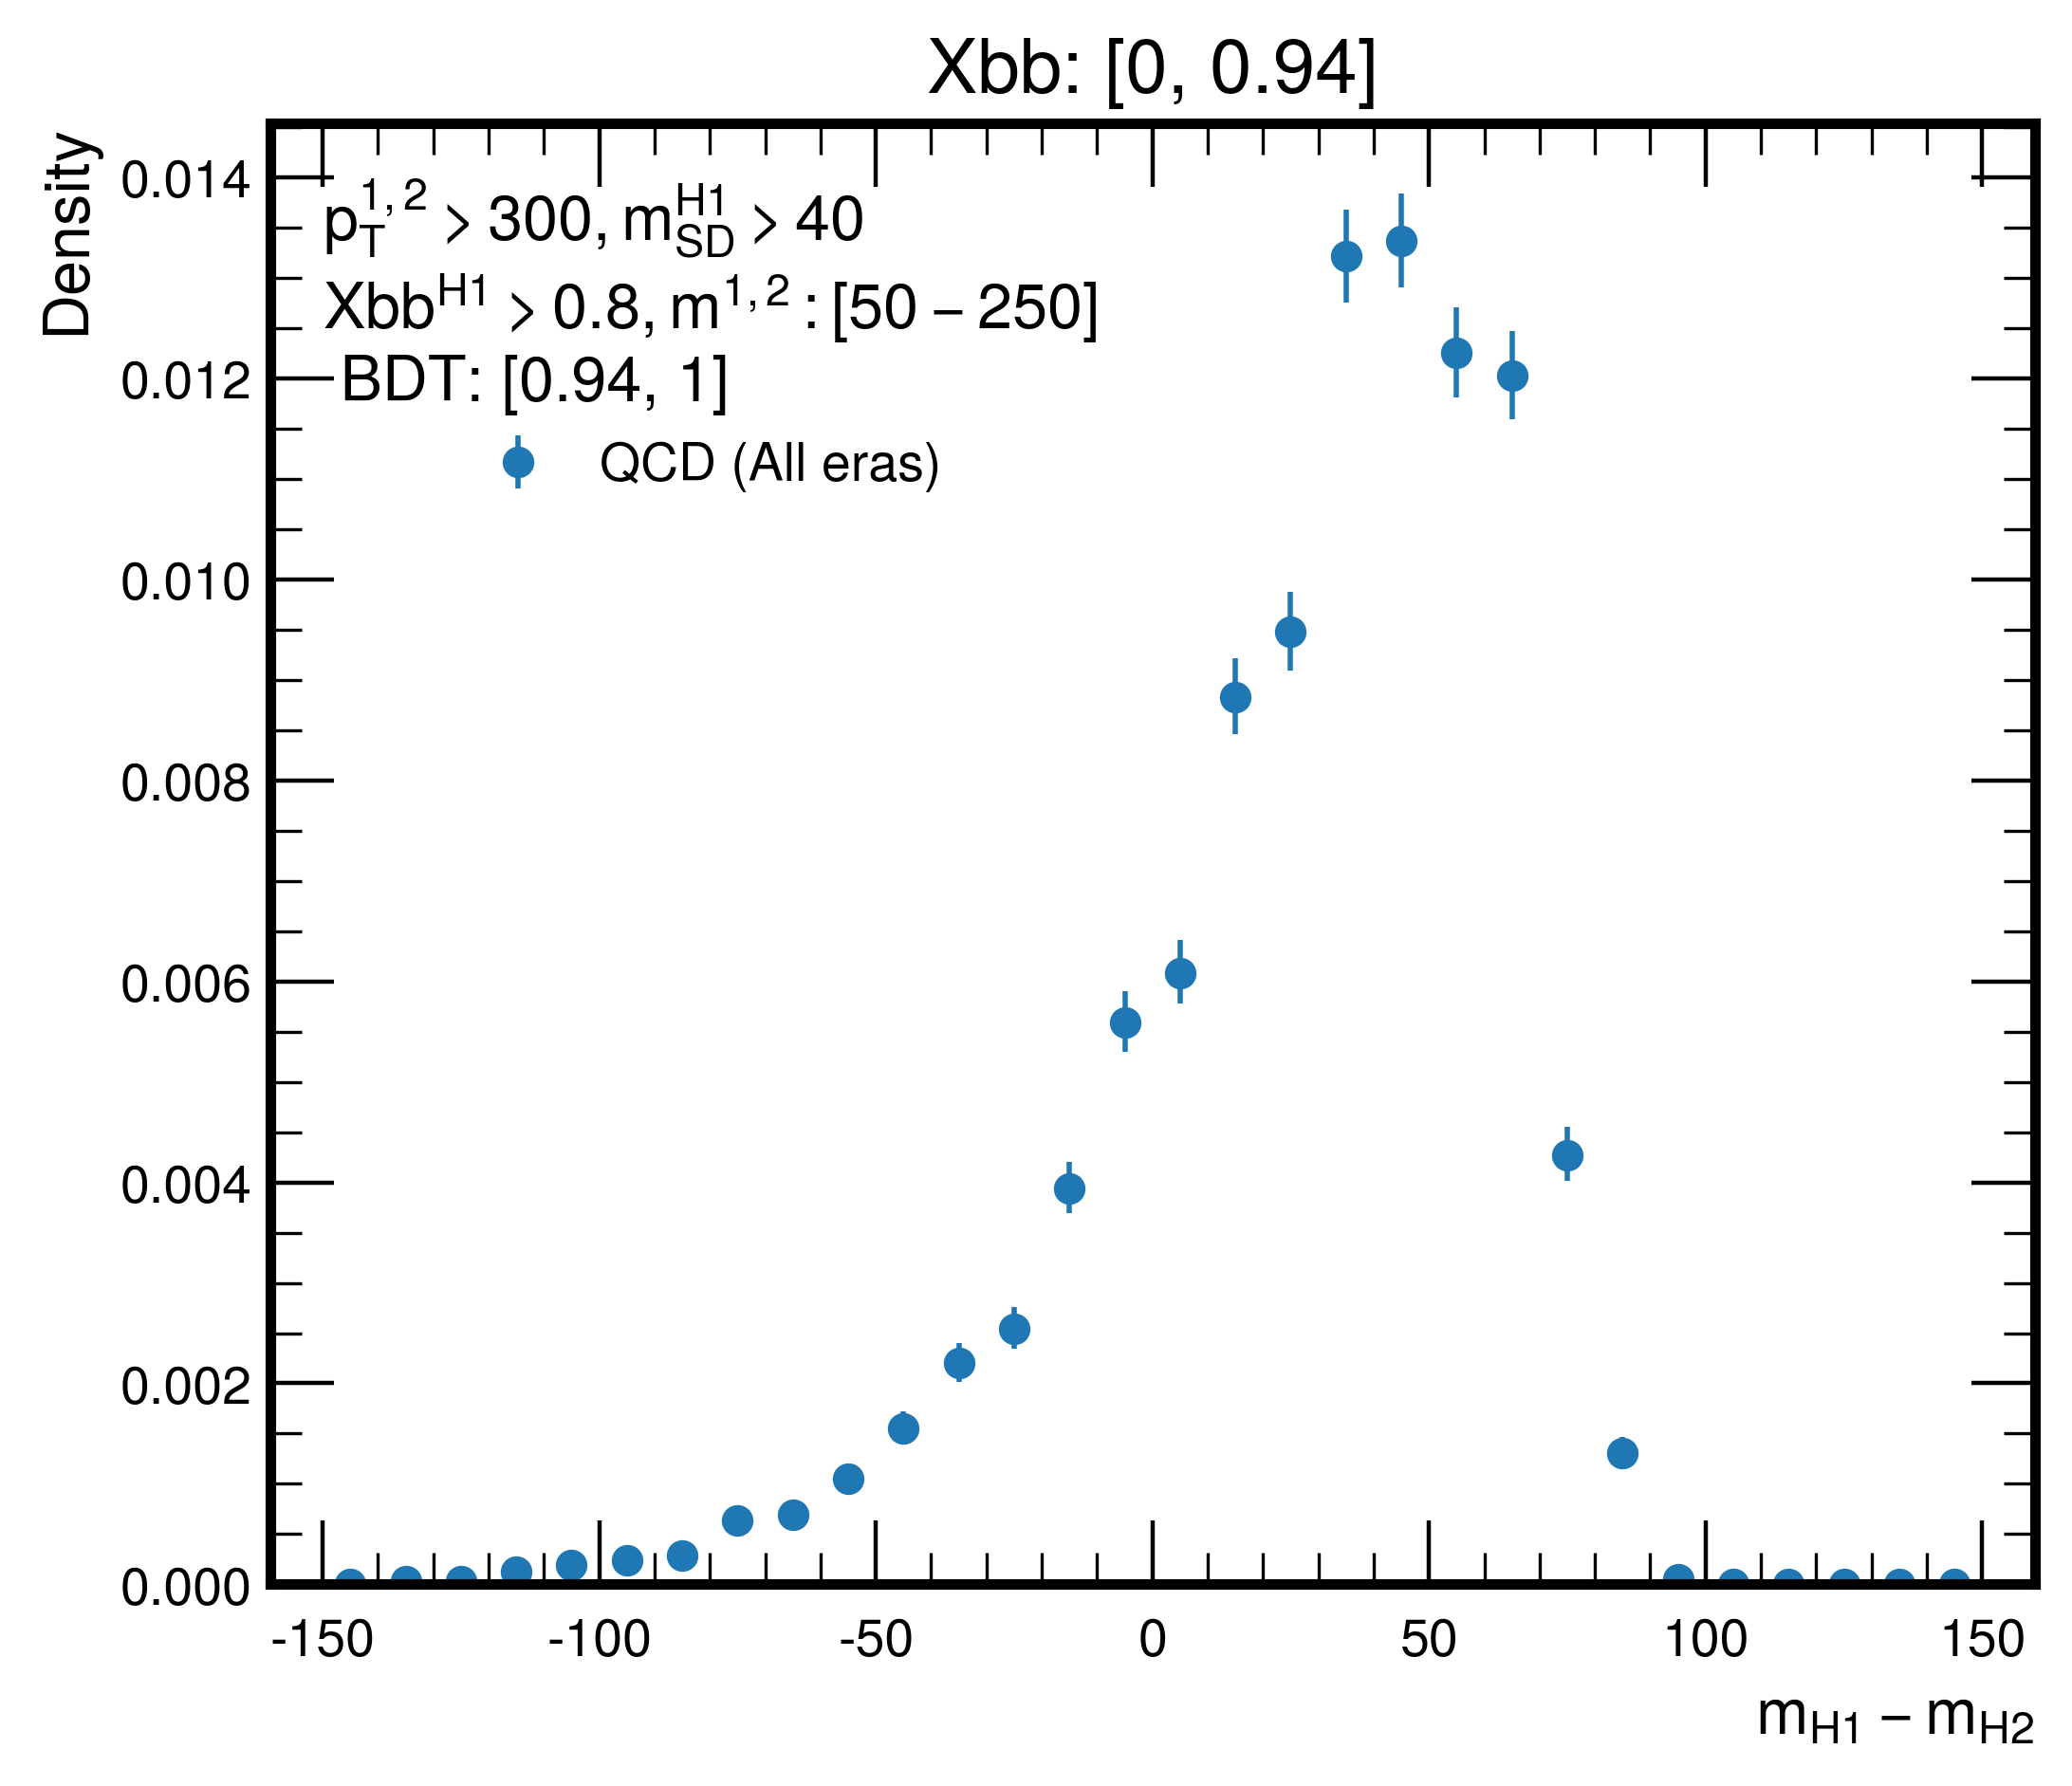

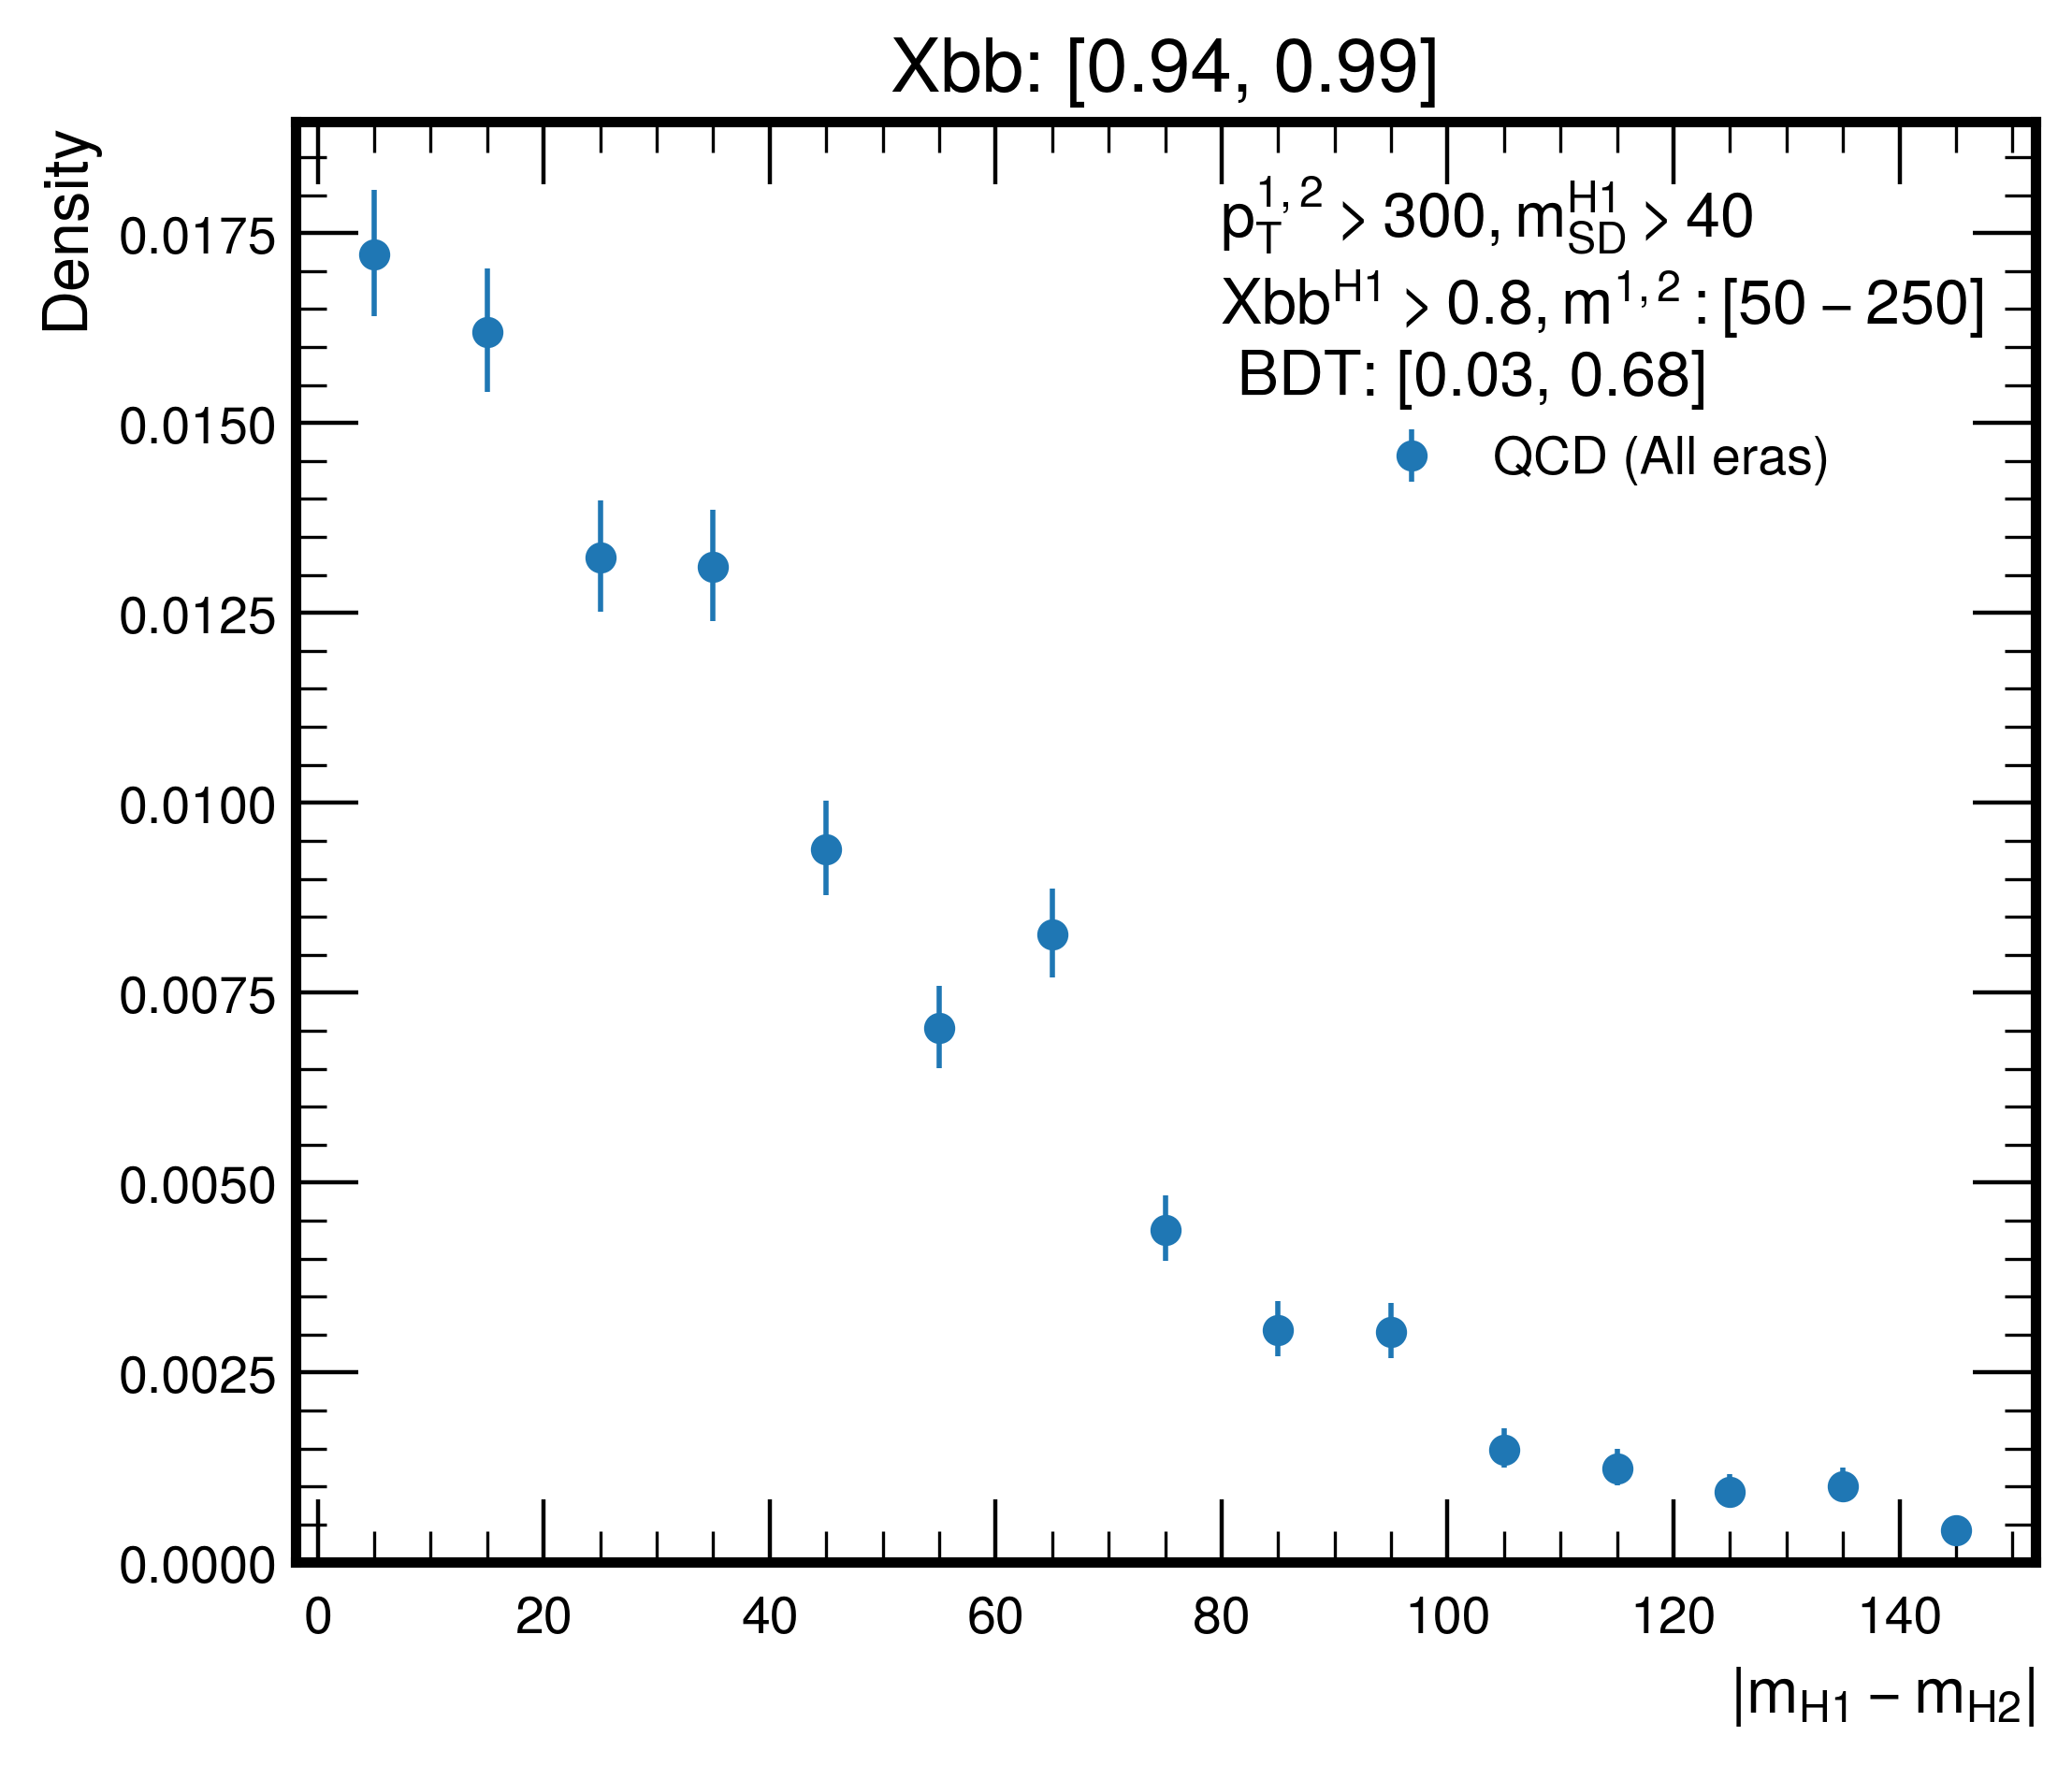

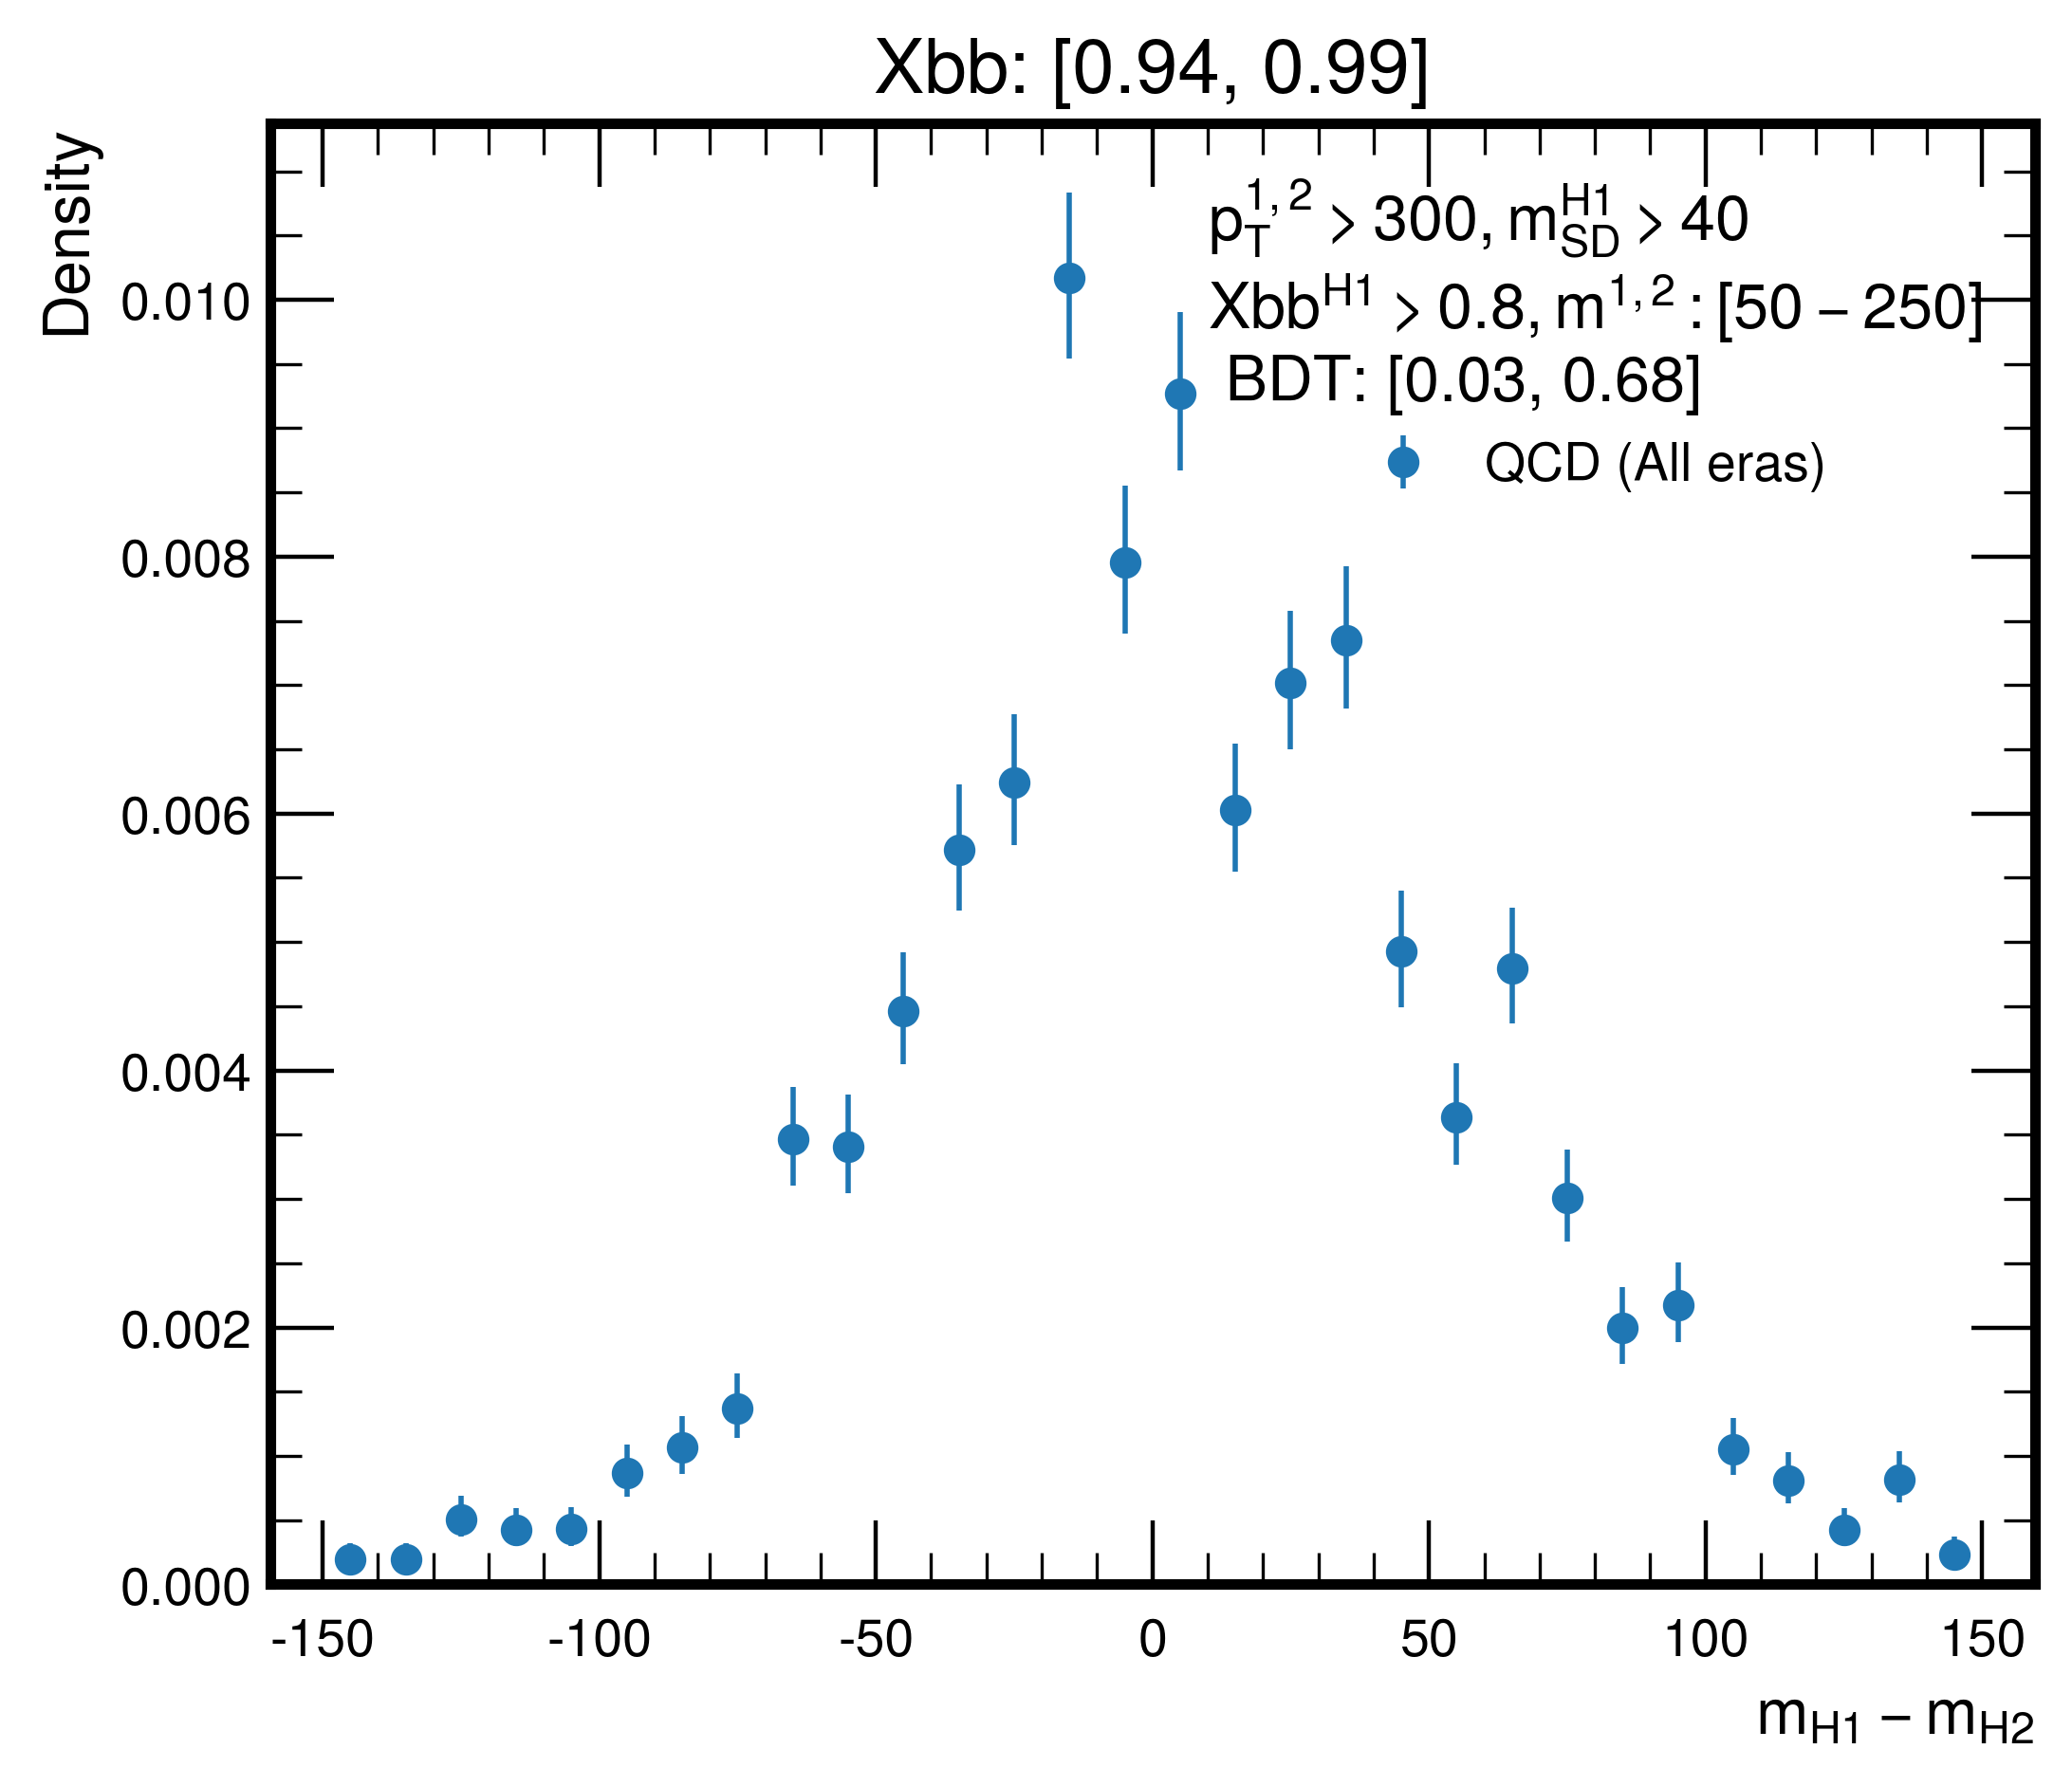

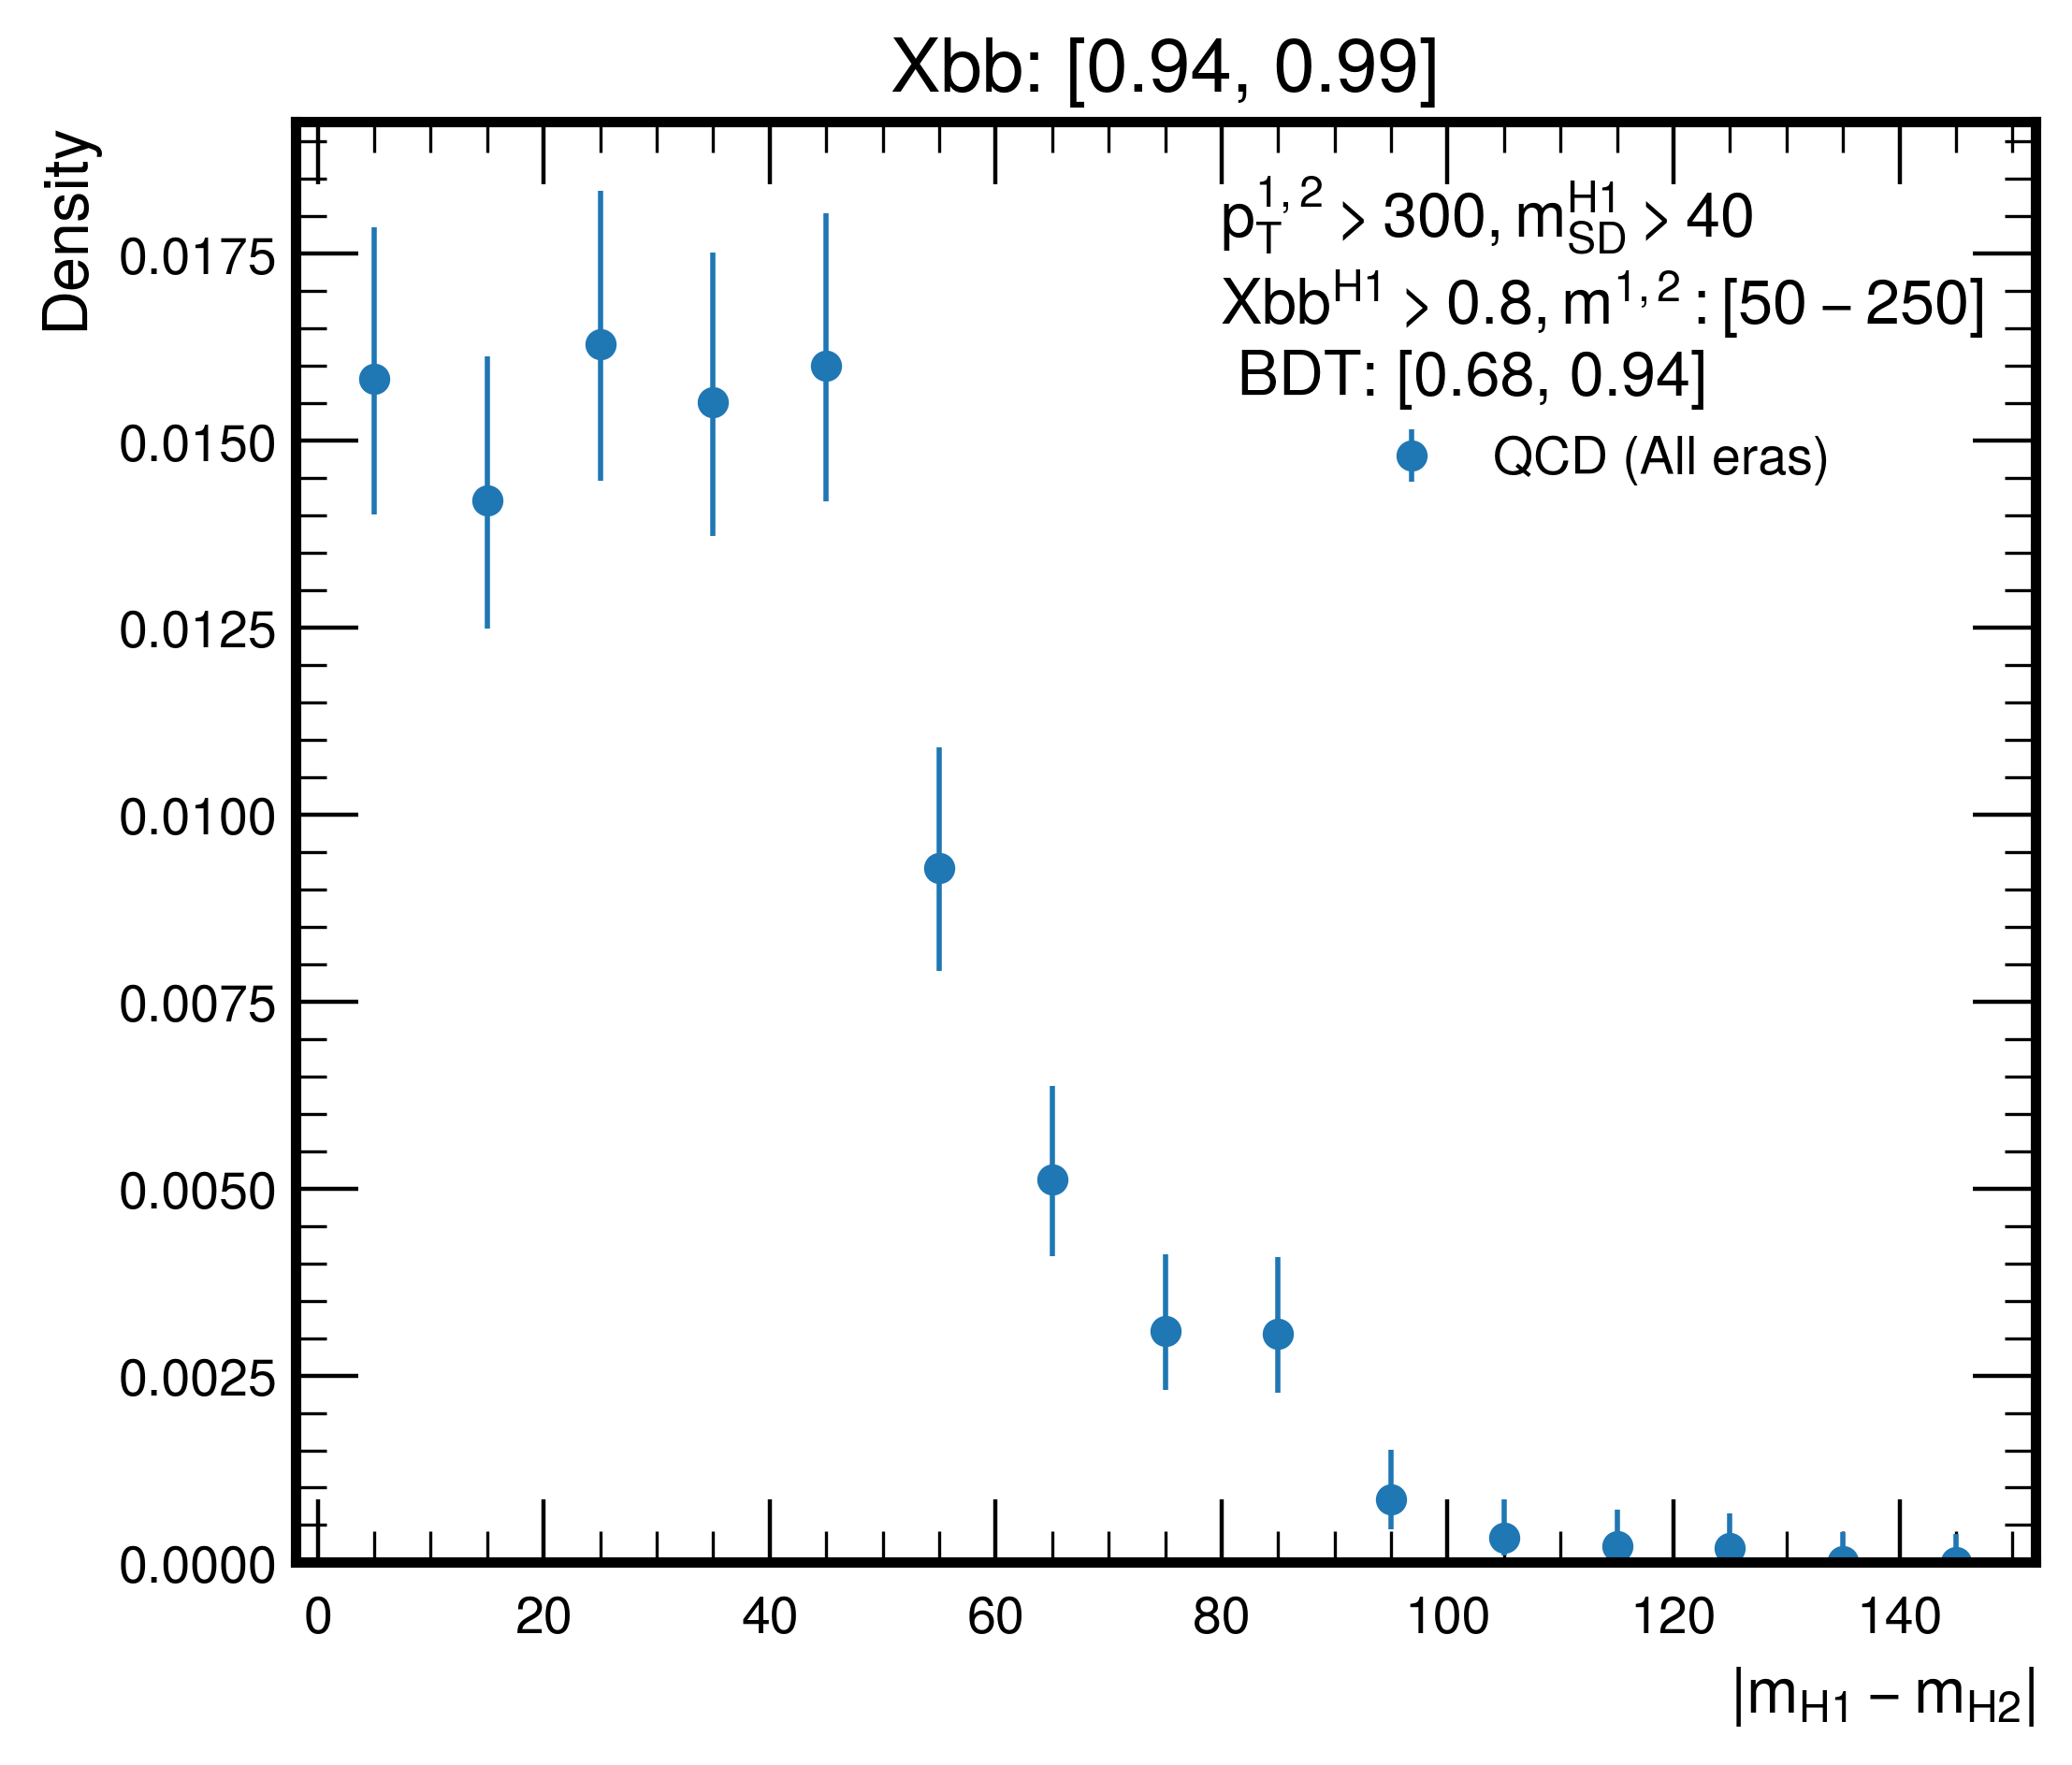

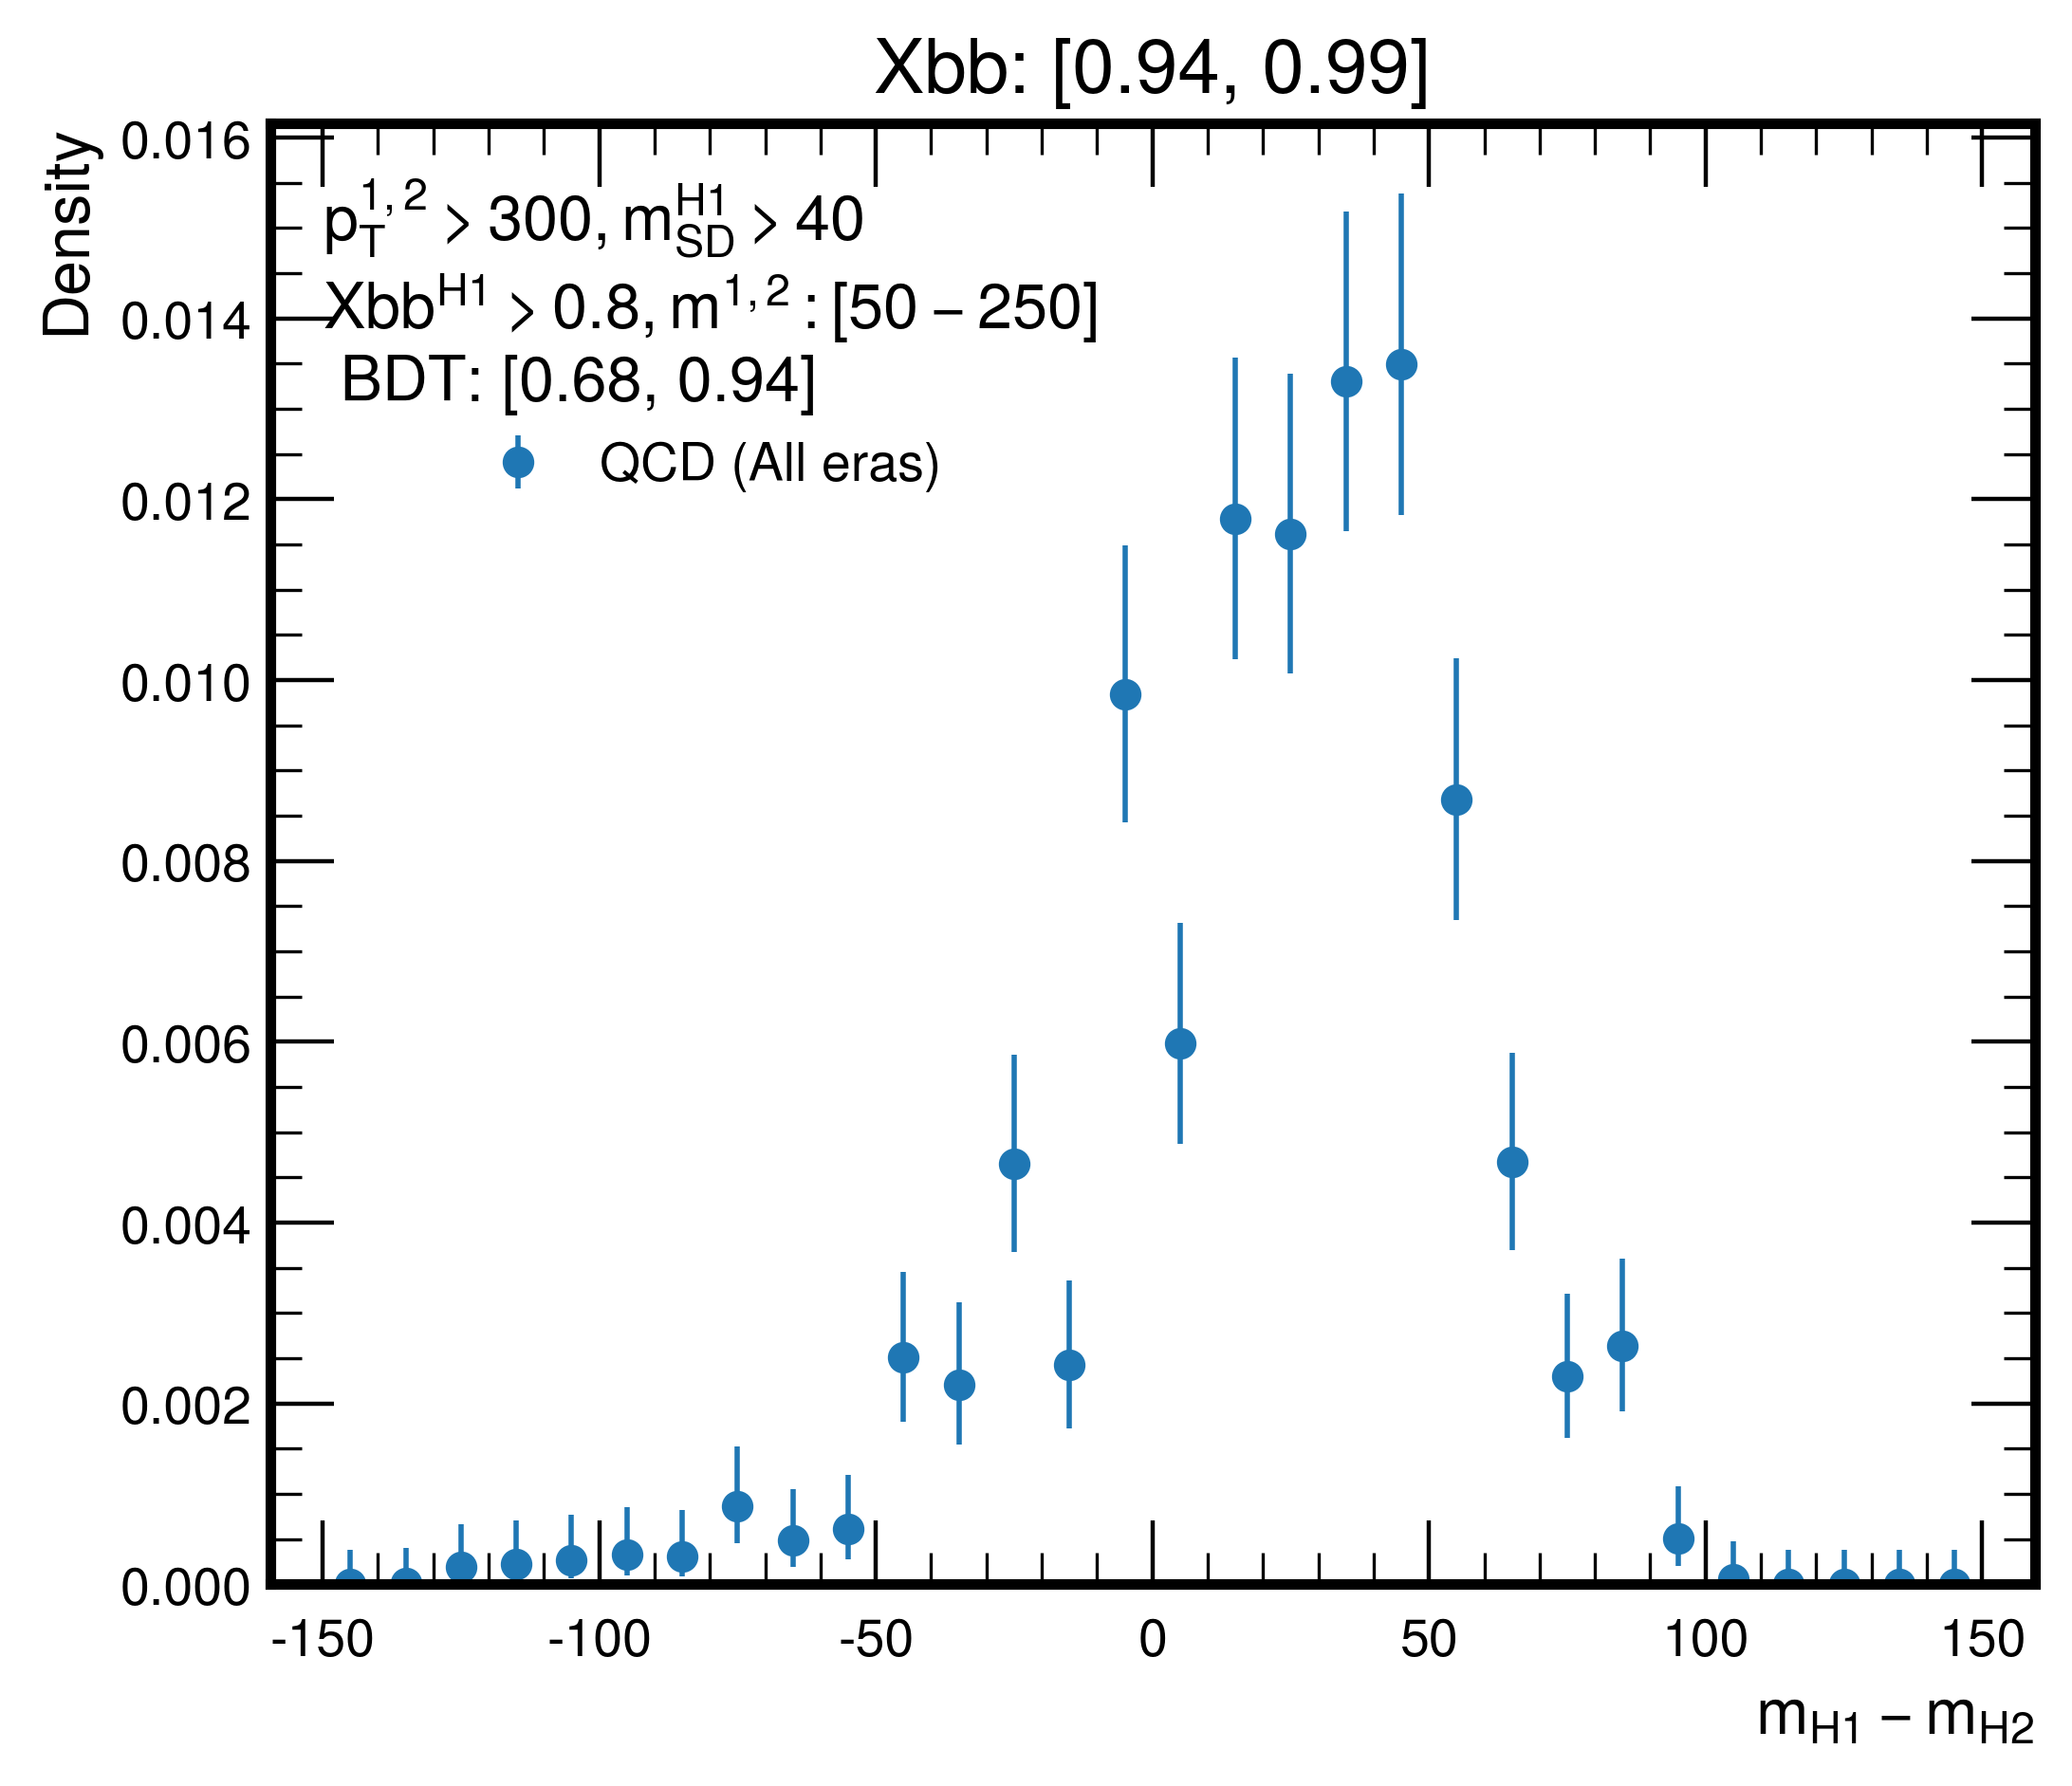

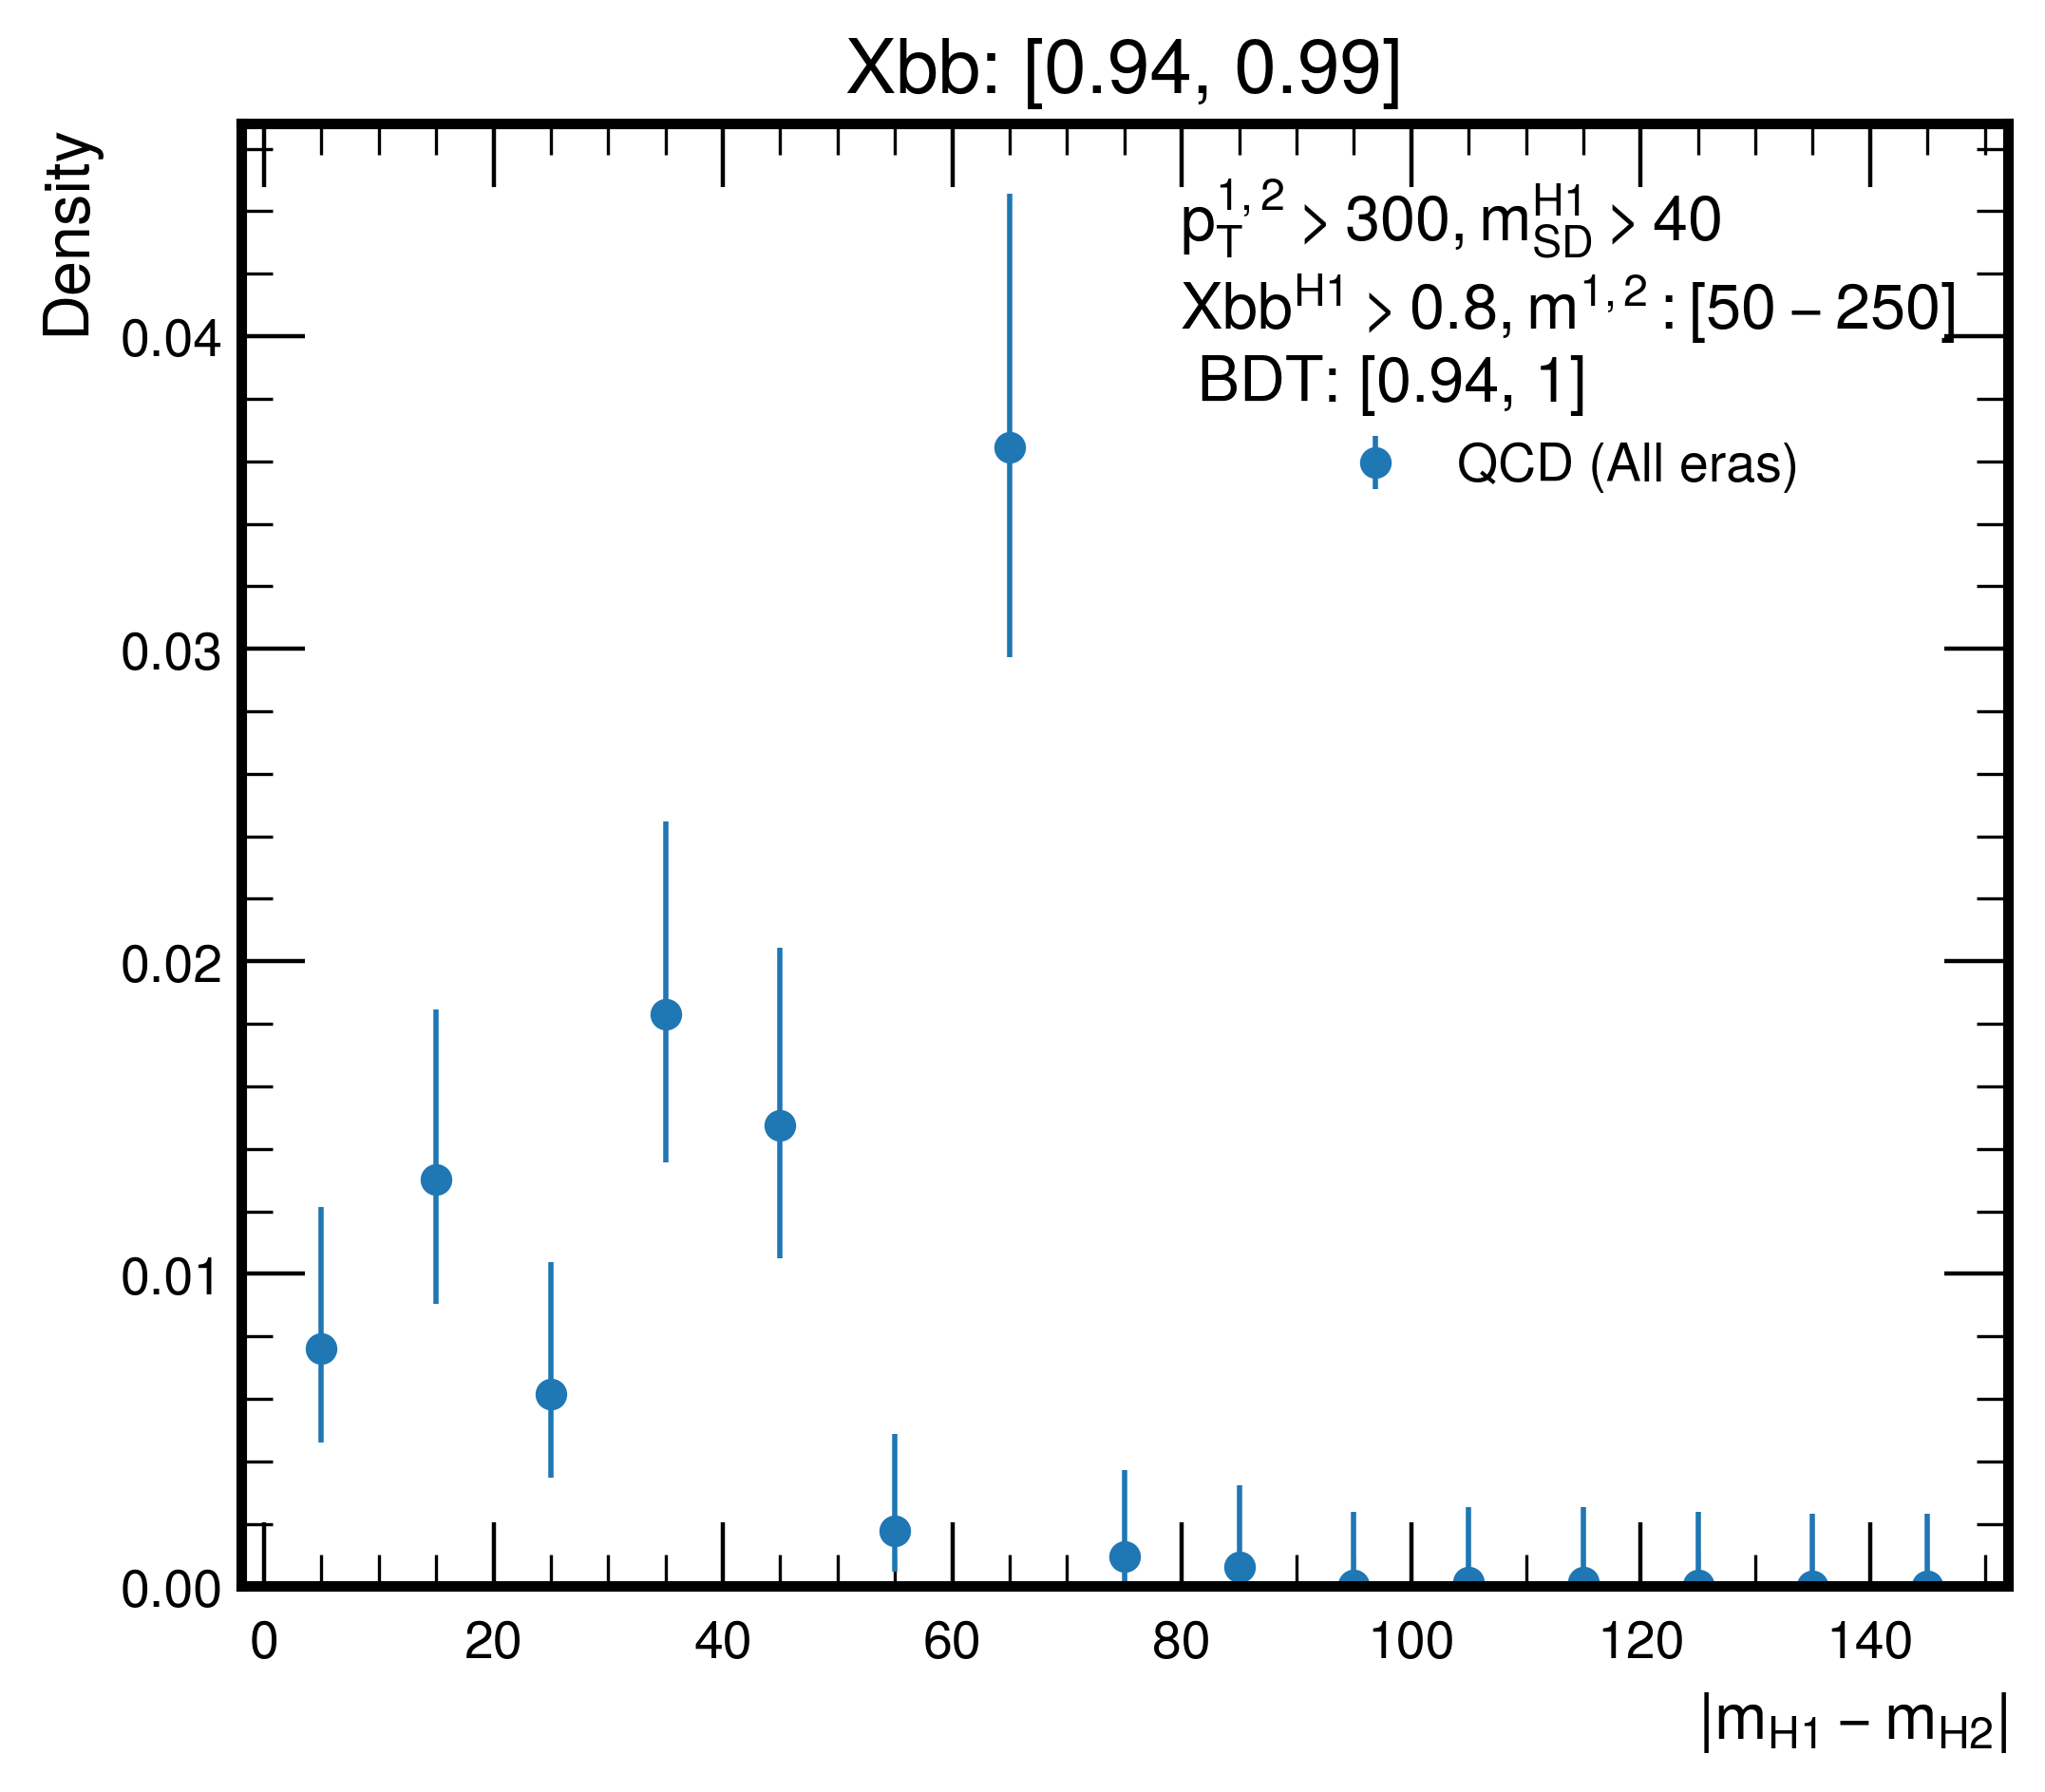

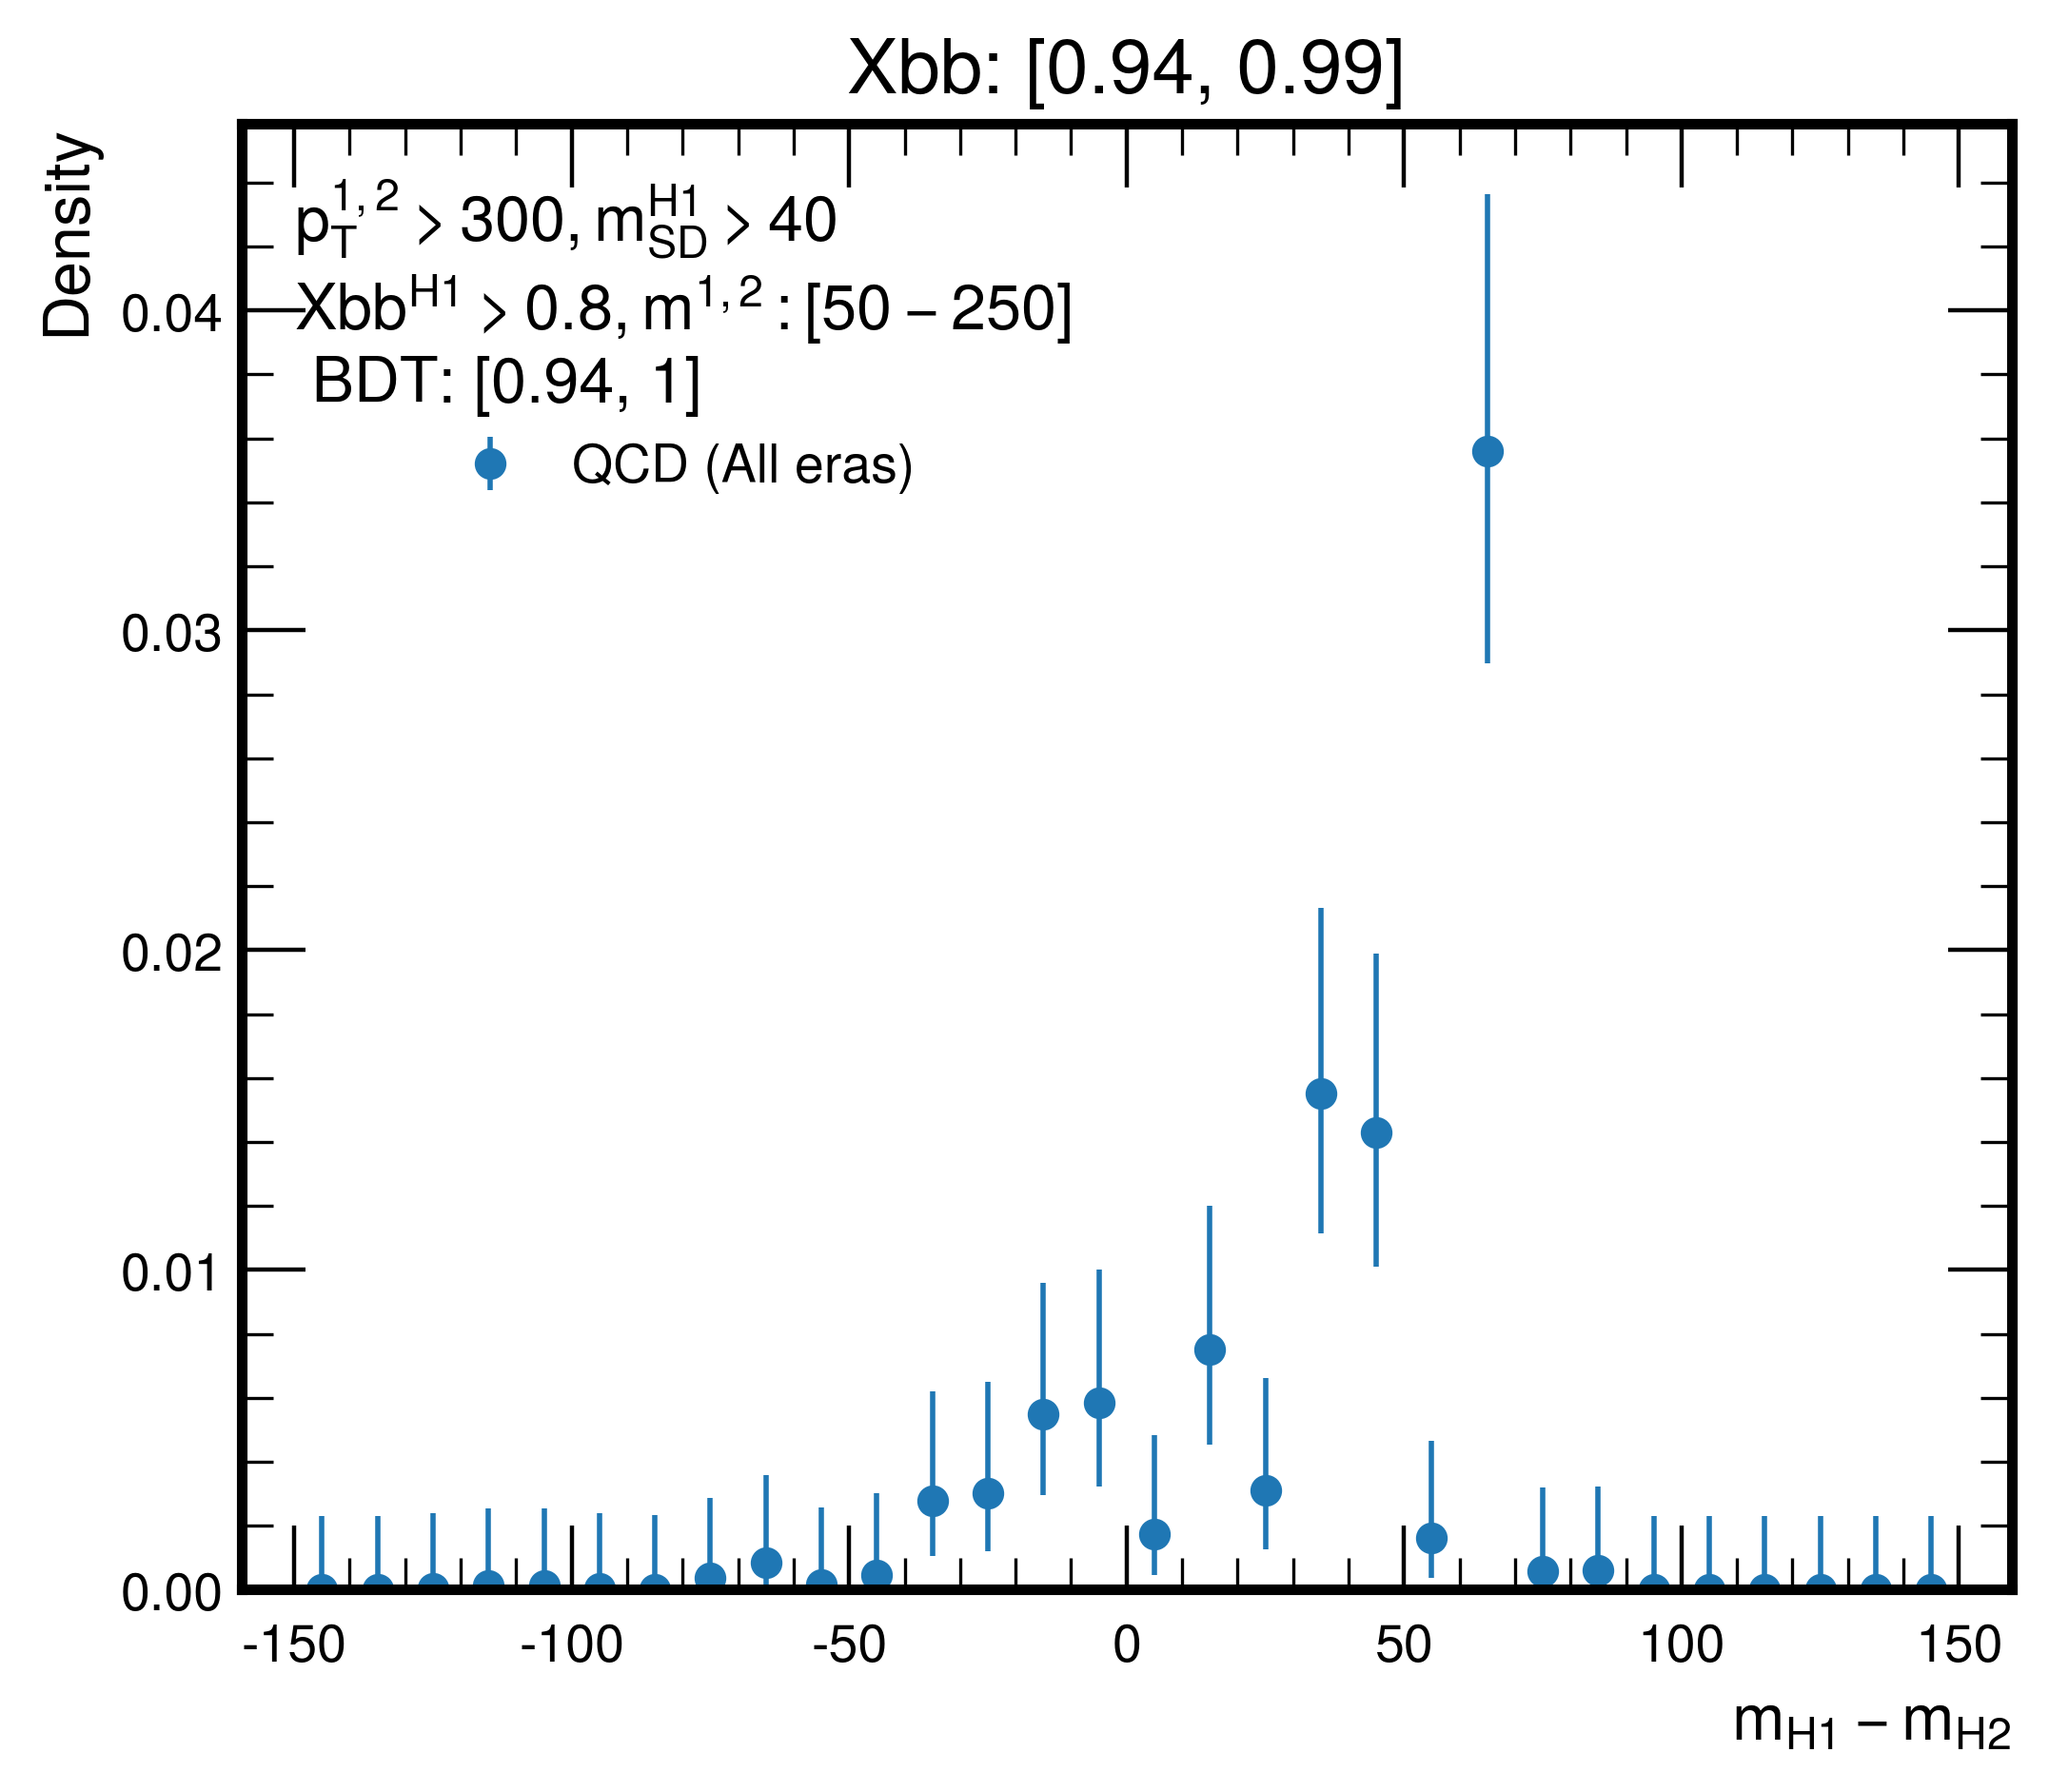

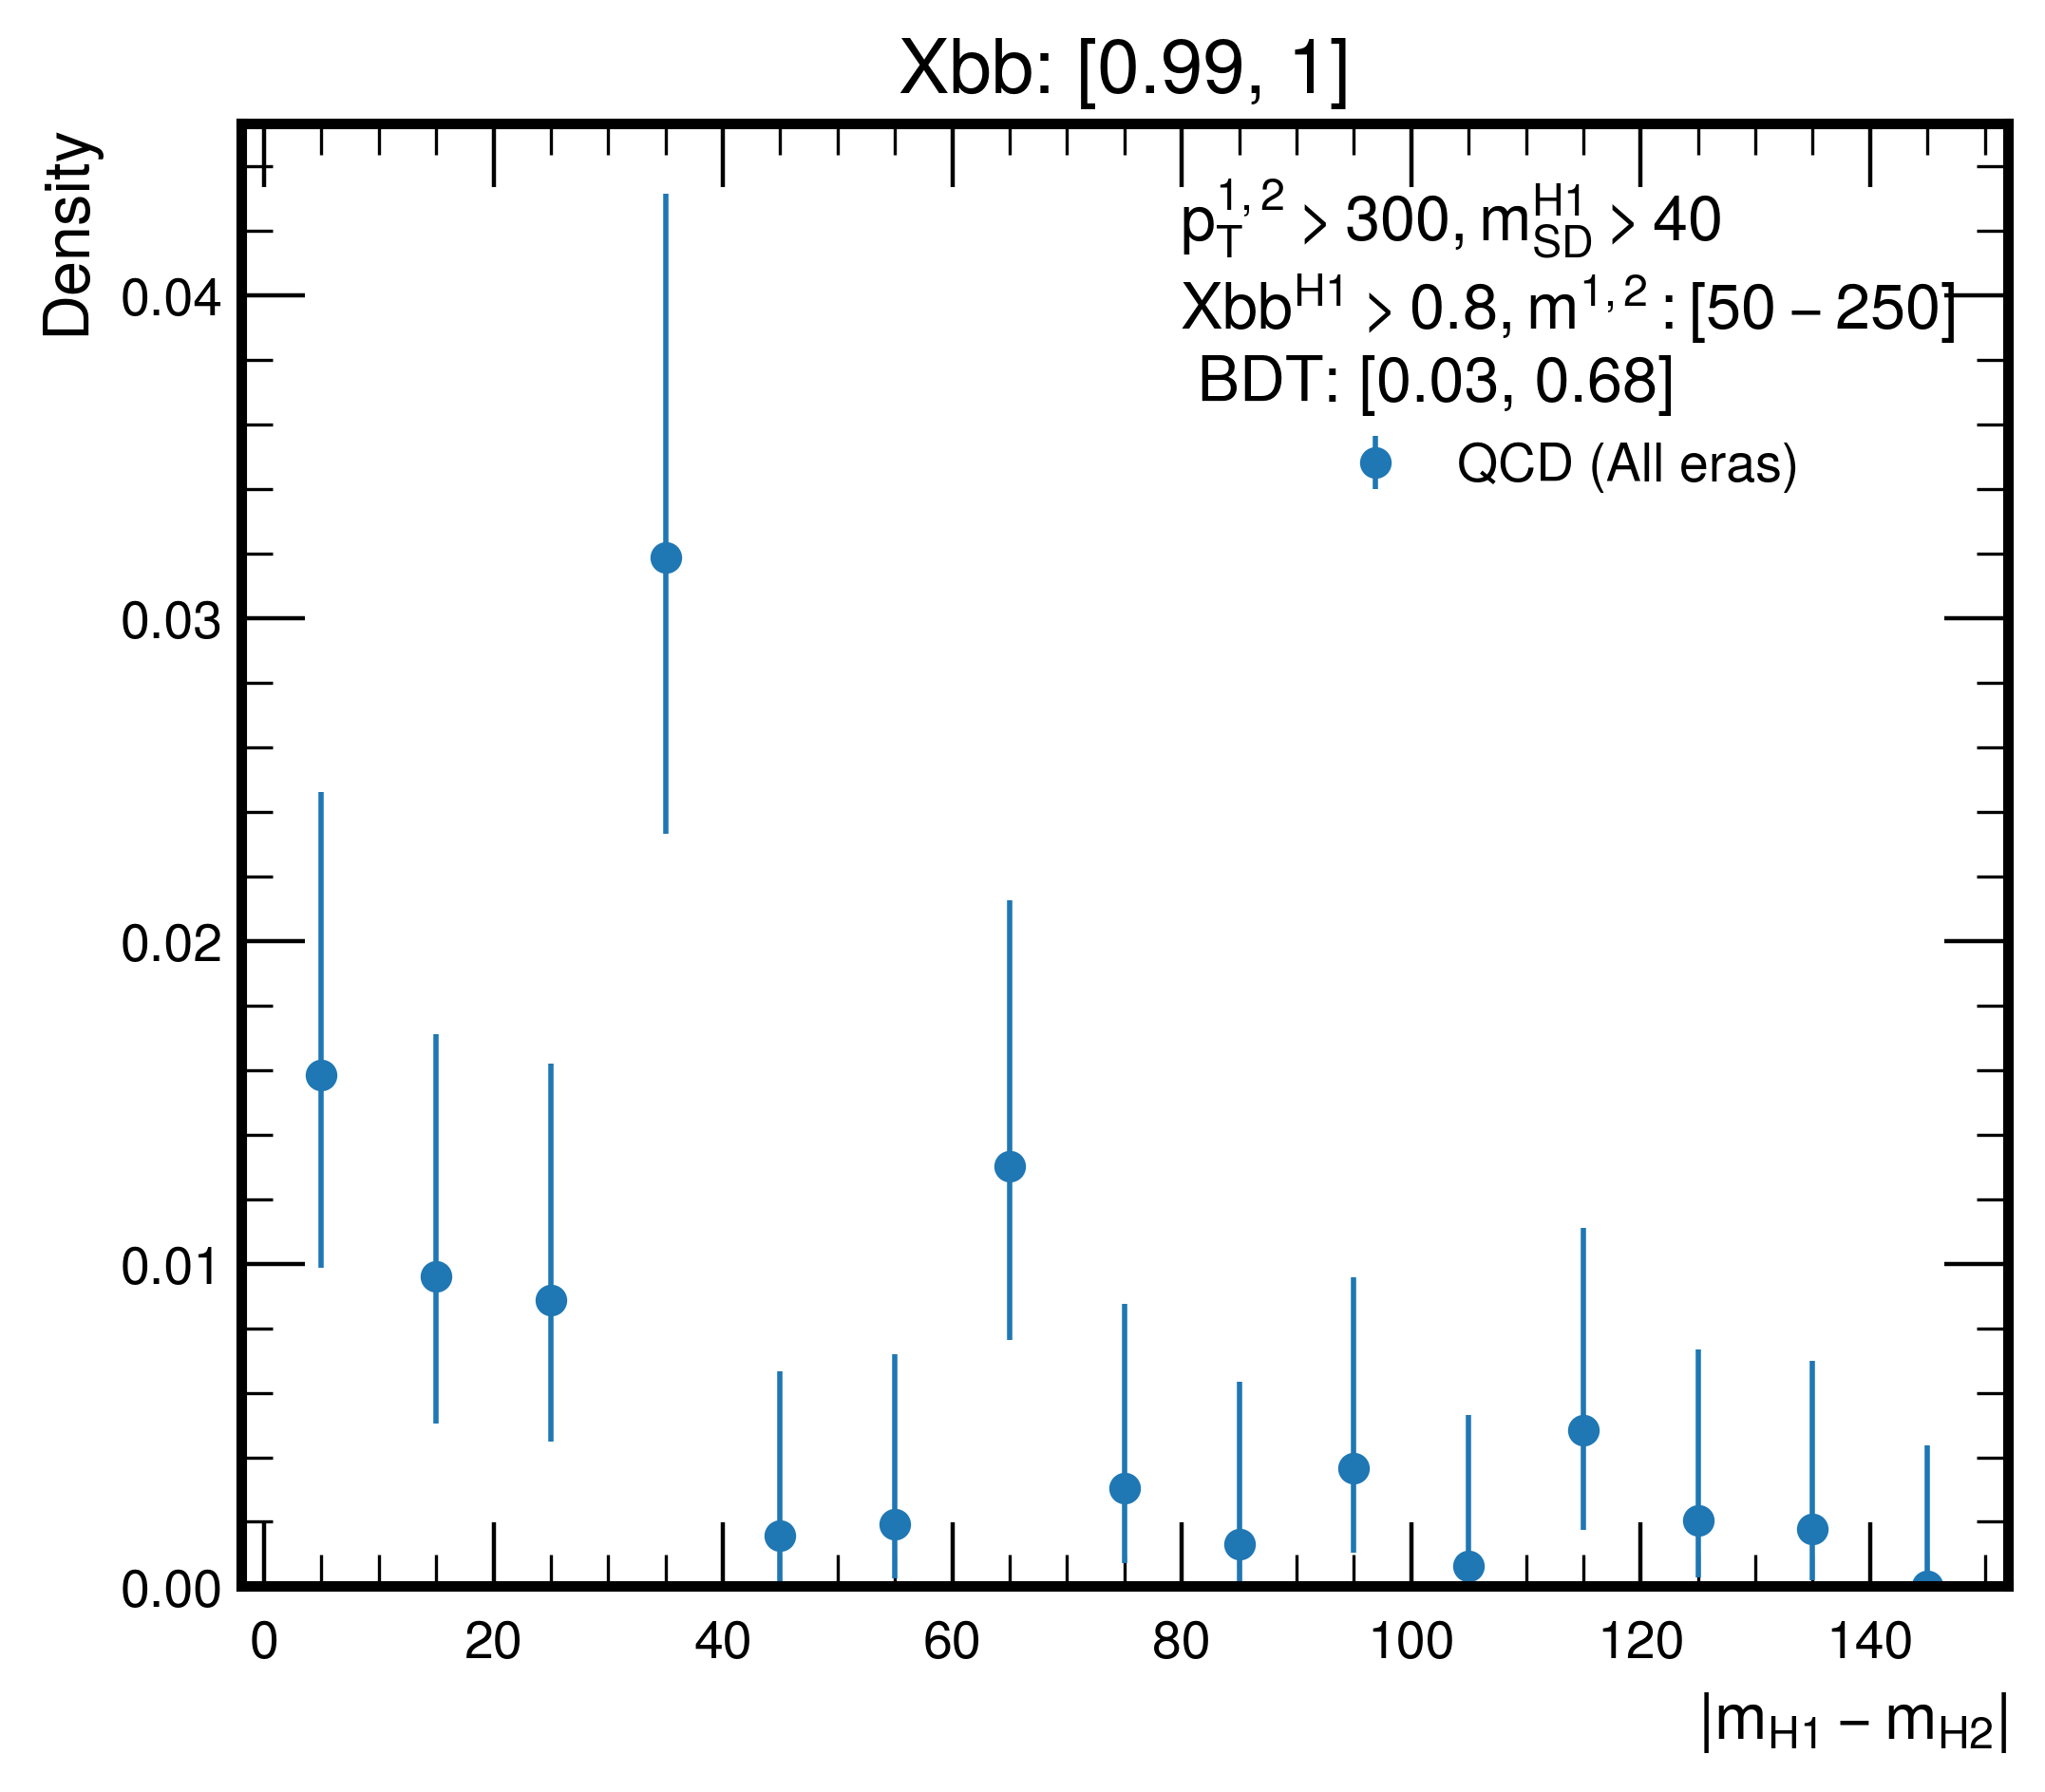

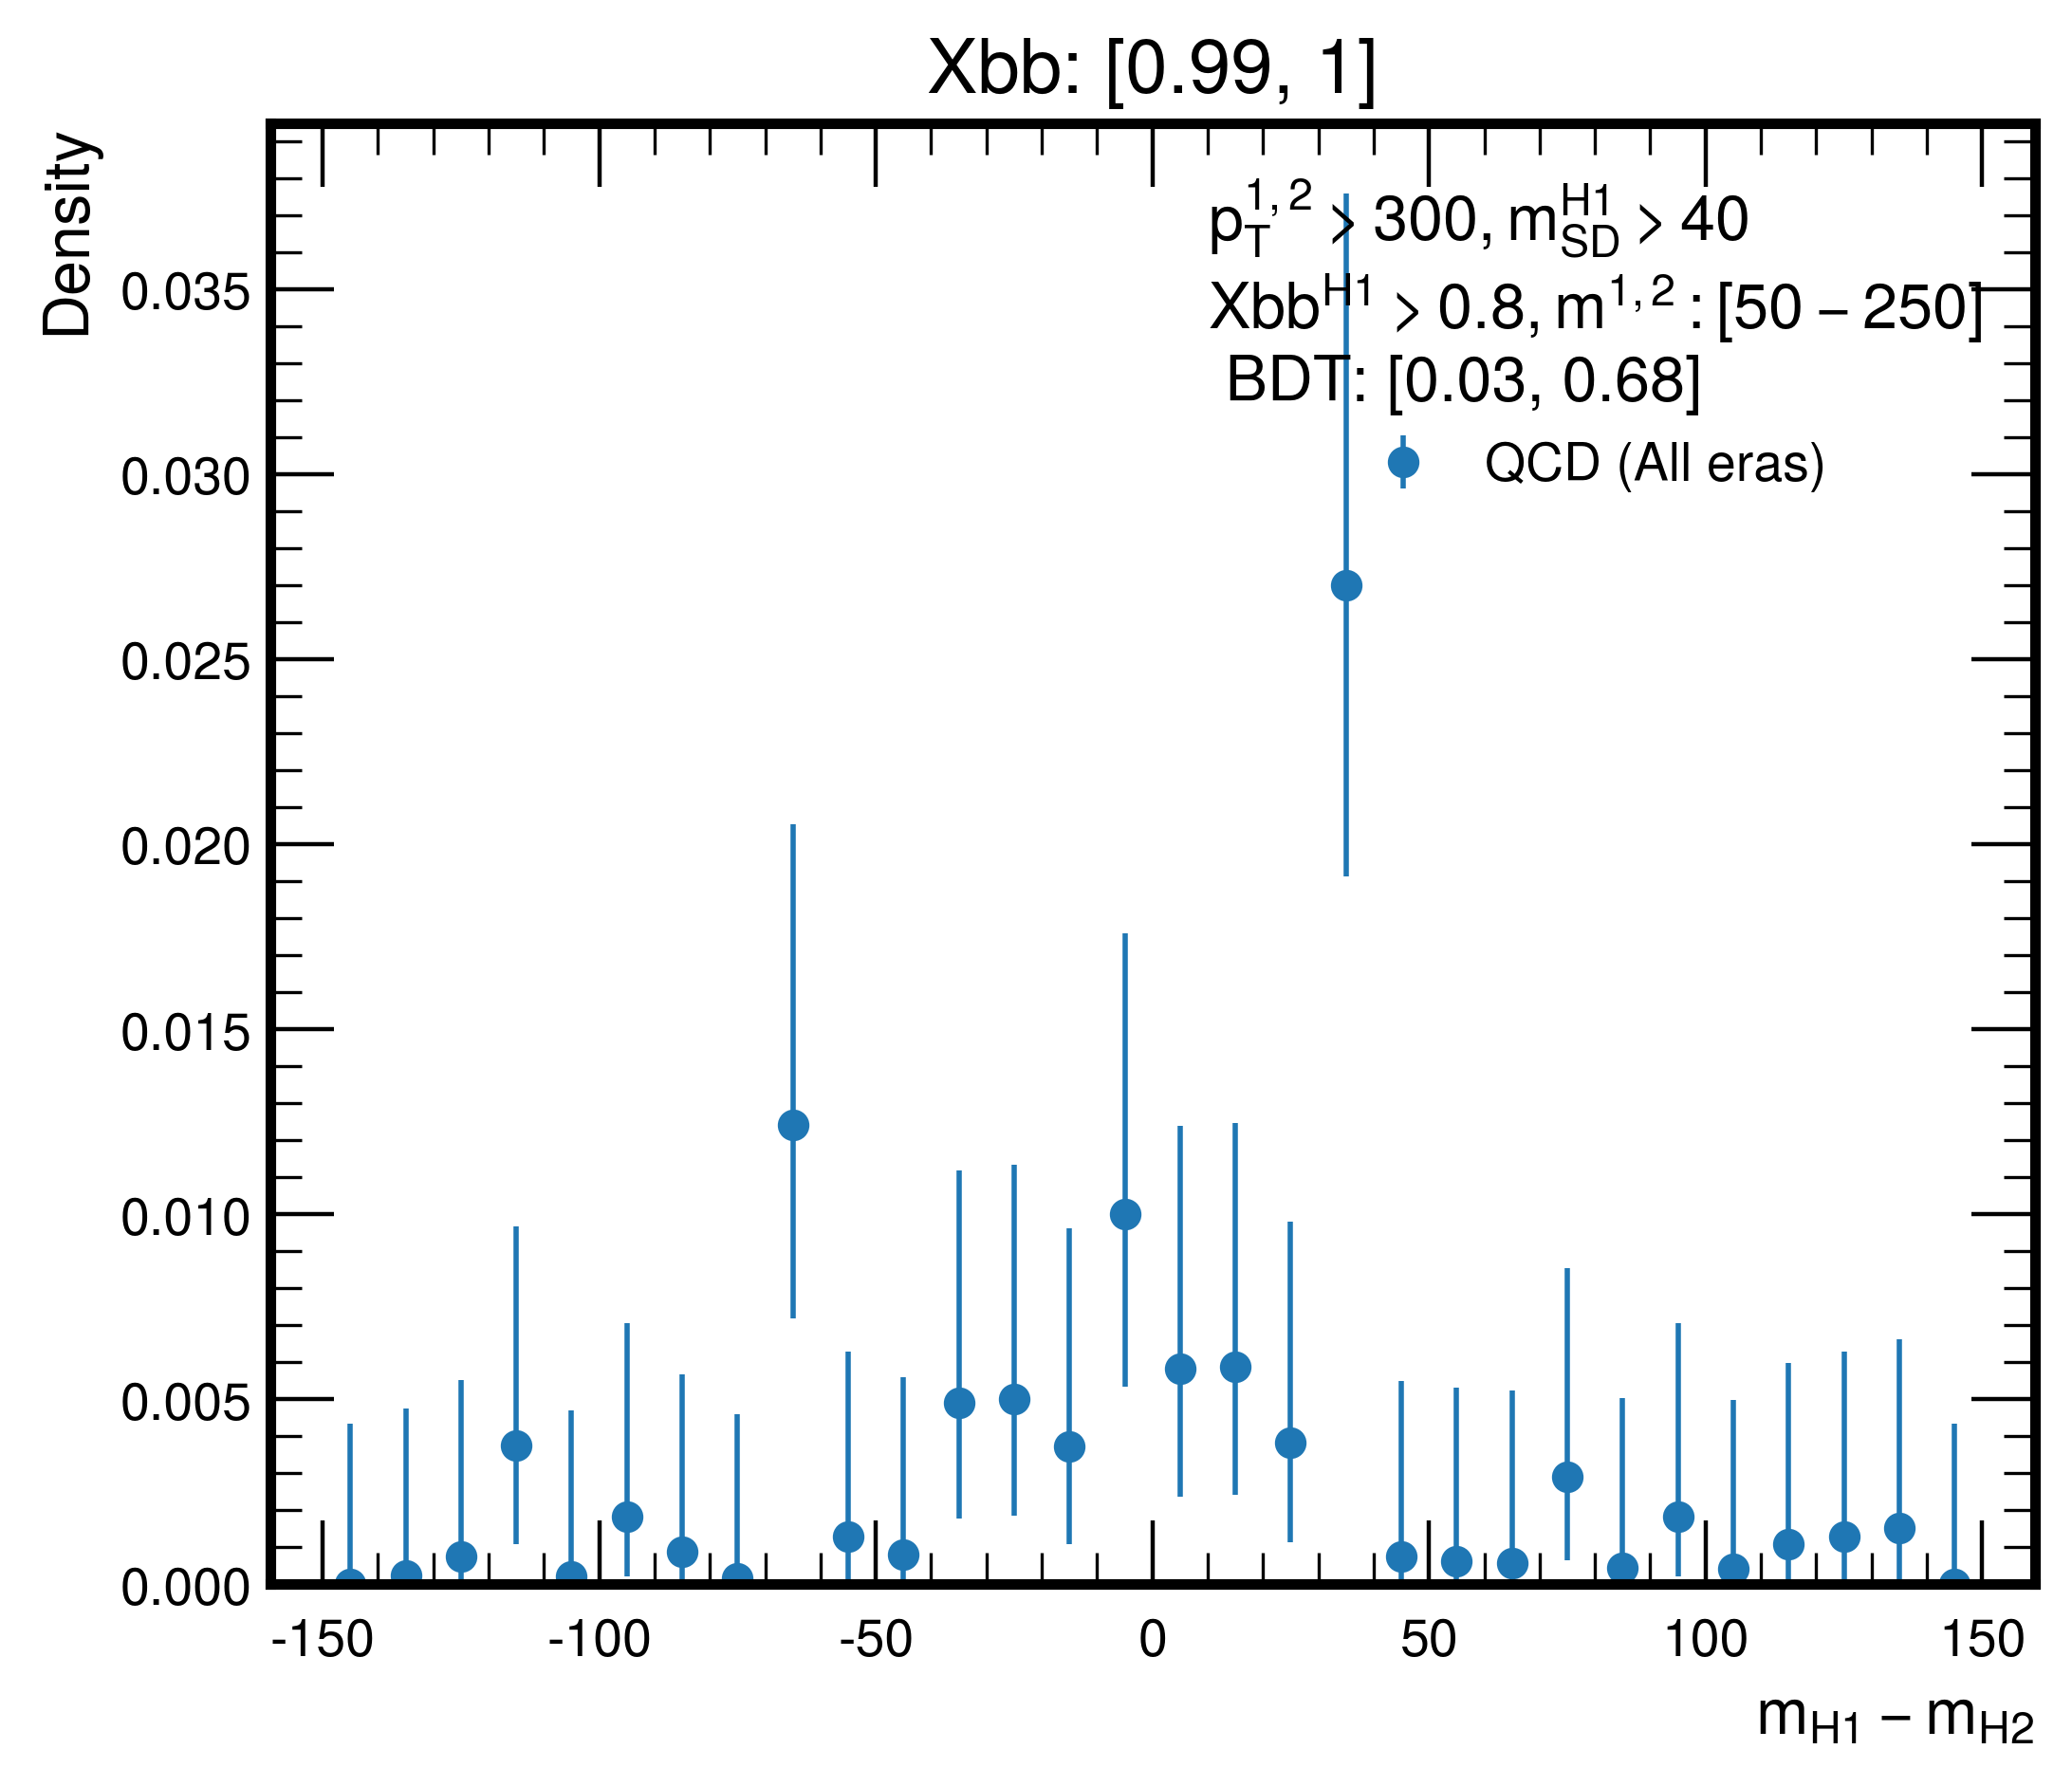

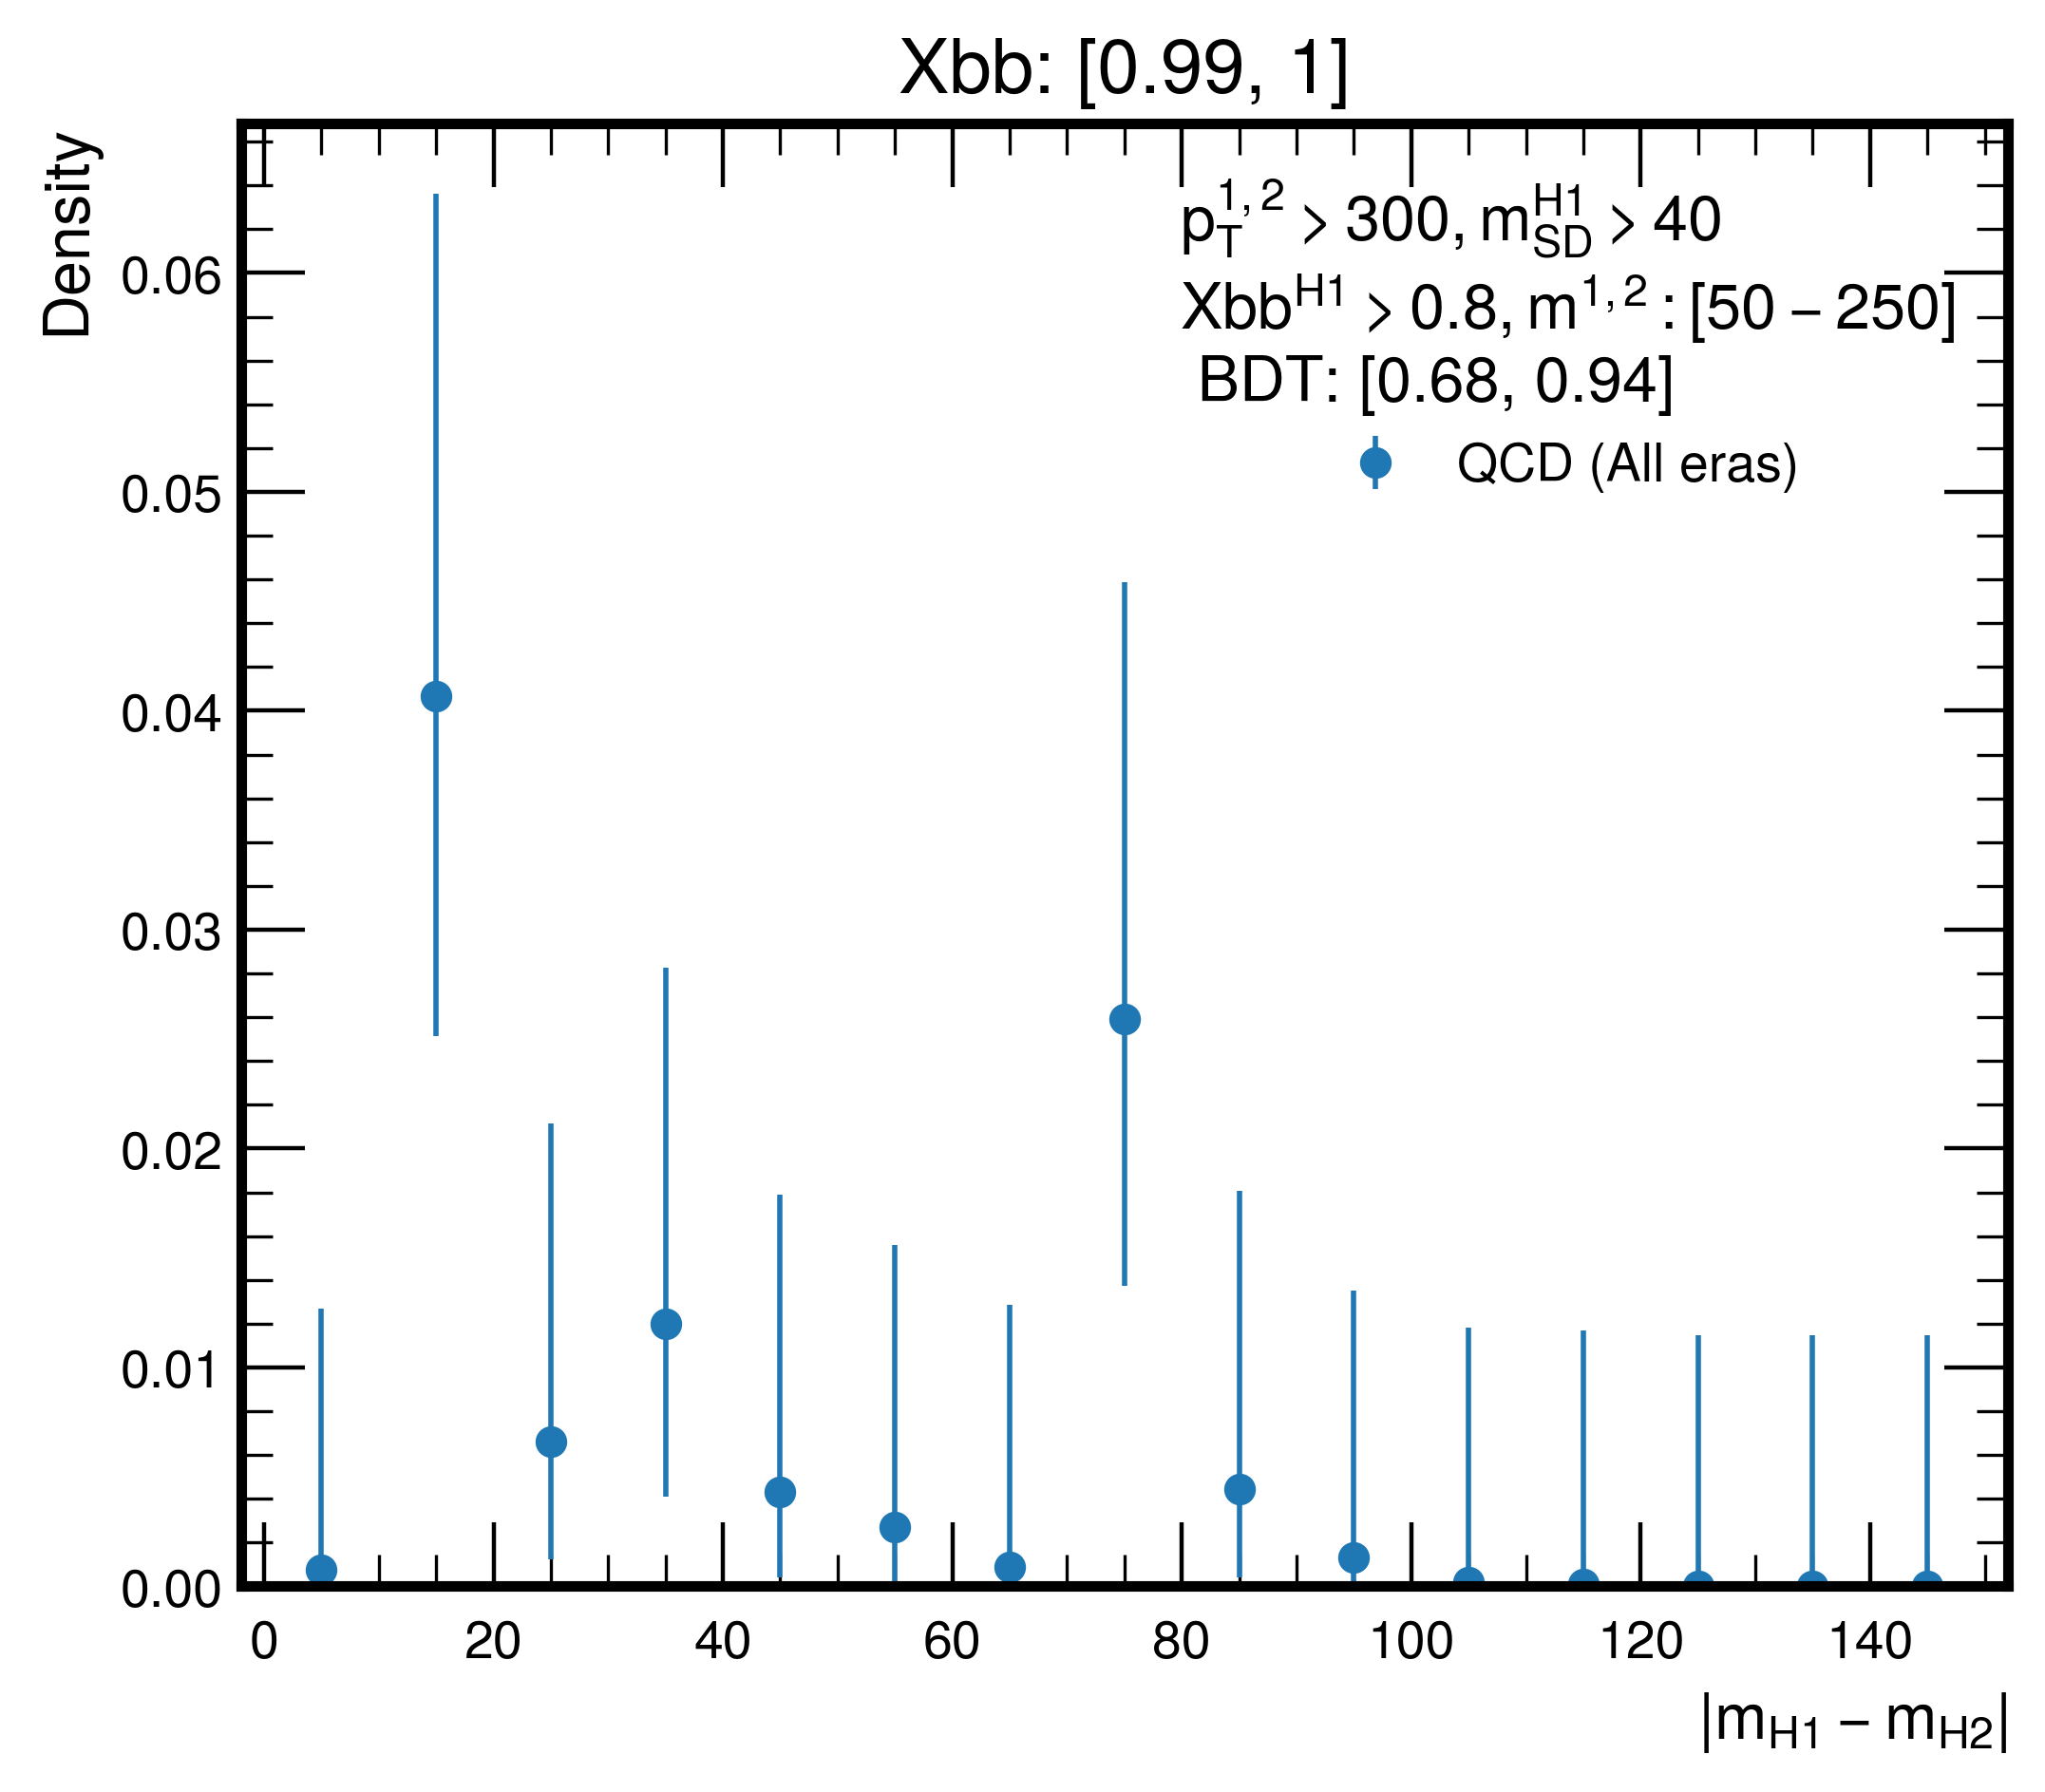

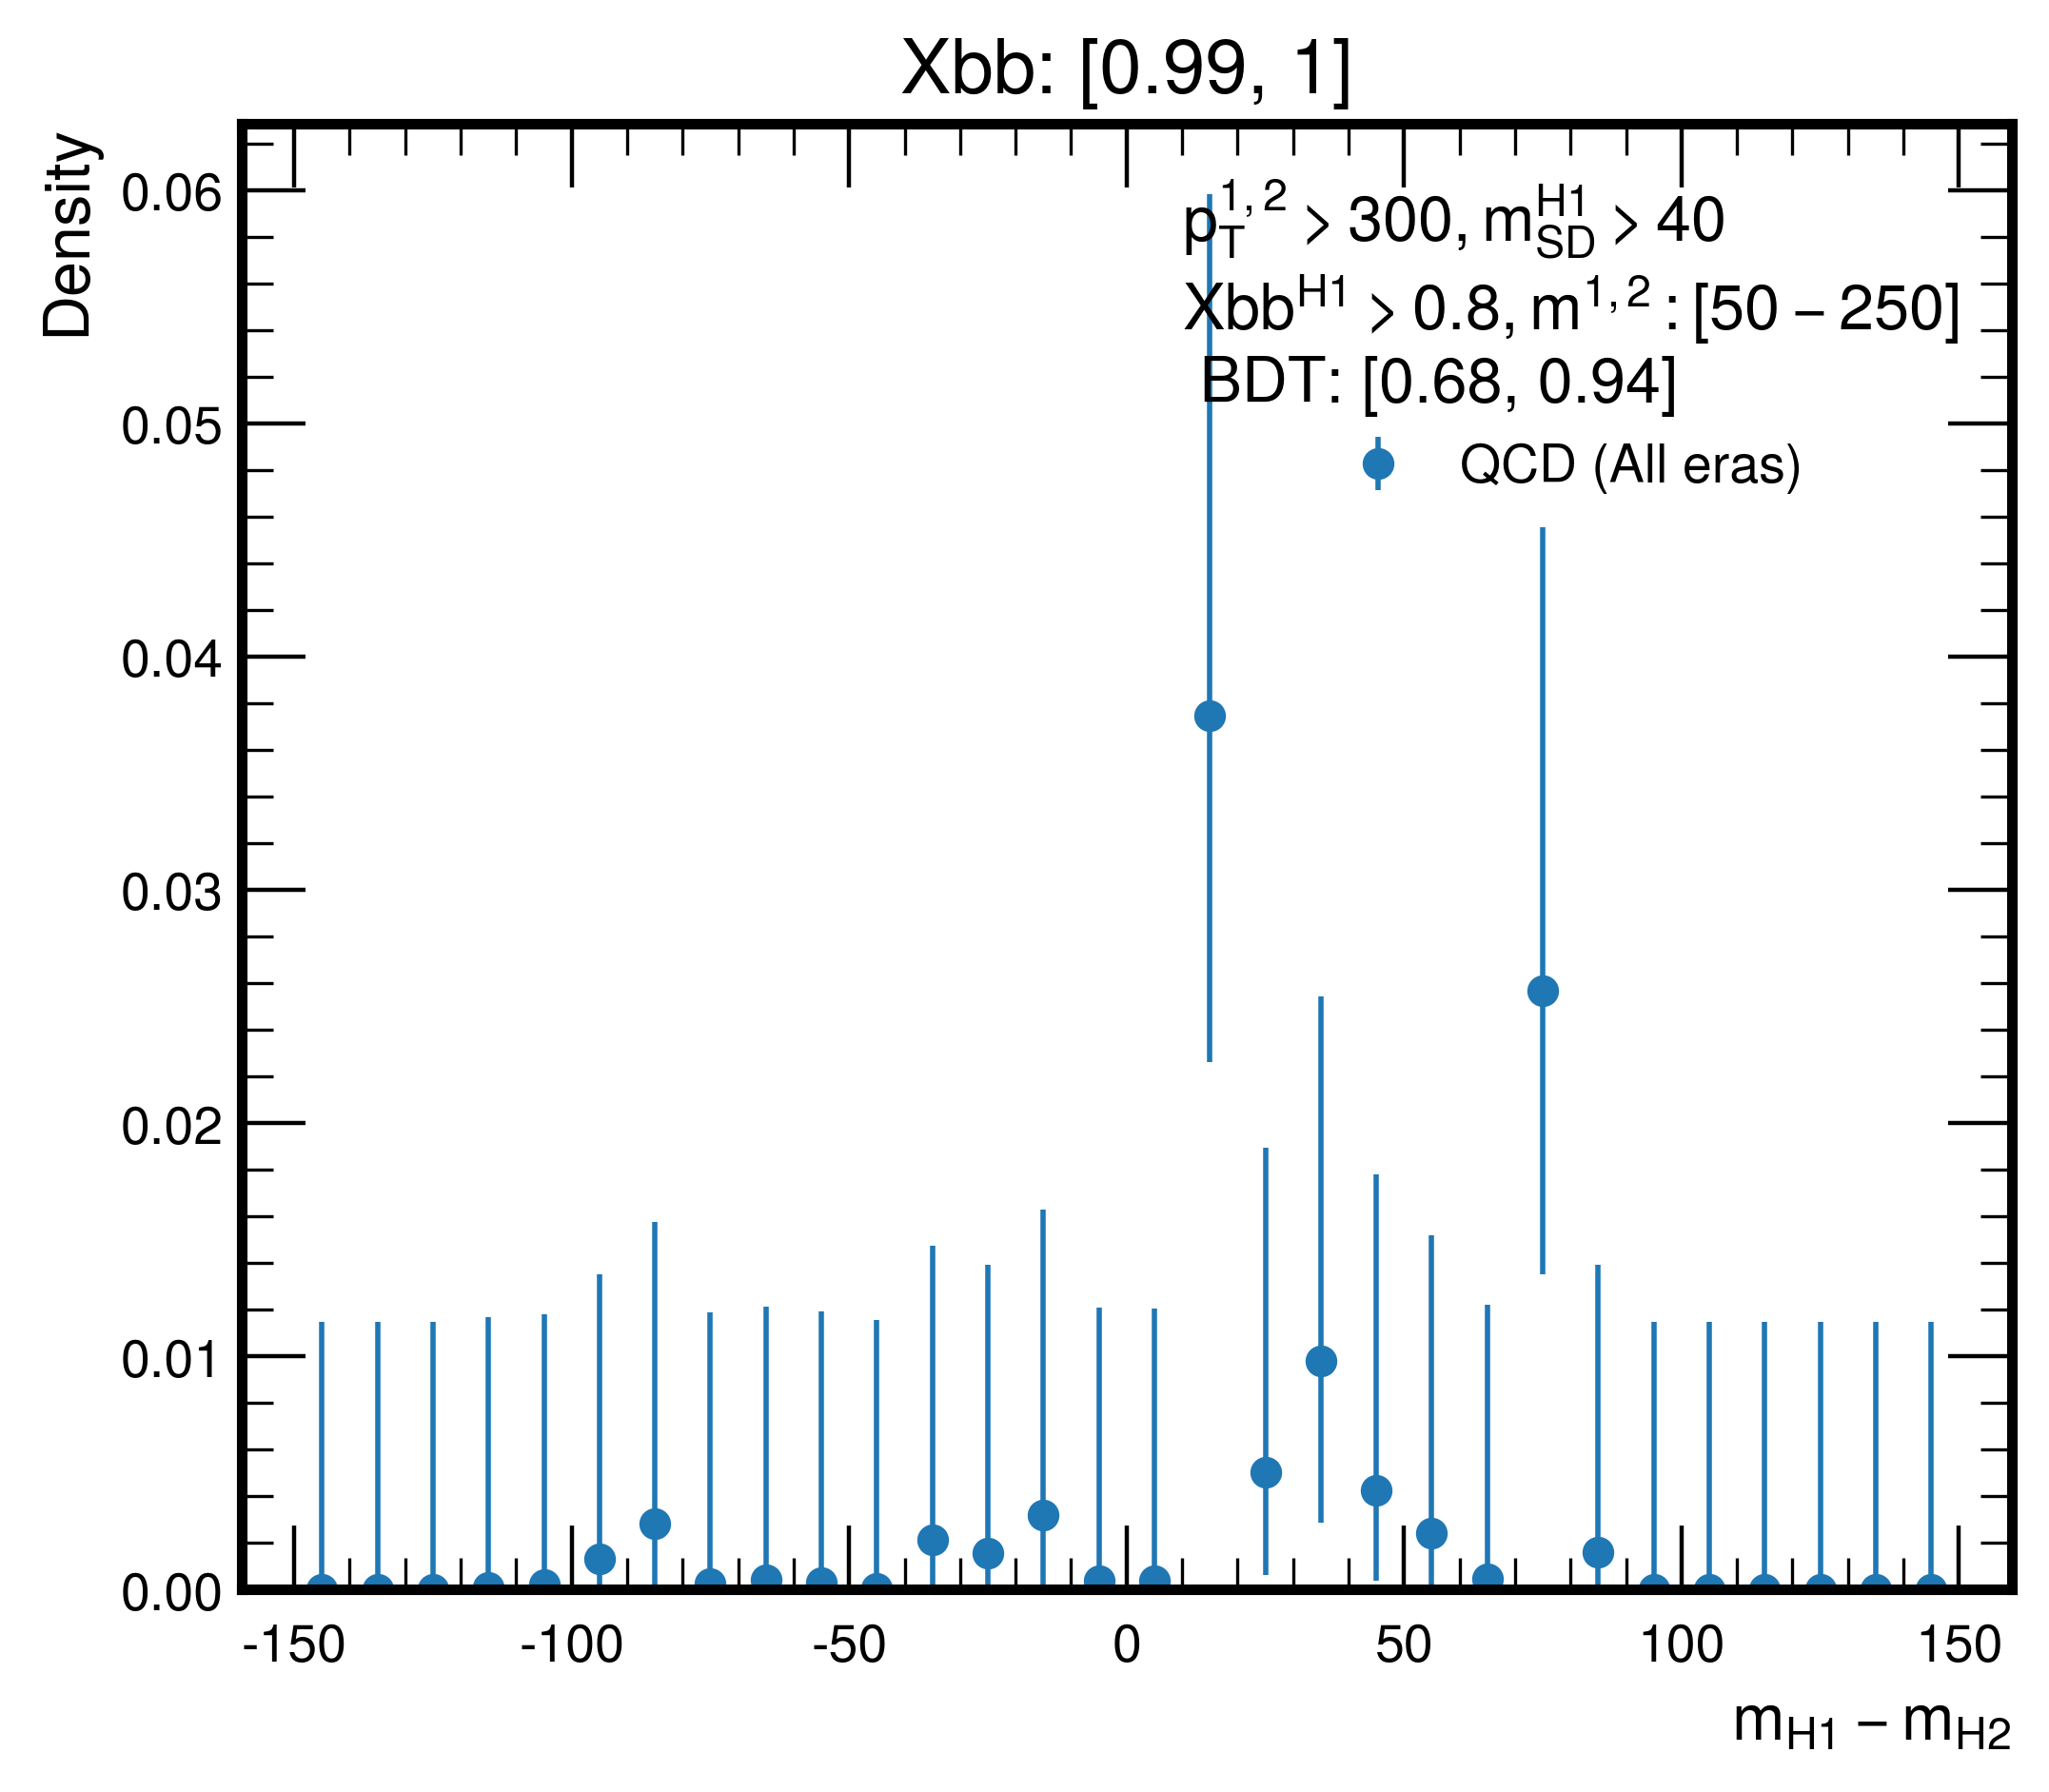

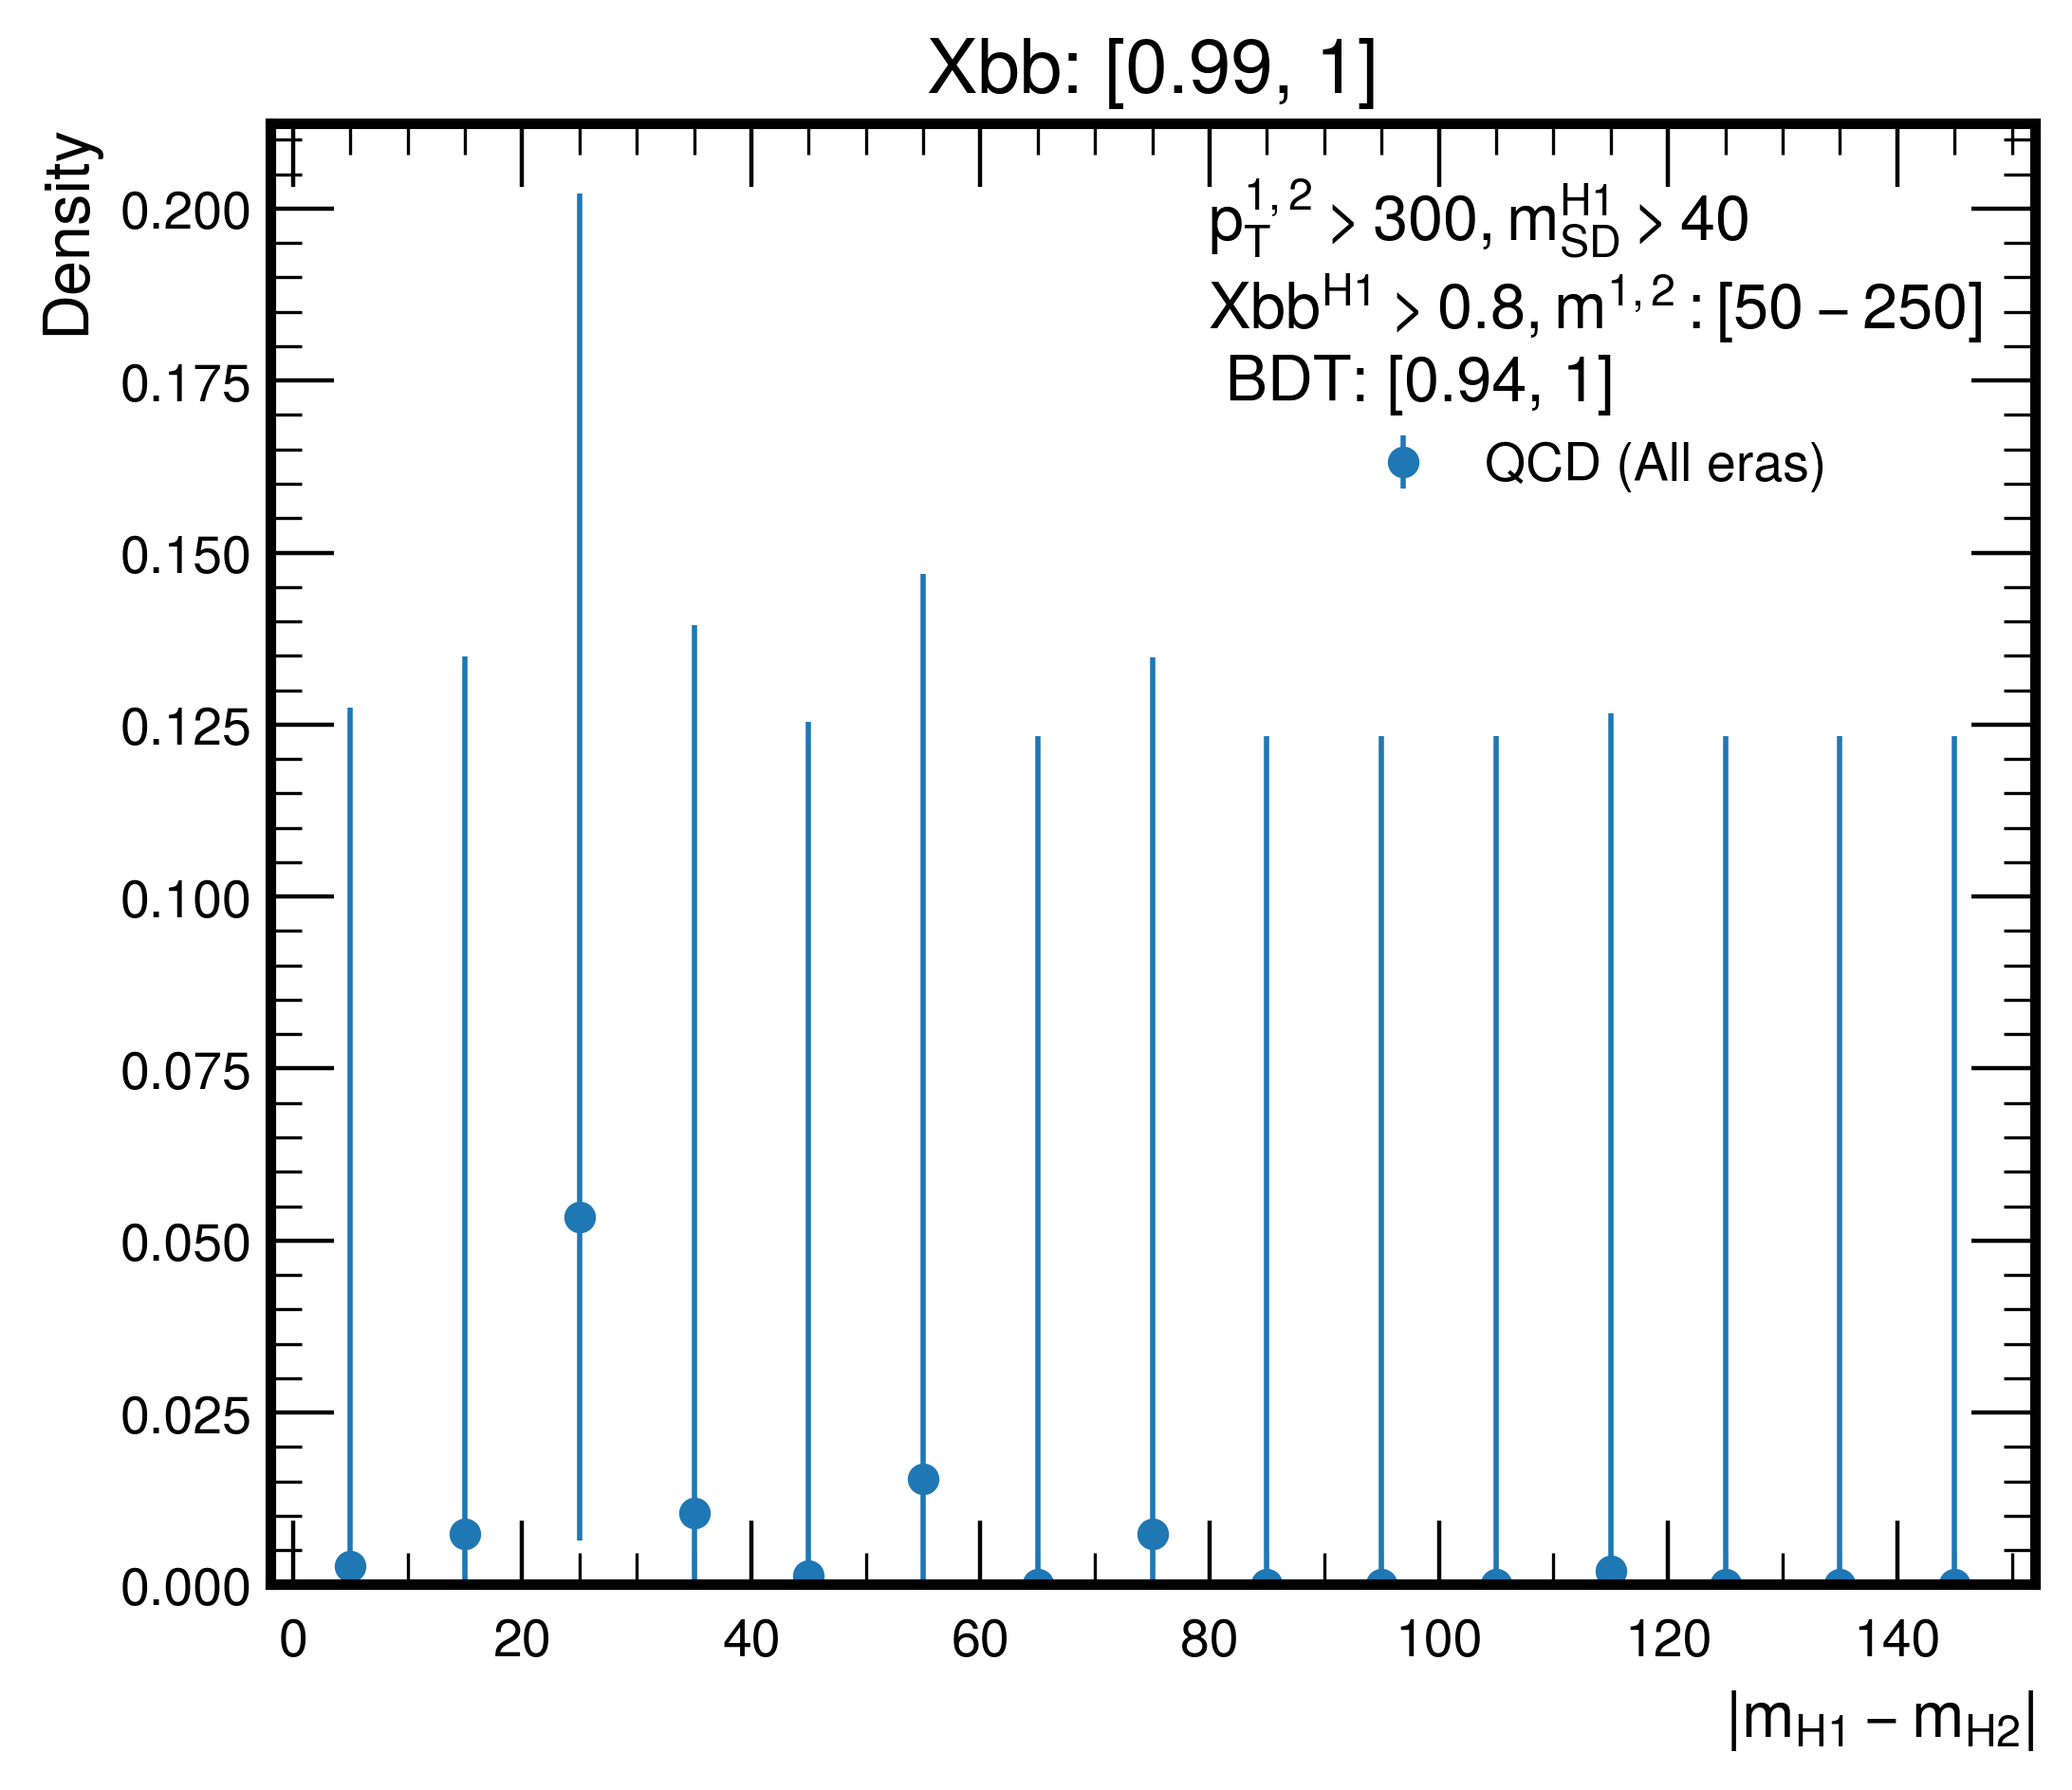

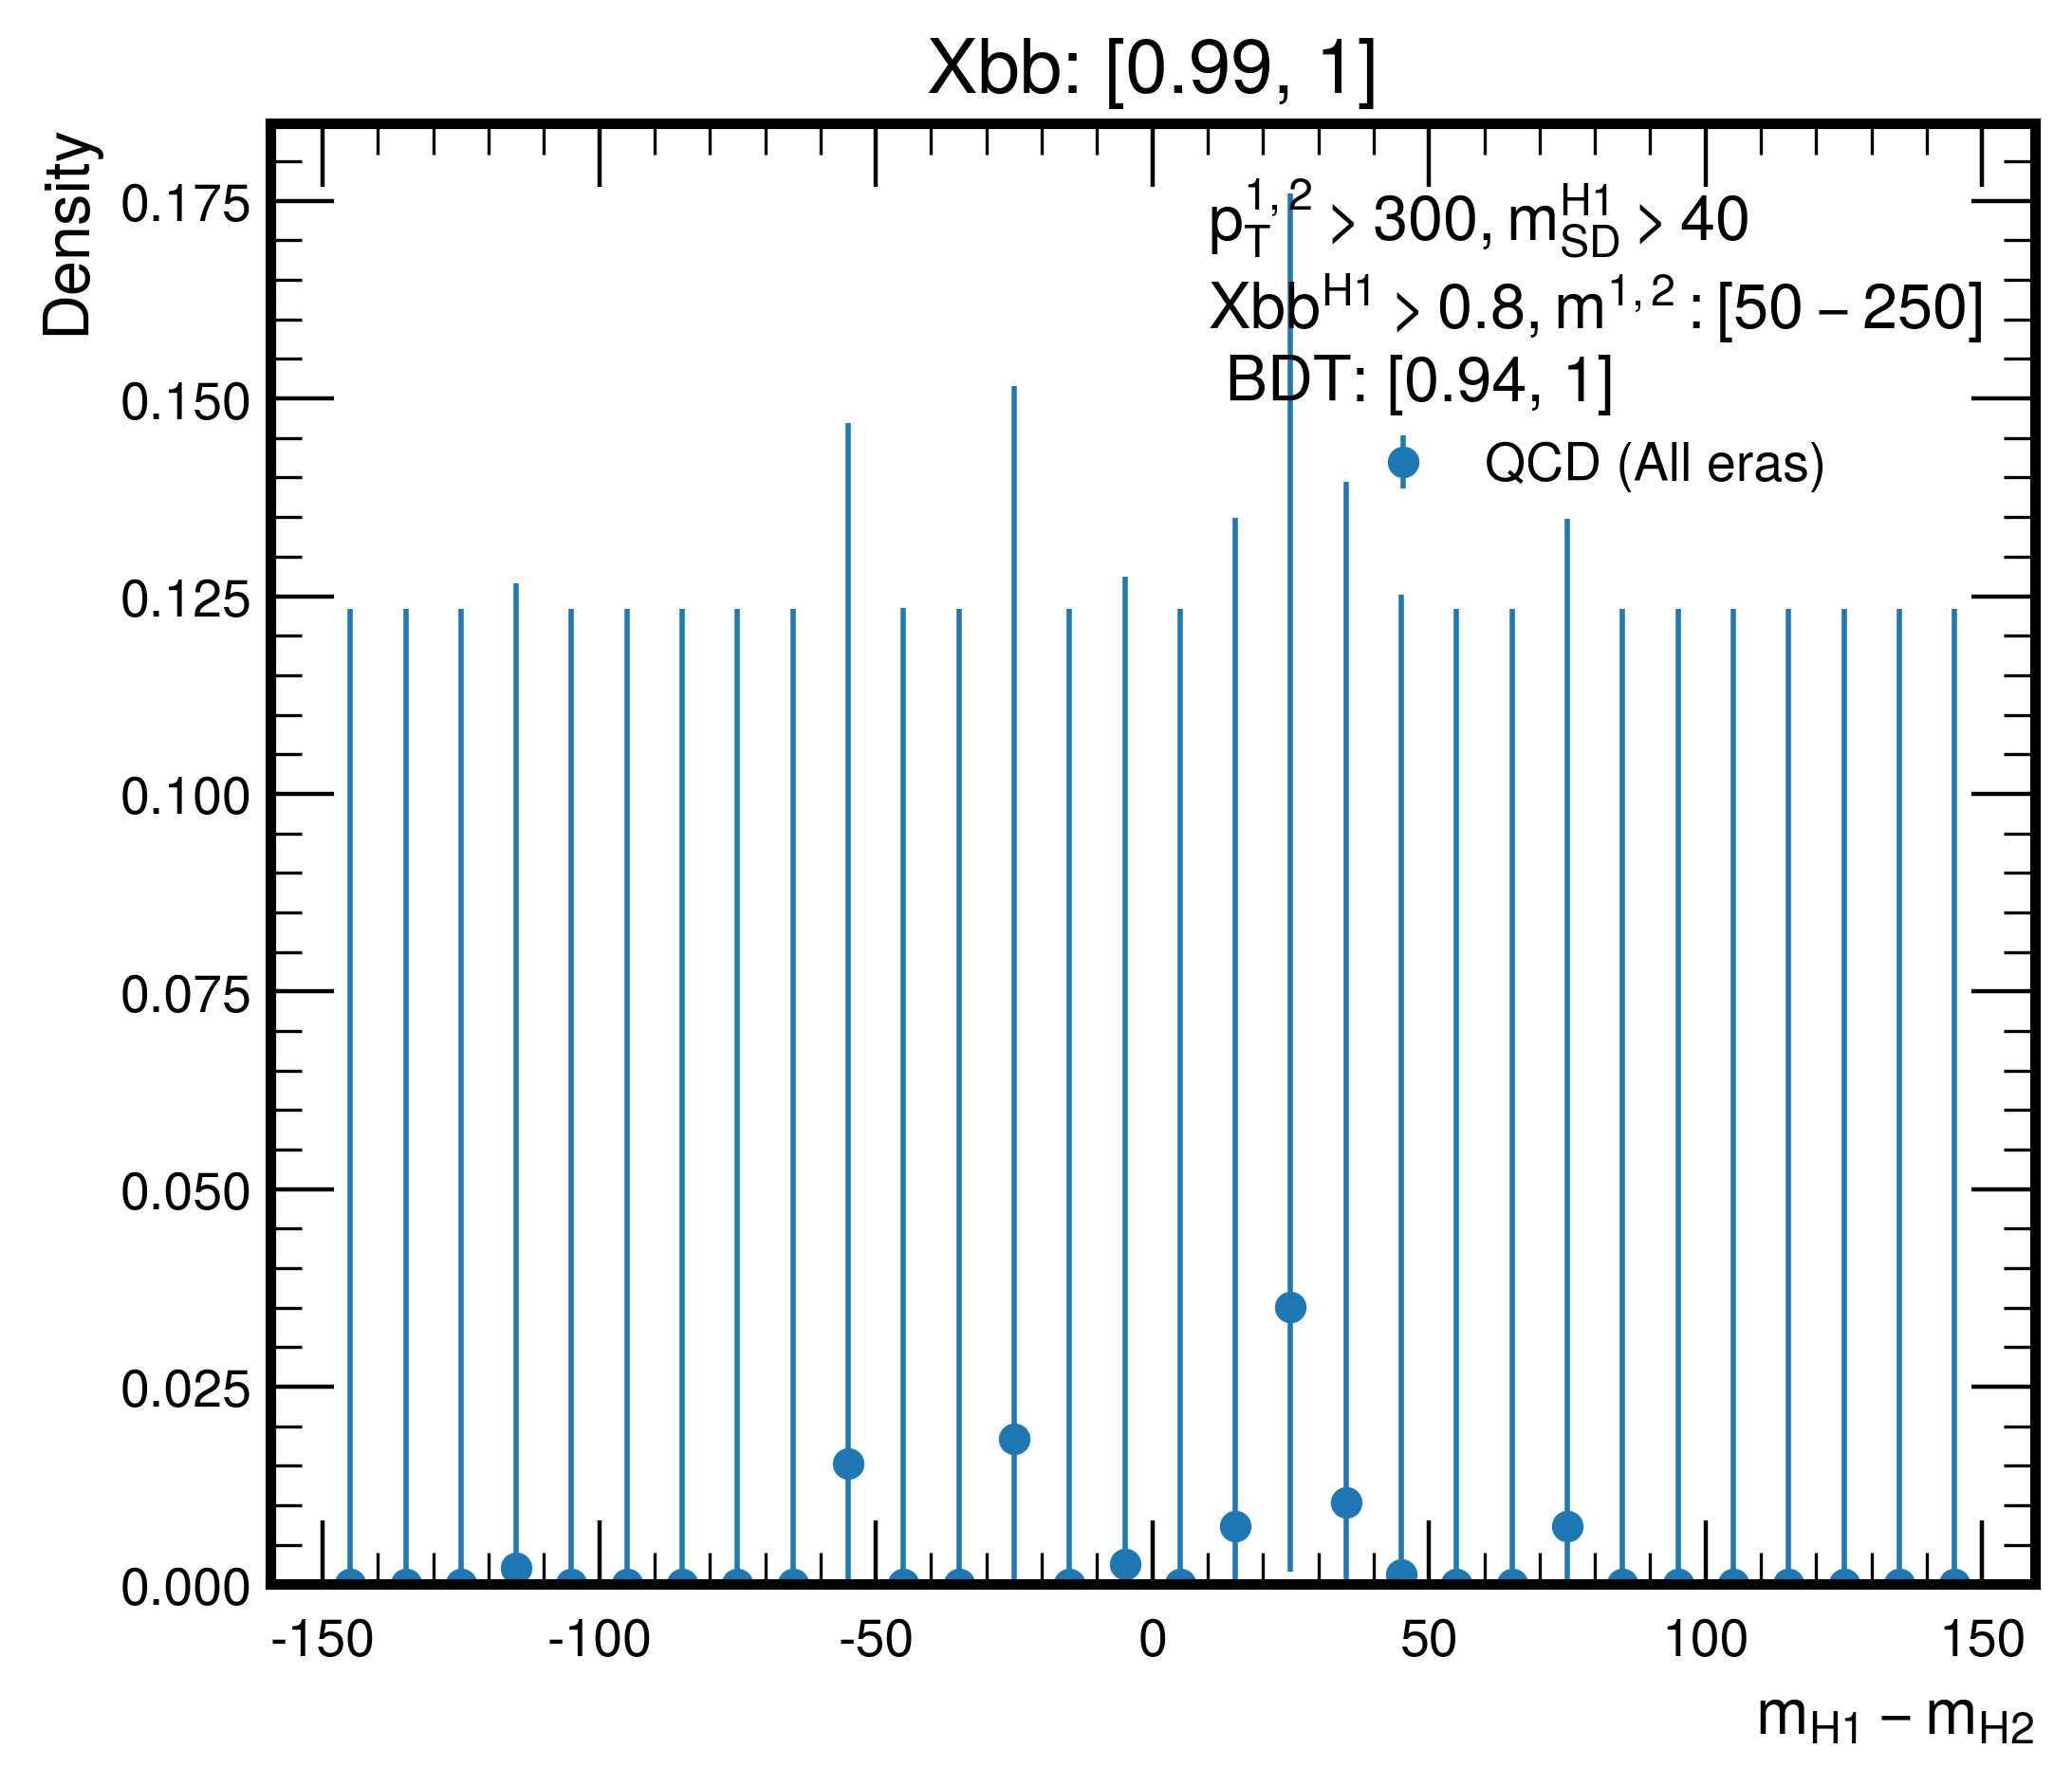

In [10]:
for ix, xbb_cut in enumerate(xbb_cuts):
    h_diff = hist.Hist(diff_axis, sample_axis, cut_axis)
    h_diff_rel = hist.Hist(rel_diff_axis, sample_axis, cut_axis)

    for key, events in events_combined.items():
        # apply Xbb cut
        events = events[(events["H2TXbb"] > xbb_cut[0]) & (events["H2TXbb"] <= xbb_cut[1])]

        mass_diff = abs(events["H1PNetMass"] - events["H2PNetMass"])
        rel_mass_diff = events["H1PNetMass"] - events["H2PNetMass"]
        bdt = events["bdt_score"]
        for i, bdt_cut in enumerate(bdt_cuts):
            mask = (bdt > bdt_cut[0]) & (bdt <= bdt_cut[1])
            weight = events["weight"]
            h_diff.fill(mass_diff[mask], key, str(i), weight=weight[mask])
            h_diff_rel.fill(rel_mass_diff[mask], key, str(i), weight=weight[mask])

    for i, bdt_cut in enumerate(bdt_cuts):
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        for key in events_combined:
            try:
                x = h_diff[{"samp": key, "cut": str(i)}]
            except KeyError:
                print(f"No cut {i} for sample {key} in xbb_cut {xbb_cut}")
                break
            hep.histplot(
                h_diff[{"samp": key, "cut": str(i)}],
                ax=ax,
                histtype="errorbar",
                flow="none",
                label=labels[key],
                density=True,
            )
        ax.legend(title=presel + f"\n BDT: {bdt_cut}")
        ax.set_xlabel(r"$|m_{H1} - m_{H2}|$")
        ax.set_title(f"Xbb: {xbb_cut}")
        ax.set_ylabel("Density")
        fig.savefig(f"{odir}/1d_massdiff_xbbcut{ix}_bdtcut{i}.png")

        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        for key in events_combined:
            try:
                x = h_diff_rel[{"samp": key, "cut": str(i)}]
            except KeyError:
                print(f"No cut {i} for sample {key} in xbb_cut {xbb_cut}")
                break
            hep.histplot(
                h_diff_rel[{"samp": key, "cut": str(i)}],
                flow="none",
                label=labels[key],
                density=True,
                histtype="errorbar",
                ax=ax,
            )
        ax.legend(title=presel + f"\n BDT: {bdt_cut}")
        ax.set_xlabel(r"$m_{H1} - m_{H2}$")
        ax.set_title(f"Xbb: {xbb_cut}")
        ax.set_ylabel("Density")
        fig.savefig(f"{odir}/1d_massrel_xbbcut{ix}_bdtcut{i}.png")

2d plot of BDT with mass difference for different Xbb cuts

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


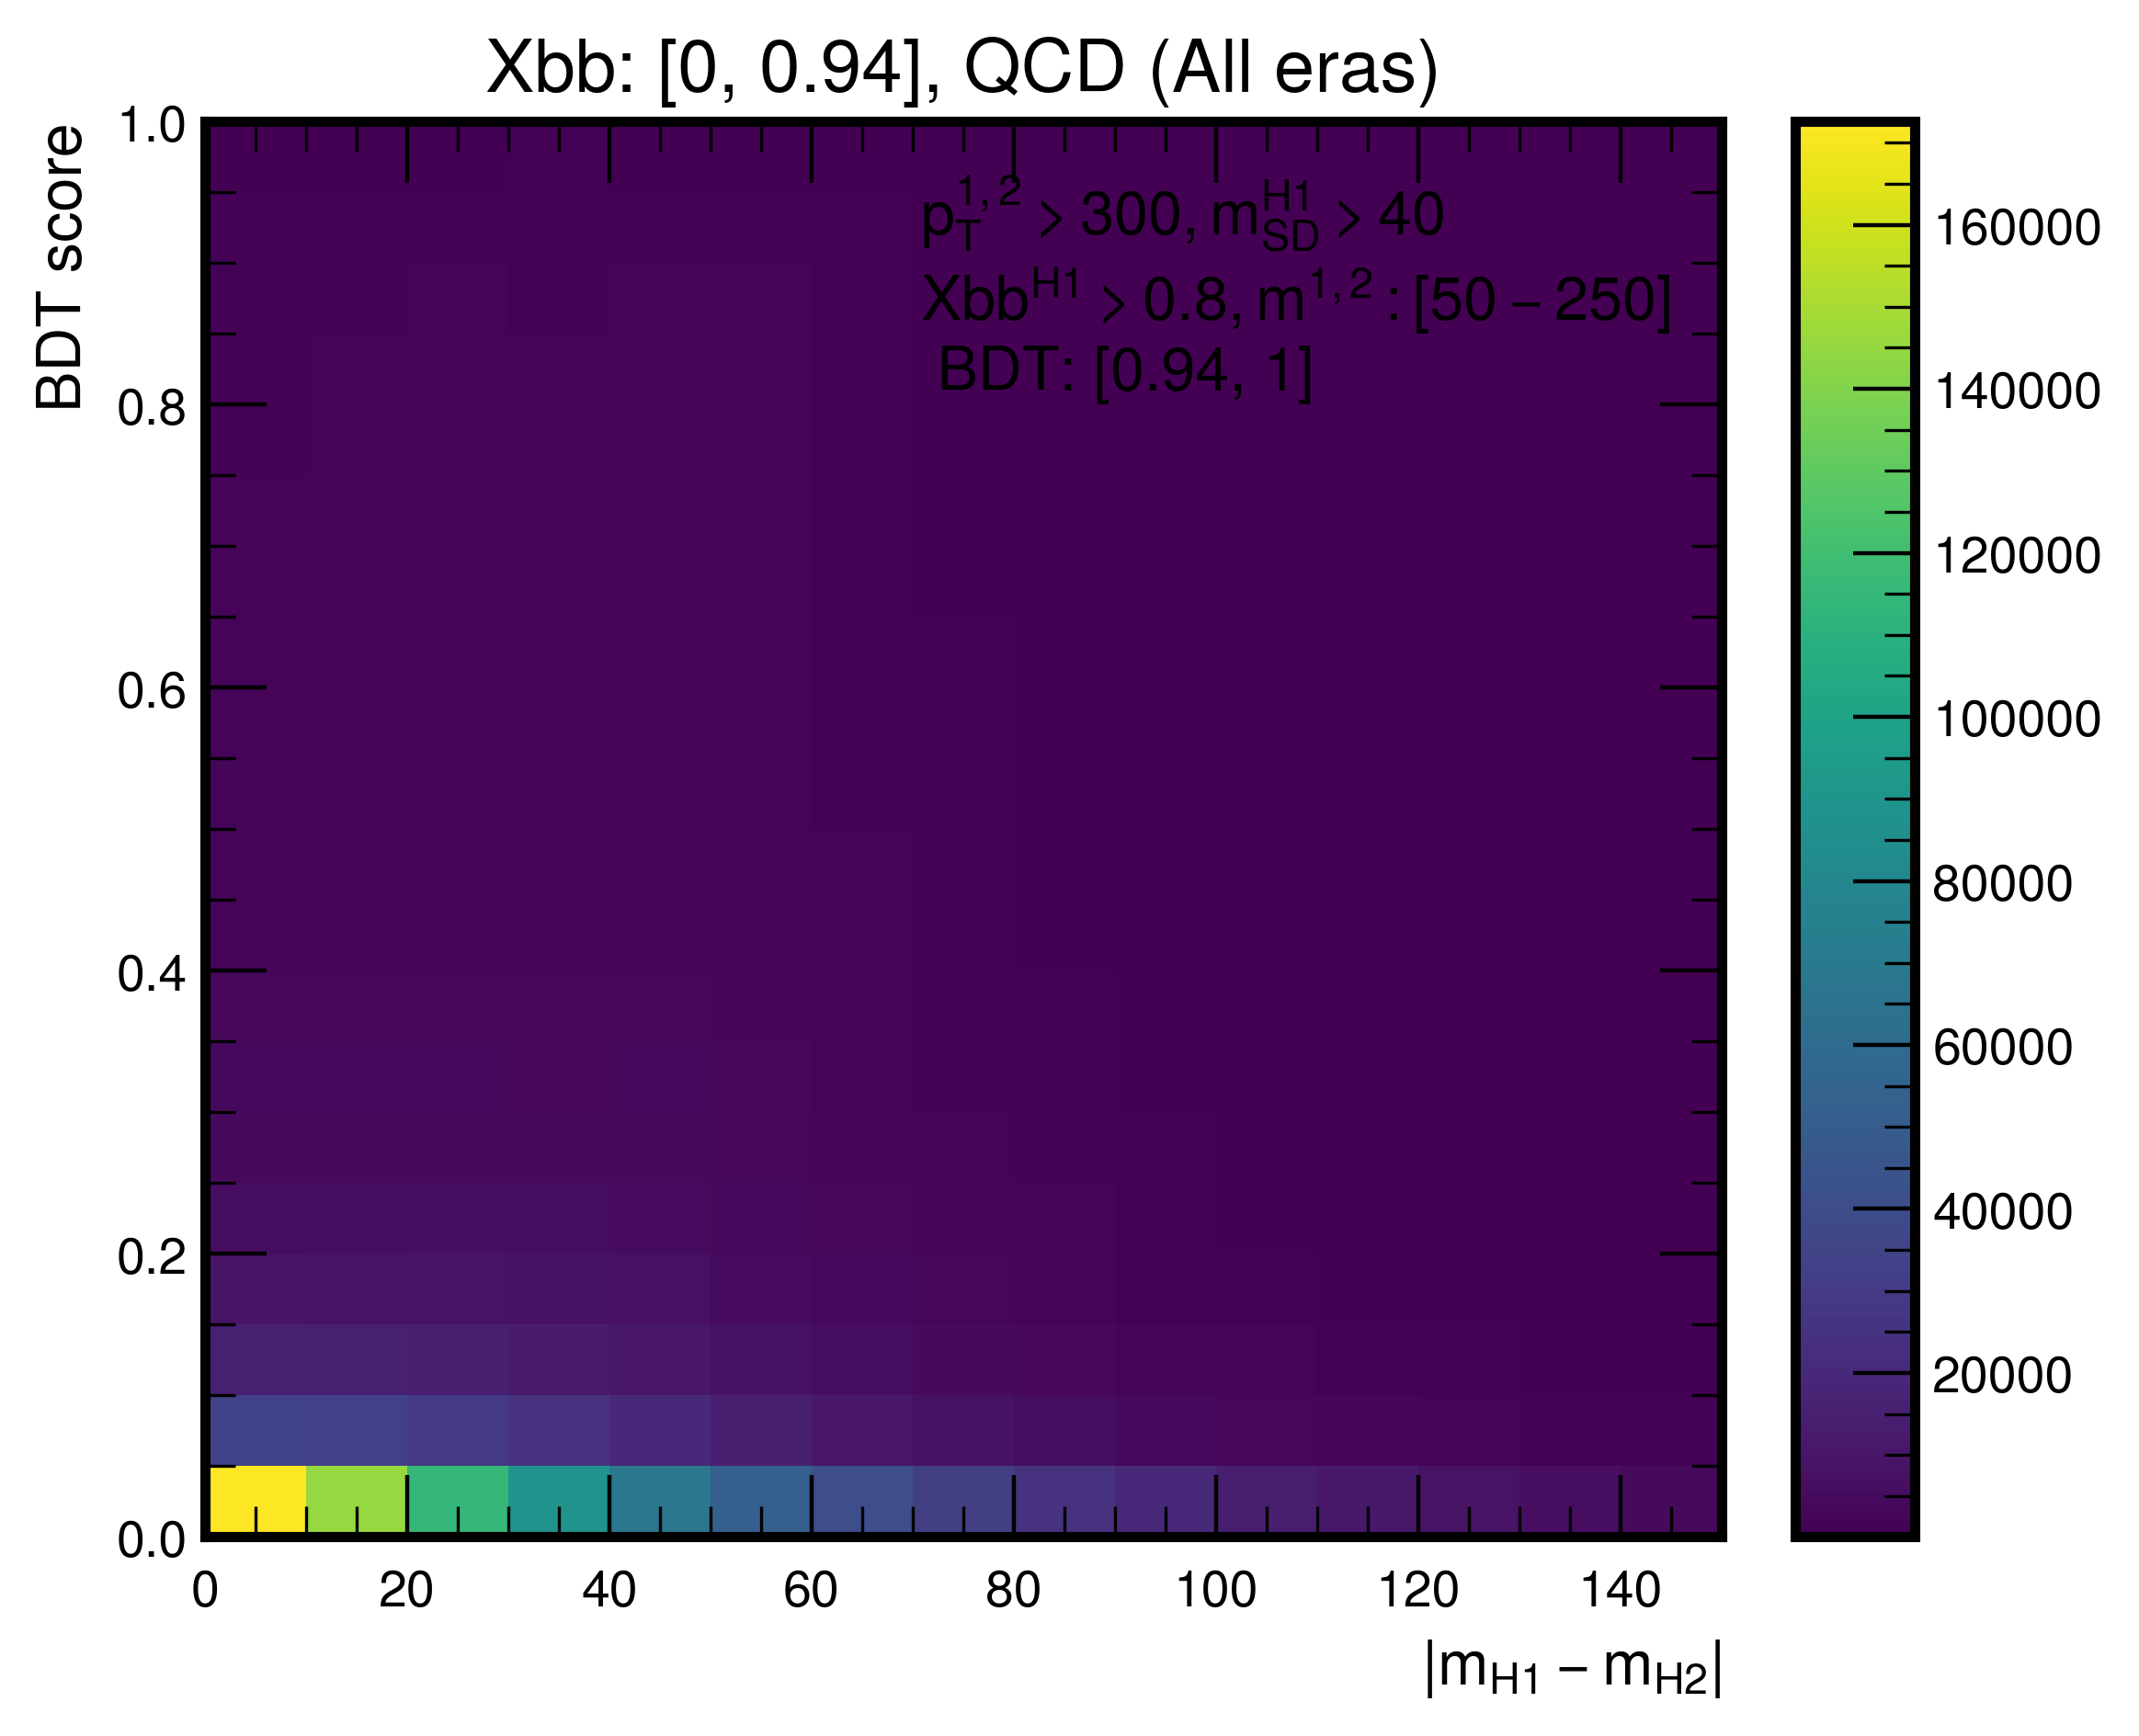

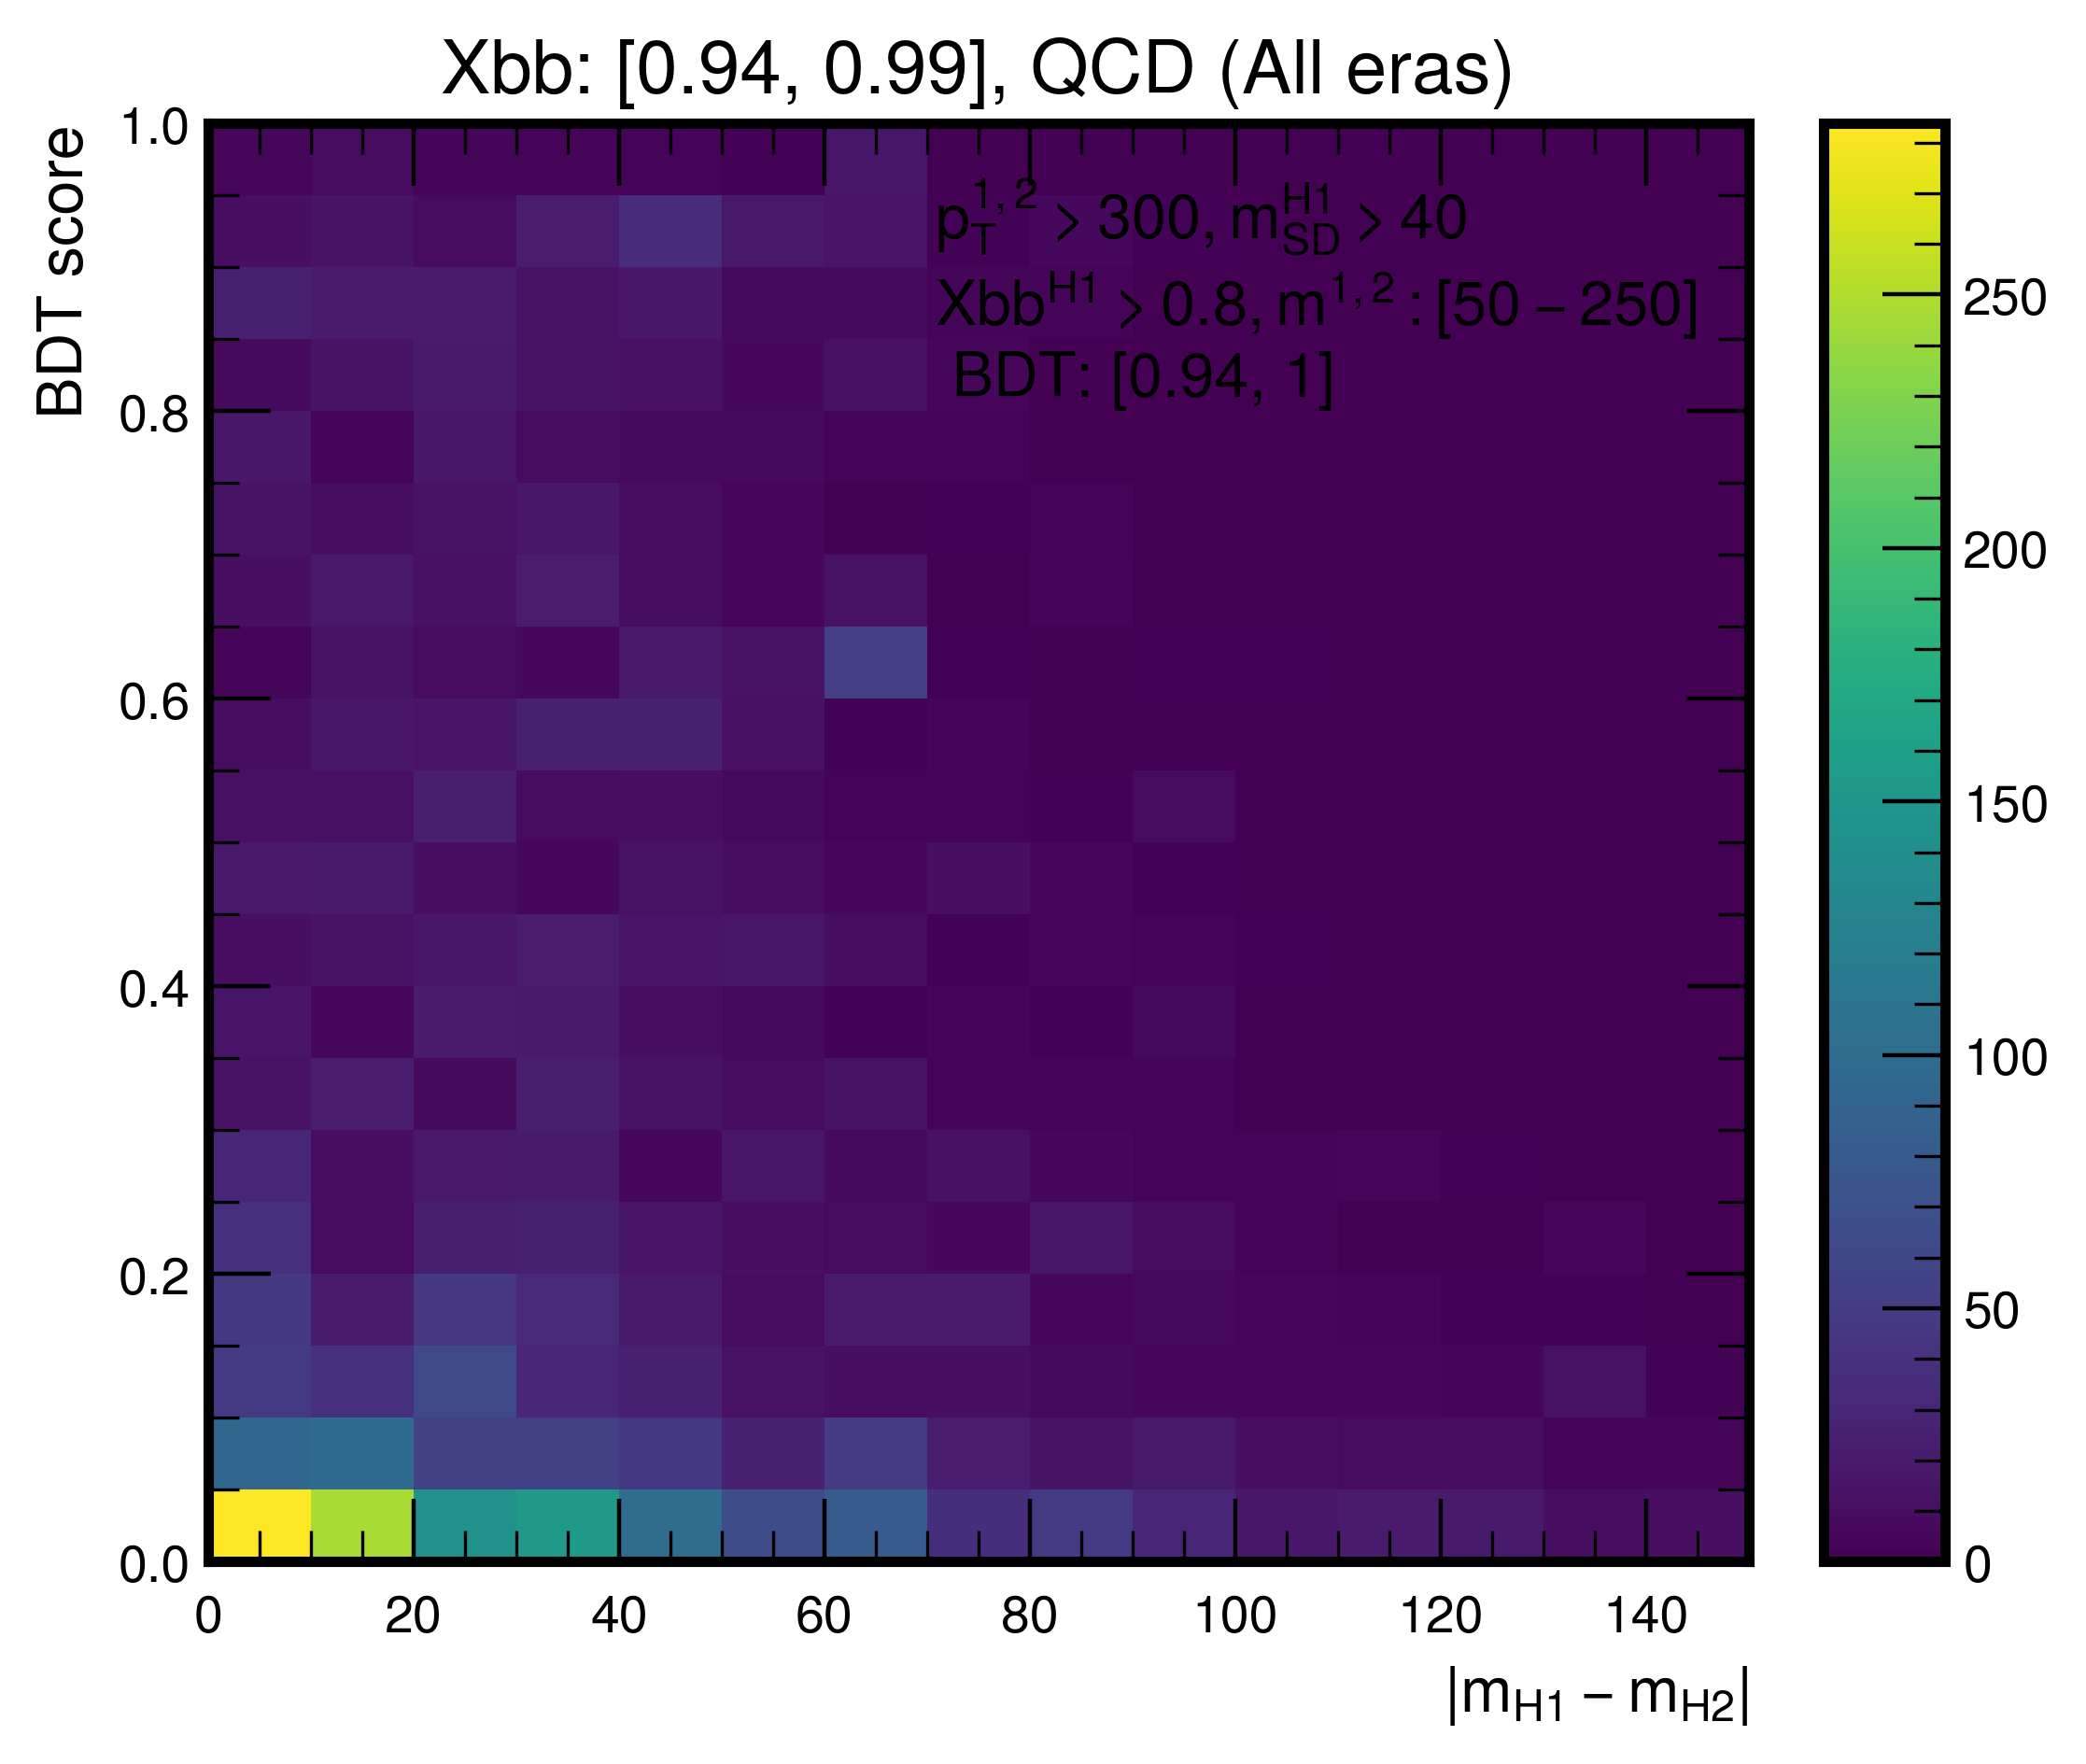

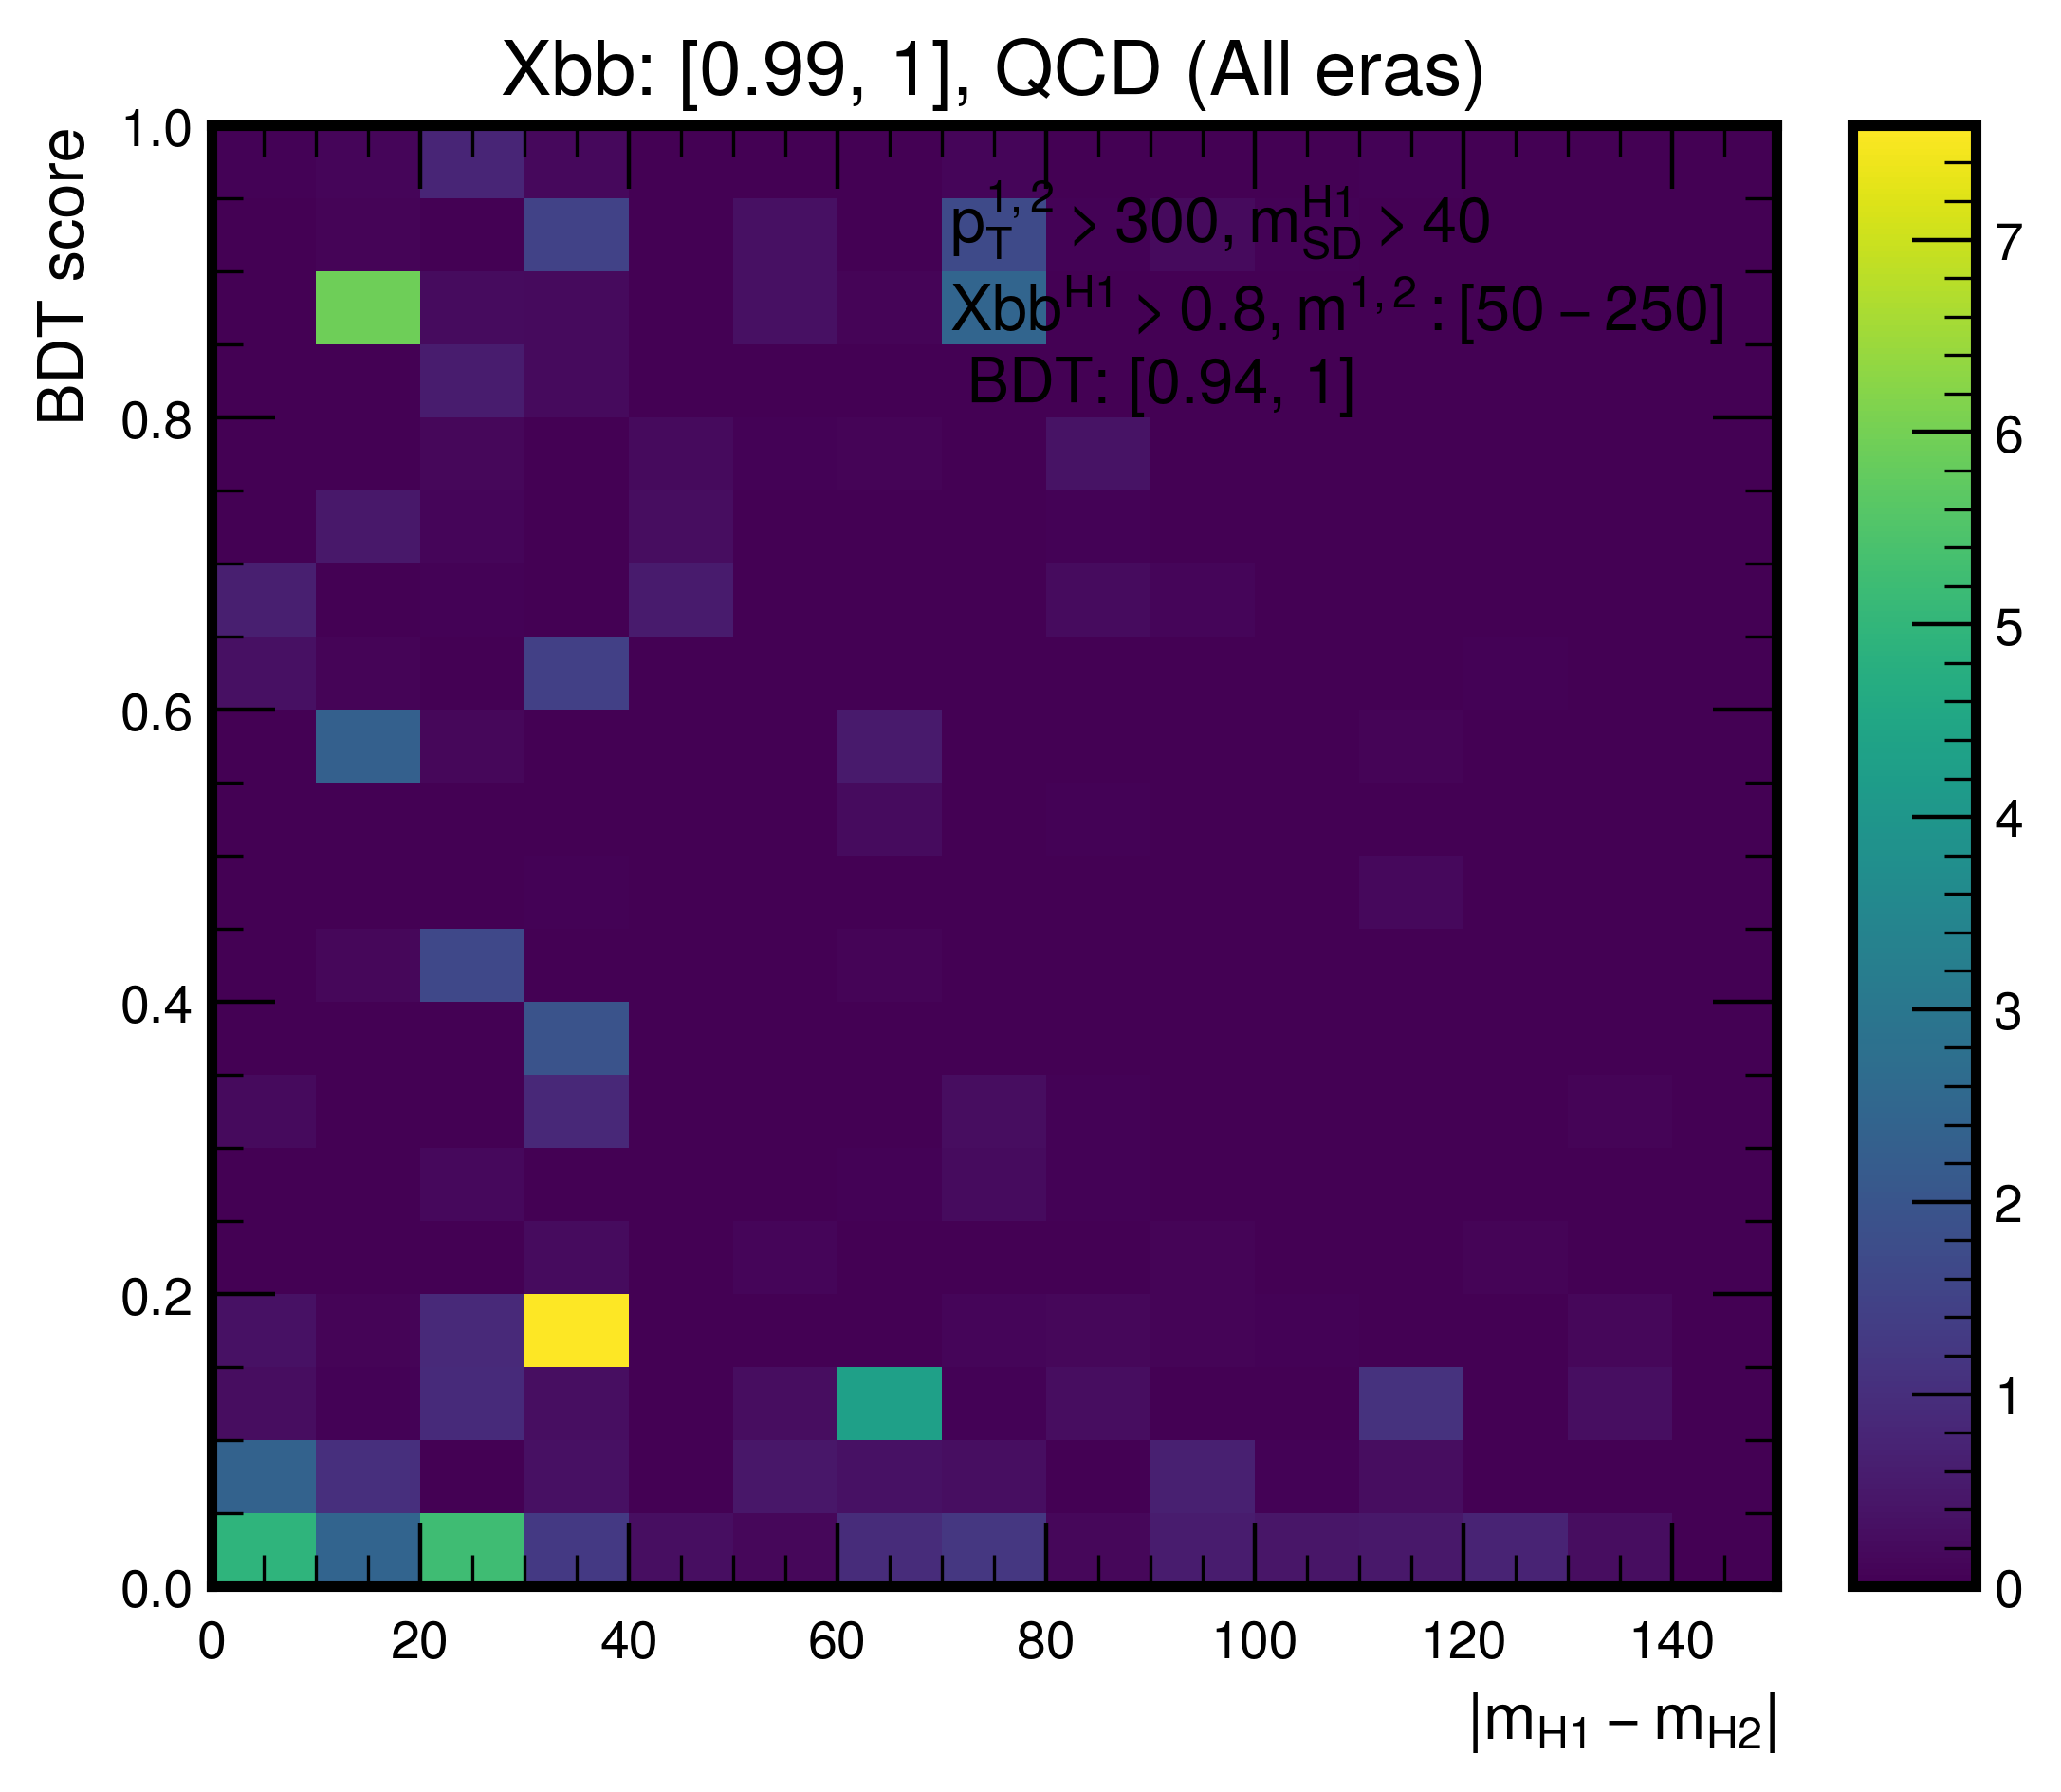

In [11]:
for ix, xbb_cut in enumerate(xbb_cuts):
    h_diff_2d = hist.Hist(diff_axis, bdt_axis, sample_axis)

    for key, events in events_combined.items():
        # apply Xbb cut
        events = events[(events["H2TXbb"] > xbb_cut[0]) & (events["H2TXbb"] <= xbb_cut[1])]

        mass_diff = abs(events["H1PNetMass"] - events["H2PNetMass"])
        bdt = events["bdt_score"]
        h_diff_2d.fill(mass_diff, bdt, key, weight=events["weight"])

    for key in events_combined:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        hep.hist2dplot(
            h_diff_2d[{"samp": key}],
            flow="none",
        )
        ax.legend(title=presel + f"\n BDT: {bdt_cut}")
        ax.set_xlabel(r"$|m_{H1} - m_{H2}|$")
        ax.set_title(f"Xbb: {xbb_cut}, {labels[key]}")
        ax.set_ylabel("BDT score")
        fig.savefig(f"{odir}/2d_{key}_xbbcut{ix}.png")

## Look at BDT score after mass cut

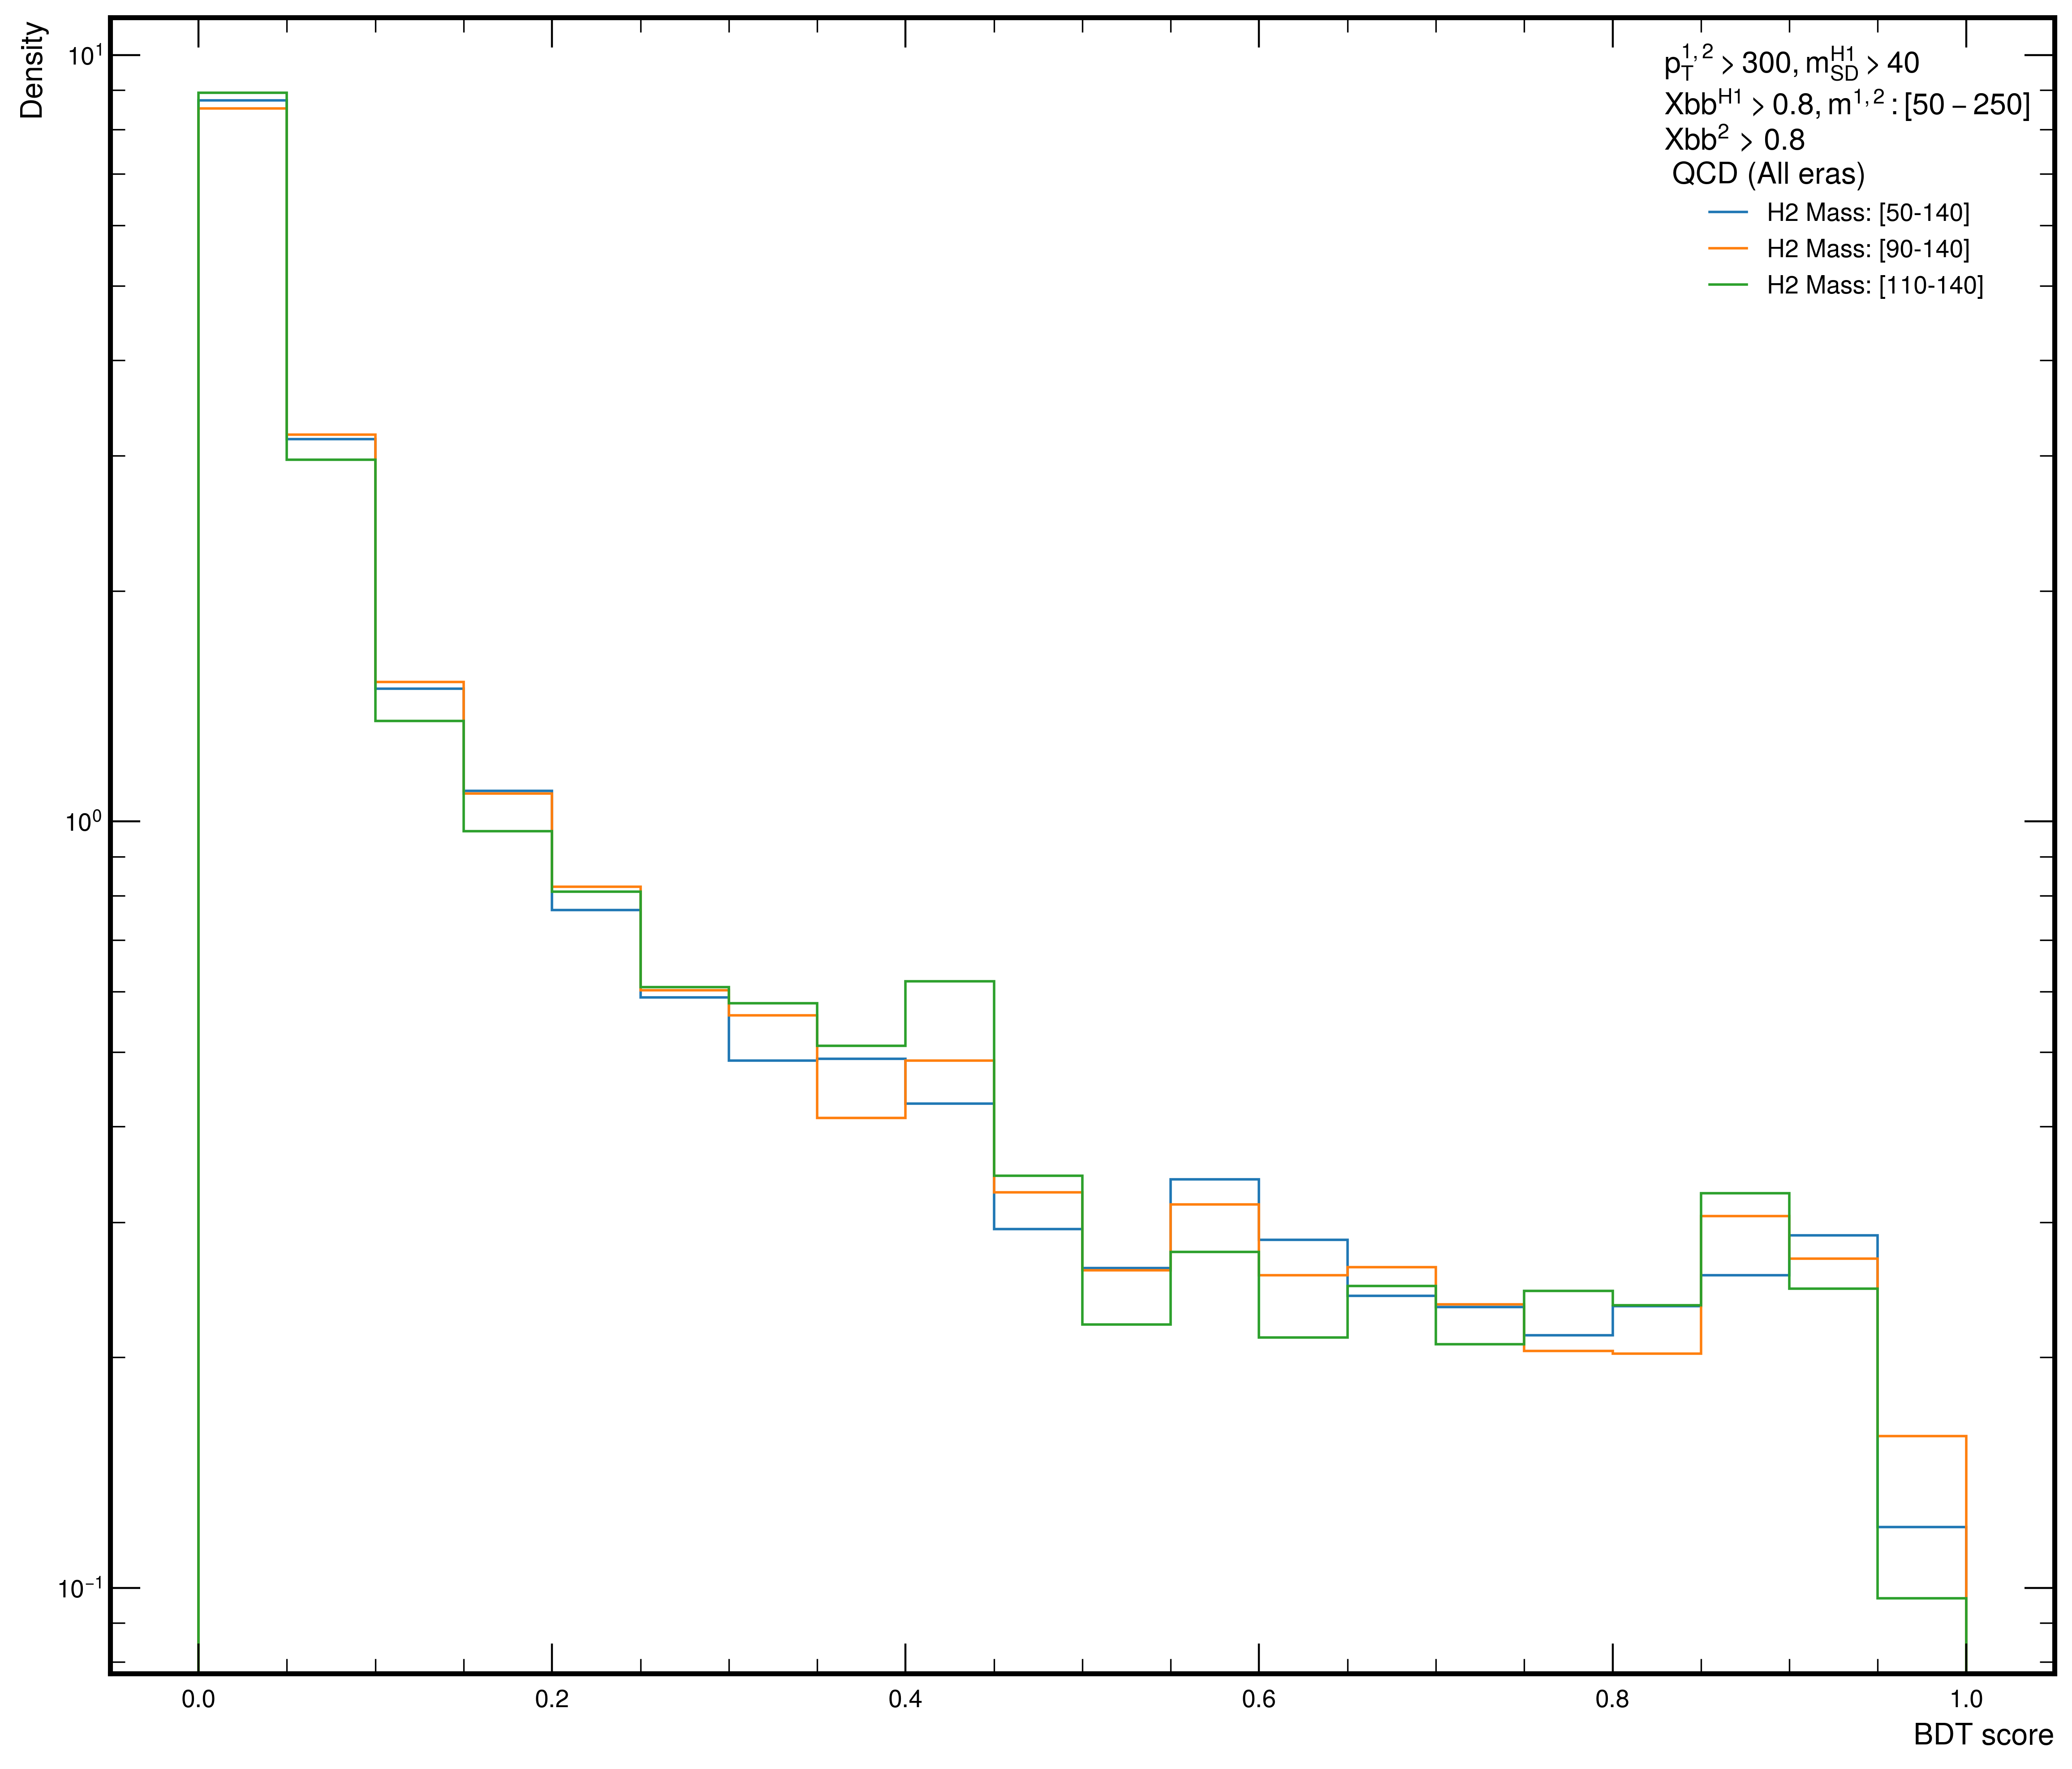

In [12]:
# odir = "../../../plots/Sculpting_All/"
odir = "../../../plots/Sculpting_QCD/"
# odir = "../../../plots/Sculpting_Data/"
os.system(f"mkdir -p {odir}")

presel = r"$p^{1,2}_T > 300, m_{SD}^{H1} > 40$" + "\n" + r"$Xbb^{H1} > 0.8, m^{1,2}: [50-250]$"

labels = {
    "ttbar": "TT + jets (All eras)",
    "hh4b": "HH(4b) (2022EE+2023)",
    "data": "JetMet Run2022E",
    "qcd": "QCD (All eras)",
}

lower_mass_cuts = [50, 90, 110]
upper_mass_cut = 140

xbb_cut = 0.8
h_bdt = hist.Hist(bdt_axis, sample_axis, cut_axis)

for key, events in events_combined.items():
    # apply Xbb cut
    events = events[(events["H2TXbb"] > xbb_cut) & (events["H2PNetMass"] <= upper_mass_cut)]

    bdt = events["bdt_score"]

    for i, mass_cut in enumerate(lower_mass_cuts):
        mask = (events["H2PNetMass"] > mass_cut)
        weight = events["weight"]
        h_bdt.fill(bdt[mask], key, str(i), weight=weight[mask])

for key in events_combined:
    fig, ax = plt.subplots(1, 1, figsize=(14, 12))
    for i, mass_cut in enumerate(lower_mass_cuts):
        try:
            x = h_bdt[{"samp": key, "cut": str(i)}]
        except KeyError:
            print(f"No cut {i} for sample {key} in xbb_cut {xbb_cut}")
            break
        hep.histplot(
            h_bdt[{"samp": key, "cut": str(i)}],
            ax=ax,
            #histtype="errorbar",
            flow="none",
            label=f'H2 Mass: [{mass_cut}-{upper_mass_cut}]',
            #label=labels[key],
            density=True,
        )
    ax.set_yscale('log')
    ax.legend(title=presel + "\n"+r"$Xbb^{2}$"+f" > {xbb_cut}" + f"\n {labels[key]}", fontsize=10)
    ax.set_xlabel(r"BDT score")
    ax.set_ylabel("Density")
    fig.savefig(f"{odir}/1d_bdt_masscuts_{key}.png")